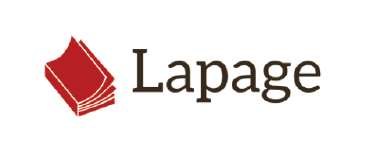

In [1]:
# import librairies needed for analysis
import datetime as dt
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import scipy.stats as st
import scikit_posthocs as sp
import seaborn as sns
from sklearn.feature_selection import chi2
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest

# import user-created functions
from functions import *

# use company logo colour in graphs
col = findColor('red.png')

In [2]:
# import data files
clients = pd.read_csv('customers.csv', encoding='latin-1')
books = pd.read_csv('products.csv', encoding='latin-1')
sales = pd.read_csv('transactions.csv', encoding='latin-1')

# Étape 1 - Import des données et vérification du typage des colonnes

## 1.1 - Table clients

In [3]:
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8623 entries, 0 to 8622
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   client_id  8623 non-null   object
 1   sex        8623 non-null   object
 2   birth      8623 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 202.2+ KB


In [4]:
# display first 5 lines of clients dataframe
clients.head()

client_id sex  birth
0    c_4410   f   1967
1    c_7839   f   1975
2    c_1699   f   1984
3    c_5961   f   1962
4    c_5320   m   1943

In [5]:
# rename columns
clients.rename(columns={'client_id': 'client_id_clients', 'sex':
                        'gender_clients', 'birth':'birth_year_clients'}, inplace=True)

# type casting
clients['client_id_clients'] = clients['client_id_clients'].astype('string')
clients['gender_clients'] = clients['gender_clients'].astype('string')

## 1.2 - Table books

In [6]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3287 entries, 0 to 3286
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id_prod  3287 non-null   object 
 1   price    3287 non-null   float64
 2   categ    3287 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 77.2+ KB


In [7]:
# display first 5 lines of books dataframe
books.head()

id_prod  price  categ
0  0_1421  19.99      0
1  0_1368   5.13      0
2   0_731  17.99      0
3   1_587   4.99      1
4  0_1507   3.99      0

In [8]:
# rename columns
books.rename(columns={'id_prod': 'product_id_books', 'price':
                      'price_books', 'categ':'category_books'}, inplace=True)

# type casting
books['product_id_books'] = books['product_id_books'].astype('string')
books['category_books'] = books['category_books'].astype('string')

## 1.3 - Table sales

In [9]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 679532 entries, 0 to 679531
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id_prod     679532 non-null  object
 1   date        679532 non-null  object
 2   session_id  679532 non-null  object
 3   client_id   679532 non-null  object
dtypes: object(4)
memory usage: 20.7+ MB


In [10]:
# display first 5 lines of sales dataframe
sales.head()

id_prod                        date session_id client_id
0  0_1518  2022-05-20 13:21:29.043970   s_211425     c_103
1   1_251  2022-02-02 07:55:19.149409   s_158752    c_8534
2  0_1277  2022-06-18 15:44:33.155329   s_225667    c_6714
3   2_209  2021-06-24 04:19:29.835891    s_52962    c_6941
4  0_1509  2023-01-11 08:22:08.194479   s_325227    c_4232

In [11]:
# rename columns
sales.rename(columns={'id_prod': 'product_id_sales', 'date':
                      'date_sales', 'session_id':'session_id_sales', 'client_id':'client_id_sales'}, inplace=True)

# type casting
sales['product_id_sales'] = sales['product_id_sales'] .astype('string')
sales['session_id_sales'] = sales['session_id_sales'].astype('string')
sales['client_id_sales'] = sales['client_id_sales'].astype('string')
# sales['date_sales'] = pd.to_datetime(sales['date_sales'])

#### La commande <sales['date_sales'] = pd.to_datetime(sales['date_sales'])> renvoie un message d'erreur <Unknown string format: test_2021-03-01 02:30:02.237419>, nous resoudrons ce probleme dans la 2eme partie.

In [12]:
# print unique client_ids in clients dataframe
cli = len(clients['client_id_clients'].unique())
print(cli, "identifiants clients uniques sont "
      "présents dans le fichier clients.")

# print unique client_ids in sales dataframe
cust = len(sales['client_id_sales'].unique())
print(cust, "identifiants clients uniques sont "
      "présents dans le fichier sales.")

# identify unique client_ids in clients file
clients_clientcount = clients['client_id_clients'].unique()

# identify unique client_ids in sales file
clients_salescount = sales['client_id_sales'].unique()

# print list of clients having never made a purchase
print((cli - cust), "clients n'ont jamais realise d'achat en ligne. Liste:\n")

# check info available on clients having made no purchases
list_a = clients_clientcount.tolist()
list_b = clients_salescount.tolist()
non_acheteurs = isInList(list_a, list_b)
no_sales = clients.loc[clients['client_id_clients'].isin(non_acheteurs) == True]
print(no_sales.to_csv("no_sales.csv", index=False))
no_sales

8623 identifiants clients uniques sont présents dans le fichier clients.
8602 identifiants clients uniques sont présents dans le fichier sales.
21 clients n'ont jamais realise d'achat en ligne. Liste:

None


client_id_clients gender_clients  birth_year_clients
801             c_8253              f                2001
2483            c_3789              f                1997
2734            c_4406              f                1998
2769            c_2706              f                1967
2851            c_3443              m                1959
3179            c_4447              m                1956
3190            c_3017              f                1992
3334            c_4086              f                1992
3721            c_6930              m                2004
3821            c_4358              m                1999
4724            c_8381              f                1965
4791            c_1223              m                1963
6112            c_6862              f                2002
6208            c_5245              f                2004
6338            c_5223              m                2003
6471            c_6735              m                2004
6585             c_862              f                1956
6828            c_7584              f                1960
7790              c_90              m                2001
7819             c_587              m                1993
8536            c_3526              m                1956

#### L'information sur les clients n'ayant jamais effectue d'achats en ligne apparait complete. On ne note pas d'irregularites dans les donnees et les clients semblent distribues dans les 2 genres et des tranches d'age diverses.

In [13]:
# print list of clients having made purchases but missing from clients table
print("\n Liste des clients ayant realise des achats en ligne mais absents du fichier clients:\n")
isInList(list_b, list_a)


 Liste des clients ayant realise des achats en ligne mais absents du fichier clients:



[]

In [14]:
# print number of unique book references in books dataframe
ref = len(books['product_id_books'].unique())
print(ref, "identifiants produit uniques sont présents dans le fichier books.")

# print number of unique book references in sales dataframe
sold = len(sales['product_id_sales'].unique())
print(sold, "identifiants produit uniques sont présents dans le fichier sales.")

# identify unique book references in books file
books_bookcount = books['product_id_books'].unique()

# identify unique book references in sales file
books_salescount = sales['product_id_sales'].unique()

list_c = books_bookcount.tolist()
list_d = books_salescount.tolist()

# print list of books sold but missing from books table
no_ref = isInList(list_d, list_c)      
print("\n Liste des livres vendus en ligne mais absents du fichier books:\n")      
no_ref      
      

3287 identifiants produit uniques sont présents dans le fichier books.
3267 identifiants produit uniques sont présents dans le fichier sales.

 Liste des livres vendus en ligne mais absents du fichier books:



['0_2245']

In [15]:
# print list of books having never been sold online
non_vendus = isInList(list_c, list_d)
print((ref + len(no_ref) - sold ), "livres n'ont jamais ete vendus en ligne. Liste:\n")
not_sold = books.loc[books['product_id_books'].isin(non_vendus) == True]
print(not_sold.to_csv("not_sold.csv", index=False))
not_sold

21 livres n'ont jamais ete vendus en ligne. Liste:

None


product_id_books  price_books category_books
184            0_1016        35.06              0
279            0_1780         1.67              0
737            0_1062        20.08              0
794            0_1119         2.99              0
811            0_1014         1.15              0
846               1_0        31.82              1
1031           0_1318        20.92              0
1139           0_1800        22.05              0
1347           0_1645         2.99              0
1505            0_322         2.99              0
1530           0_1620         0.80              0
1543           0_1025        24.99              0
1709             2_87       220.99              2
1863            1_394        39.73              1
1946             2_72       141.32              2
2215            0_310         1.94              0
2408           0_1624        24.50              0
2525             2_86       132.36              2
2690            0_299        22.99              0
3031            0_510        23.66              0
3096           0_2308        20.28              0

#### La majorite des produits jamais vendus en ligne sont de categorie 0. Leurs informations semblent completes (pas d'irregularites ni d'erreurs manifestes observees).

In [16]:
# check sales for book missing from books table
sale_0_2245 = sales.loc[(sales['product_id_sales'] == no_ref[0])].copy()
sale_0_2245

product_id_sales                  date_sales session_id_sales  \
2633             0_2245  2022-09-23 07:22:38.636773         s_272266   
10106            0_2245  2022-07-23 09:24:14.133889         s_242482   
11727            0_2245  2022-12-03 03:26:35.696673         s_306338   
15675            0_2245  2021-08-16 11:33:25.481411          s_76493   
16377            0_2245  2022-07-16 05:53:01.627491         s_239078   
...                 ...                         ...              ...   
669730           0_2245  2021-08-25 09:06:03.504061          s_80395   
670682           0_2245  2022-03-06 19:59:19.462288         s_175311   
671286           0_2245  2022-05-16 11:35:20.319501         s_209381   
675679           0_2245  2022-02-11 09:05:43.952857         s_163405   
677996           0_2245  2021-12-14 22:34:54.589921         s_134446   

       client_id_sales  
2633            c_4746  
10106           c_6713  
11727           c_5108  
15675           c_1391  
16377           c_7954  
...                ...  
669730           c_131  
670682          c_4167  
671286          c_4453  
675679          c_1098  
677996          c_4854  

[221 rows x 4 columns]

#### Le produit 0_2245 a ete vendu 221 fois. L'absence d'informations sur le prix de ce livre dans la table books minorera donc notre chiffre d'affaires total.
#### L'absence de ce prix est un probleme isole qui resulte probablement d'une erreur de saisie; nous choisissons donc d'ajouter ce produit a la table books en lui imputant un prix egal a la mediane des prix des produits de sa categorie, la categorie etant identifiee par le premier caractere de la reference du produit (cf. verification de cette au point 2.1.2 ci-dessous.)

In [17]:
# impute median price to product 0_2245 (sold online 221 times but missing from books table)
price_0_2245 = books.loc[(books['category_books'] == '0')]['price_books'].median()
books = books.append({'product_id_books':'0_2245', 'price_books': price_0_2245, 'category_books':'0'},ignore_index=True)
books.loc[books['product_id_books'] == '0_2245']

C:\Users\PC\AppData\Local\Temp\ipykernel_17368\905351990.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  books = books.append({'product_id_books':'0_2245', 'price_books': price_0_2245, 'category_books':'0'},ignore_index=True)


product_id_books  price_books category_books
3287           0_2245        10.32              0

# Étape 2 - Étude de la qualité des données, duplicatas, imputations, suppressions d'indicateurs

## 2.1 - Identification, analyse & suppression des doublons¶

### 2.1.1 - Lignes dupliquees

In [18]:
# check for duplicates
print(clients.duplicated(subset=None, keep='first').sum(), "doublons dans la table clients.")
print(books.duplicated(subset=None, keep='first').sum(), "doublons dans la table books.")
print(sales.duplicated(subset=None, keep='first').sum(), "doublons dans la table sales.")

0 doublons dans la table clients.
0 doublons dans la table books.
126 doublons dans la table sales.


In [19]:
# check duplicates in sales table
sales_dup = sales[sales[['product_id_sales', 'date_sales', 'session_id_sales', 'client_id_sales']].duplicated() == True]
sales_dup.head()

product_id_sales                       date_sales session_id_sales  \
27778               T_0  test_2021-03-01 02:30:02.237437              s_0   
52424               T_0  test_2021-03-01 02:30:02.237419              s_0   
96687               T_0  test_2021-03-01 02:30:02.237412              s_0   
130188              T_0  test_2021-03-01 02:30:02.237419              s_0   
139339              T_0  test_2021-03-01 02:30:02.237443              s_0   

       client_id_sales  
27778             ct_1  
52424             ct_0  
96687             ct_1  
130188            ct_0  
139339            ct_1

#### La table sales semble contenir des donnees de test. Verifions les product_id_sales, session_id_sales et client_id_sales concernes:

In [20]:
test_pid = sales_dup['product_id_sales'].unique()
print("References produit utilisees en phase de test:")
print(*test_pid, sep=", ")

References produit utilisees en phase de test:
T_0


In [21]:
test_sid = sales_dup['session_id_sales'].unique()
print("References session utilisees en phase de test:")
print(*test_sid, sep=", ")

References session utilisees en phase de test:
s_0


In [22]:
test_cid = sales_dup['client_id_sales'].unique()
print("References client utilisees en phase de test:")
print(*test_cid, sep=", ")

References client utilisees en phase de test:
ct_1, ct_0


In [23]:
# temporarily cast date_sales to string to be able to use string operations
sales['date_sales'] = sales['date_sales'].astype('string')

# check duplicated lines contain only test data
sales_test = sales_dup.loc[(sales['date_sales'].str.startswith("test") == True)]
sales_test.shape

(126, 4)

In [24]:
# remove all lines where date starts with the "test" string from sales dataframe
sales_trim = sales.loc[(~sales['date_sales'].str.startswith("test") == True)].copy()
print(sales_trim.to_csv("sales_trim.csv", index=False))

None


In [25]:
# check no more duplicates remain
print(sales_trim.duplicated(subset=None, keep='first').sum(), "doublons dans la table transactions.")

0 doublons dans la table transactions.


#### Retirer les elements de la colonne date_sales qui commencent par "test" semble avoir elimine tous nos doublons. Verifions egalement que les references produit, session et client utilises pour les tests sont a present totalement absents de la table sales.

In [26]:
sales_trim.loc[sales_trim['product_id_sales'] == "T_0"]

Empty DataFrame
Columns: [product_id_sales, date_sales, session_id_sales, client_id_sales]
Index: []

In [27]:
sales_trim.loc[sales_trim['session_id_sales'] == "s_0"]

Empty DataFrame
Columns: [product_id_sales, date_sales, session_id_sales, client_id_sales]
Index: []

In [28]:
sales_trim.loc[(sales_trim['client_id_sales'] == "ct_0") | (sales_trim['client_id_sales'] == "ct_1")]

Empty DataFrame
Columns: [product_id_sales, date_sales, session_id_sales, client_id_sales]
Index: []

#### Les references produit, session et client utilises pour les tests sont bien a present totalement absents de la table sales. Les donnees restantes peuvent dont etre considerees commes reelles (et non issues de tests).
#### En pratique, il serait bon d'eviter d'effectuer ces tests sur une base deja en prod, afin de minimiser non seulement les risques d'erreurs mais aussi de simplifier le retraitement des donnees exportees.

In [29]:
# cast date_sales type to datetime
sales_trim['date_sales'] = pd.to_datetime(sales_trim['date_sales'])

#### Une fois les lignes dupliquees supprimees, il est possible de caster la colonne ['date_sales'] de la nouvelle table sales_trim en datetime, toutes les dates commencant par des chaines de caracteres ayant ete supprimees.

### 2.1.2 - Autres informations dupliquees

#### Il semblerait que le premier caractere des chaines dans la colonne product_id_books de la table books soit un marqueur de la categorie a laquelle appartient le produit (colonne category_books). Verifions si c'est bien le cas.

In [30]:
# create copy of books table
books2 = books.copy()

# add column with 1st caracter of product reference string
books2['pid_0'] = books2['product_id_books'].str[:1]

# add colomn with boolean value indicating if 1st caracter of product reference string equals book category
books2.loc[(books2['category_books'] == books2['pid_0']), 'check'] = True
books2.loc[(books2['category_books'] != books2['pid_0']), 'check'] = False
books2.shape

(3288, 5)

In [31]:
# count number of lines where 1st caracter of product reference string equals book category
books2.loc[books2['check'] == True].count()

product_id_books    3287
price_books         3287
category_books      3287
pid_0               3287
check               3287
dtype: int64

In [32]:
# count number of lines where 1st caracter of product reference string does not equal book category
books2.loc[books2['check'] == False].count()

product_id_books    1
price_books         1
category_books      1
pid_0               1
check               1
dtype: int64

#### Notre hypothese est verifiee pour toutes les lignes de la table books sauf une. Verifions-en les caracteristiques:

In [33]:
books2.loc[books2['check'] == False]

product_id_books  price_books category_books pid_0  check
731              T_0         -1.0              0     T  False

#### Il s'agit du produit de test deja identifie lors du nettoyage de la table sales. Notre hypothese est donc verifiee, le premier caractere de l'identifiant du produit correspond bien a sa categorie.
#### On notera que ce format de product_id_books ne respecte pas la 1NF (product_id_books n'est pas atomique et la table books contient donc des informations redondantes). Cela ne nous posera pas de problemes pour la manipulation des donnees, mais il serait recommande de resoudre cette redondance dans le stockage des donnees.
#### Afin de ne pas polluer l'analyse avec des donnes fictives, nous supprimons egalement les clients ct_0 et ct_1 utilises pour les tests de la table des clients.

In [34]:
clients.loc[(clients['client_id_clients'] == "ct_0") | (clients['client_id_clients'] == "ct_1")]

client_id_clients gender_clients  birth_year_clients
2735              ct_0              f                2001
8494              ct_1              m                2001

In [35]:
# remove test clients from clients table
clients = clients.loc[(clients['client_id_clients'] != "ct_0") & (clients['client_id_clients'] != "ct_1")]

In [36]:
clients.loc[(clients['client_id_clients'] == "ct_0") | (clients['client_id_clients'] == "ct_1")]

Empty DataFrame
Columns: [client_id_clients, gender_clients, birth_year_clients]
Index: []

## 2.2 - Identification des valeurs manquantes

<AxesSubplot:>

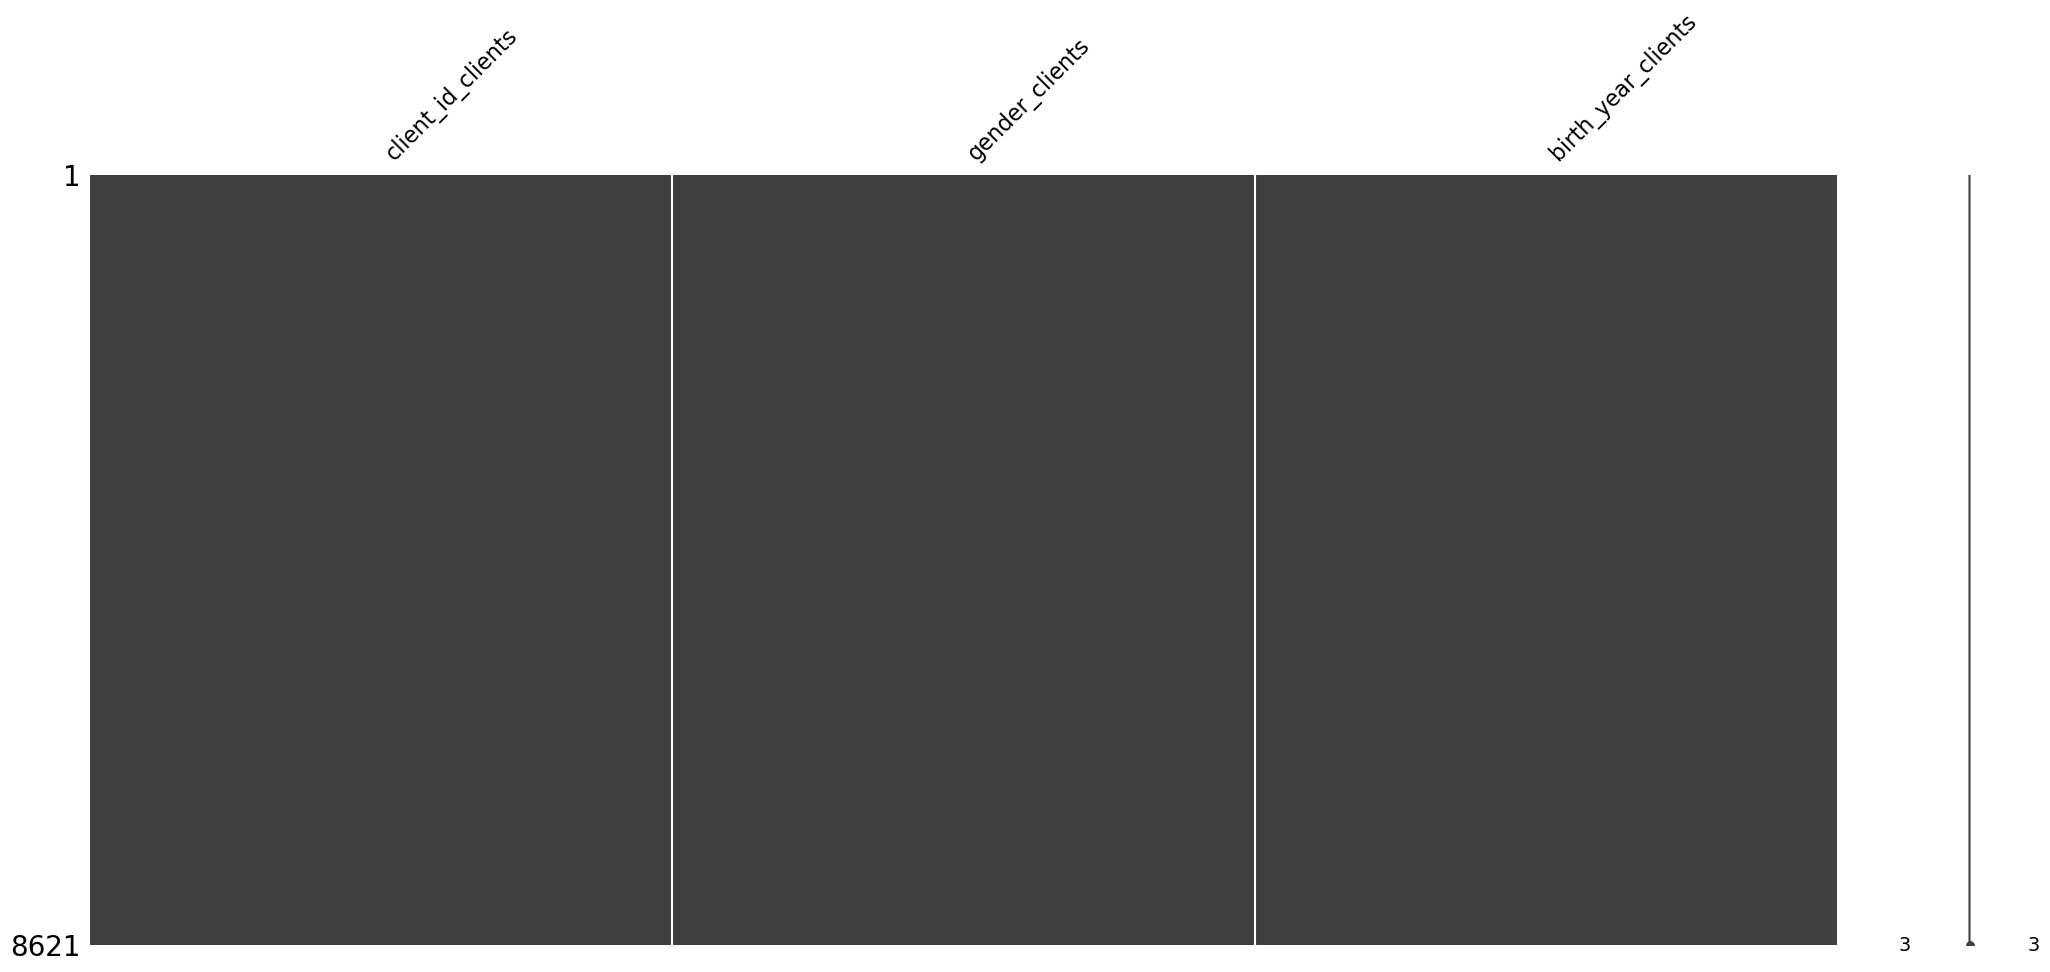

In [37]:
msno.matrix(clients)

#### La table clients ne semble pas comporter de valeurs manquantes.

<AxesSubplot:>

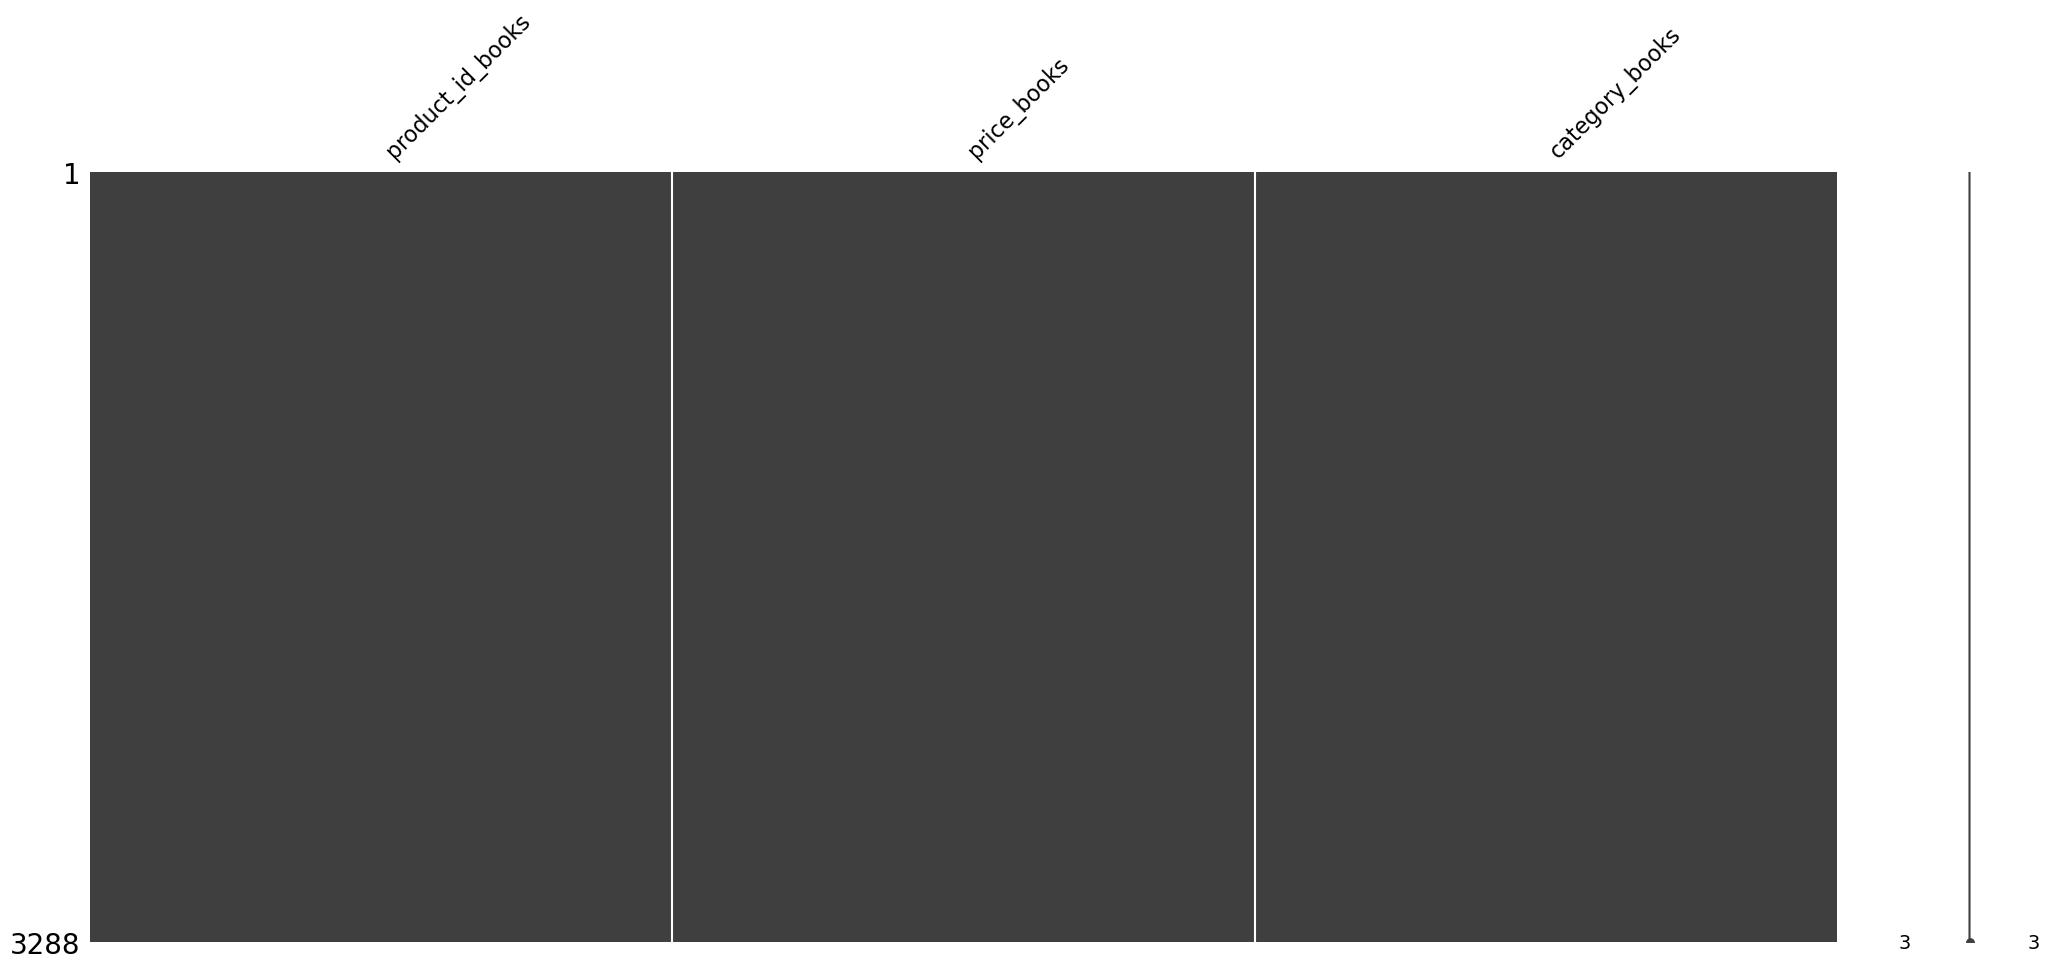

In [38]:
msno.matrix(books)

#### La table books ne semble pas comporter de valeurs manquantes.

<AxesSubplot:>

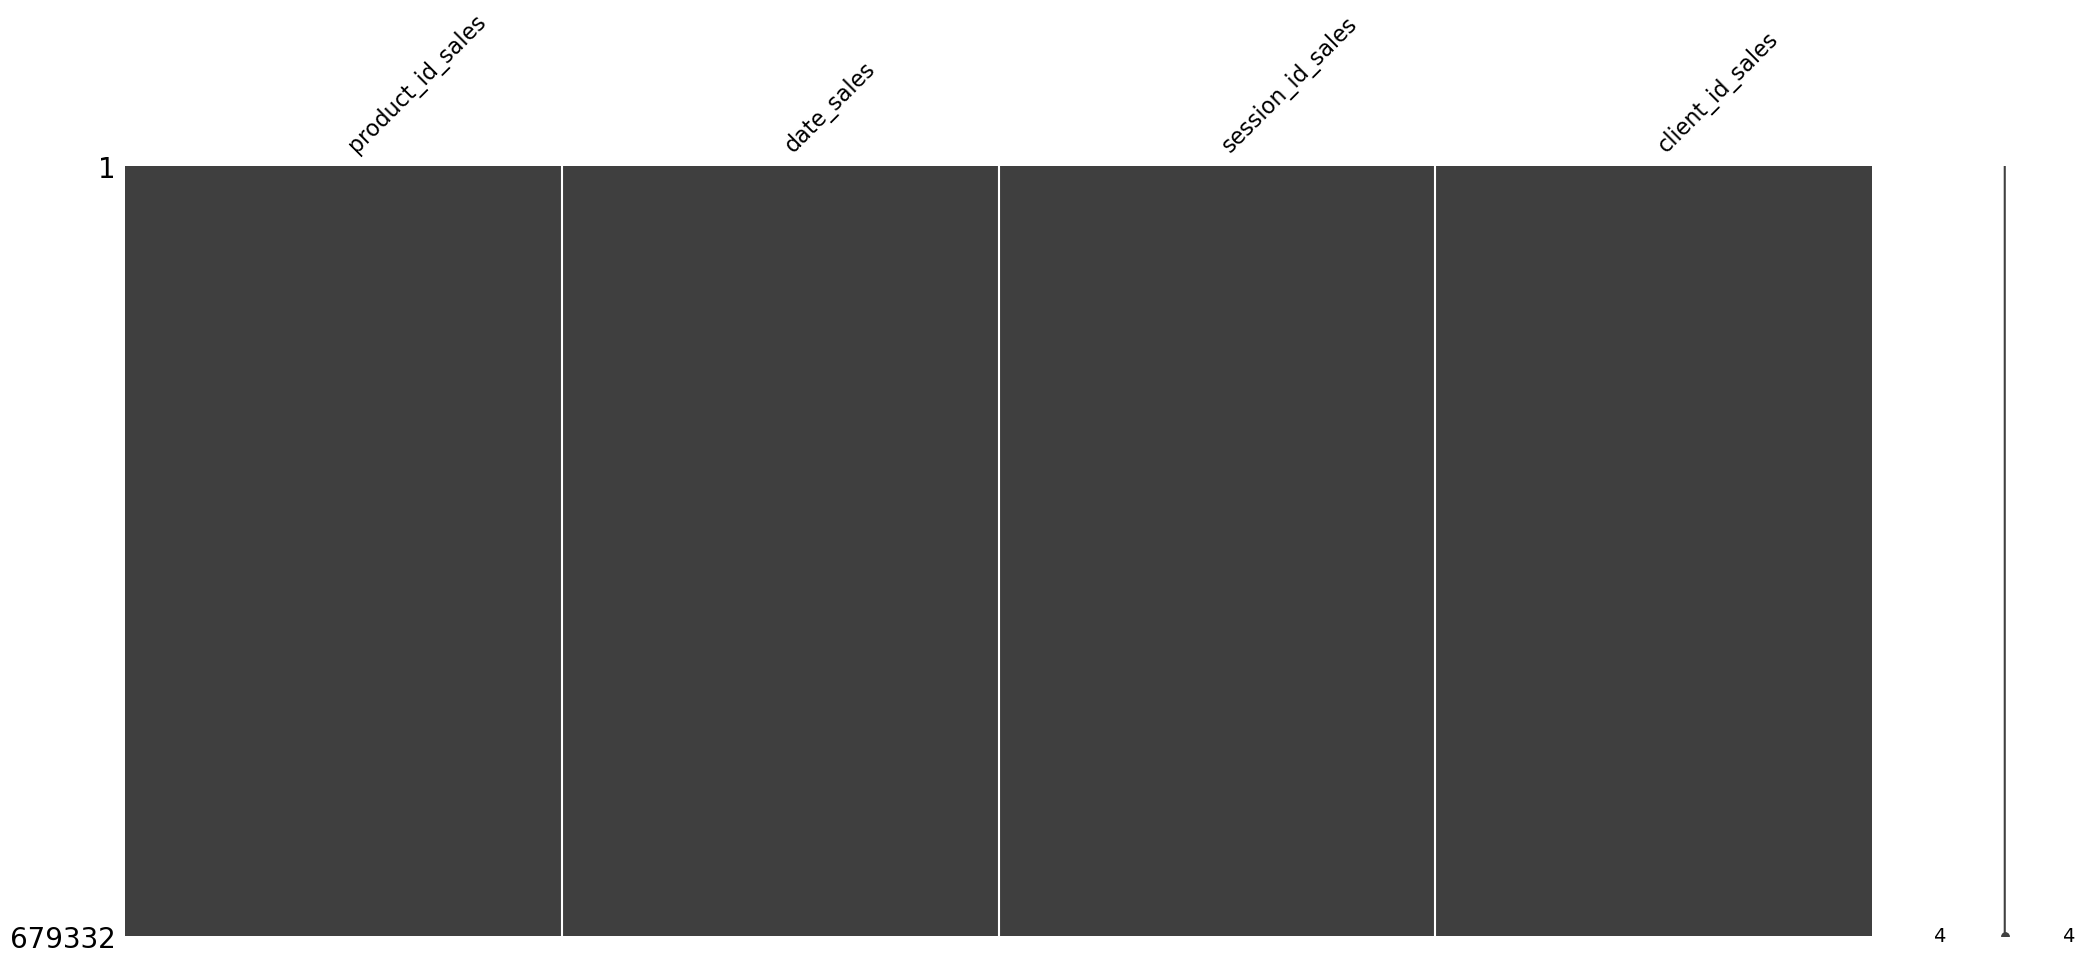

In [39]:
msno.matrix(sales_trim)

#### La table sales ne semble pas comporter de valeurs manquantes.

## 2.3 - Recherche d'outliers

### 2.3.1 - Table clients

In [40]:
# generate descriptive statistics
clients.describe(include='all')

client_id_clients gender_clients  birth_year_clients
count               8621           8621         8621.000000
unique              8621              2                 NaN
top               c_4410              f                 NaN
freq                   1           4490                 NaN
mean                 NaN            NaN         1978.275606
std                  NaN            NaN           16.917958
min                  NaN            NaN         1929.000000
25%                  NaN            NaN         1966.000000
50%                  NaN            NaN         1979.000000
75%                  NaN            NaN         1992.000000
max                  NaN            NaN         2004.000000

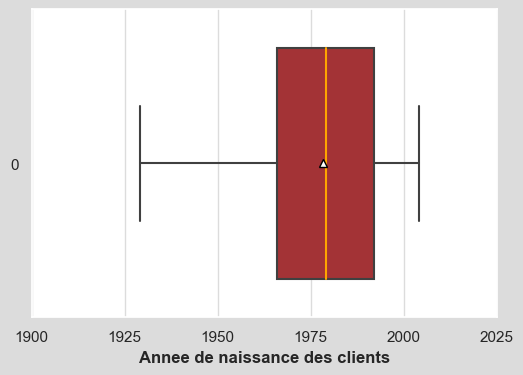

In [41]:
# analyse clients year of birth with a box plot
sns.set(rc={'figure.figsize':(6,4),'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})
graph1 = sns.boxplot(data=clients['birth_year_clients'], flierprops={"marker": "1"}, medianprops={"color" : "orange"},
            meanprops={"markerfacecolor":"white", "markeredgecolor":"black"}, orient="h", width=0.75, color=col,
            showmeans=True)
plt.xticks([1900, 1925, 1950, 1975, 2000, 2025])
plt.xlabel('Annee de naissance des clients', fontweight='bold', fontsize=12)
plt.grid(axis='x', color='gainsboro')
plt.savefig("graph1.png", bbox_inches='tight')

#### L'analyse de la table clients ne montre pas d'anomalie evidente dans la distribution des variables client_id_clients,	gender_clients et birth_year_clients.

### 2.3.2 - Table books

In [42]:
# generate descriptive statistics
books.describe(include='all')

product_id_books  price_books category_books
count              3288  3288.000000           3288
unique             3288          NaN              3
top              0_1421          NaN              0
freq                  1          NaN           2310
mean                NaN    21.853133            NaN
std                 NaN    29.844045            NaN
min                 NaN    -1.000000            NaN
25%                 NaN     6.990000            NaN
50%                 NaN    13.055000            NaN
75%                 NaN    22.990000            NaN
max                 NaN   300.000000            NaN

#### Un prix mimimum negatif apparait. Verifions la liste des produits a prix negatif ou nul:

In [43]:
books.loc[books['price_books'] <= 0]

product_id_books  price_books category_books
731              T_0         -1.0              0

#### Il s'agit du produit utilise en environnement de test deja identifie precedemment. Cette ligne peut donc etre supprimee de la table books.

In [44]:
books.drop(books.loc[books['price_books'] < 0].index, inplace=True)

#### Les 3 categories de produits semblent avoir des gammes de prix tres differentes, analysons-les separement.

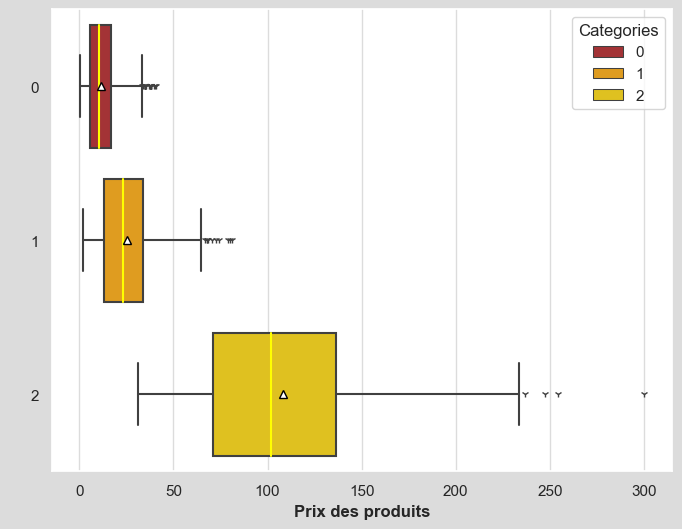

In [45]:
# analyse book prices with a box plot
sns.set(rc={'figure.figsize':(8,6),'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})
graph2 = sns.boxplot(data=books, y="category_books", x="price_books", hue="category_books", flierprops={"marker": "1"},
            medianprops={"color" : "yellow"}, meanprops={"markerfacecolor":"white", "markeredgecolor":"black"},
            orient="h", palette=[col, 'orange', 'gold'], showmeans=True, dodge=False)
plt.xlabel('Prix des produits', fontweight='bold', fontsize=12)
plt.ylabel(' ', fontweight='bold', fontsize=12)
plt.legend(title="Categories")
plt.grid(axis='x', color='gainsboro')
plt.savefig("graph2.png", bbox_inches='tight')
plt.show()

In [46]:
books_0 = books.loc[books['category_books'] == '0'].reset_index(drop=True)

# calculate first quartile
books_0_Q1 = np.percentile(books_0['price_books'], 25)

# calculate third quartile
books_0_Q3 = np.percentile(books_0['price_books'], 75)

# calculate interquartile range
books_0_IQ = books_0_Q3 - books_0_Q1

# calculate value of top whisker
books_0_top_whisker = books_0_Q3 + books_0_IQ*1.5
print("Valeur de la moustache haute pour la categorie 0:", round(books_0_top_whisker, 2), "€")

# list outliers
books_0_outliers = books_0[books_0['price_books'] > books_0_top_whisker]
print(books_0_outliers.shape[0], "articles de categorie 0 ont un prix supérieur à la moustache haute dans la table books. Liste:")
books_0_outliers

Valeur de la moustache haute pour la categorie 0: 33.24 €
22 articles de categorie 0 ont un prix supérieur à la moustache haute dans la table books. Liste:


product_id_books  price_books category_books
5              0_2157        34.99              0
30             0_1629        40.99              0
52              0_548        37.53              0
125            0_1016        35.06              0
259             0_907        34.99              0
264            0_1239        37.99              0
350             0_822        35.30              0
389             0_197        37.99              0
423             0_289        36.99              0
855            0_1544        37.91              0
911             0_920        37.46              0
955             0_494        39.58              0
1182           0_1415        34.99              0
1226            0_604        33.54              0
1481            0_573        34.99              0
1499            0_143        34.99              0
1704           0_2177        34.99              0
1823             0_60        37.64              0
1850           0_1597        33.99              0
1886           0_1581        37.99              0
1992           0_2147        39.99              0
2253           0_1749        34.99              0

In [47]:
books_1 = books.loc[books['category_books'] == '1'].reset_index(drop=True)

# calculate first quartile
books_1_Q1 = np.percentile(books_1['price_books'], 25)

# calculate third quartile
books_1_Q3 = np.percentile(books_1['price_books'], 75)

# calculate interquartile range
books_1_IQ = books_1_Q3 - books_1_Q1

# calculate value of top whisker
books_1_top_whisker = books_1_Q3 + books_1_IQ*1.5
print("Valeur de la moustache haute pour la categorie 1:", round(books_1_top_whisker, 2), "€")

# list outliers
books_1_outliers = books_1[books_1['price_books'] > books_1_top_whisker]
print(books_1_outliers.shape[0], "articles de categorie 1 ont un prix supérieur à la moustache haute dans la table books. Liste:")
books_1_outliers

Valeur de la moustache haute pour la categorie 1: 64.89 €
10 articles de categorie 1 ont un prix supérieur à la moustache haute dans la table books. Liste:


product_id_books  price_books category_books
48             1_496        70.51              1
178            1_315        66.99              1
192             1_10        78.83              1
195             1_13        80.99              1
209            1_679        79.99              1
243            1_354        68.49              1
375            1_184        67.65              1
515            1_514        67.66              1
622            1_171        73.99              1
661            1_608        72.75              1

In [48]:
books_2 = books.loc[books['category_books'] == '2'].reset_index(drop=True)

# calculate first quartile
books_2_Q1 = np.percentile(books_2['price_books'], 25)

# calculate third quartile
books_2_Q3 = np.percentile(books_2['price_books'], 75)

# calculate interquartile range
books_2_IQ = books_2_Q3 - books_2_Q1

# calculate value of top whisker
books_2_top_whisker = books_2_Q3 + books_2_IQ*1.5
print("Valeur de la moustache haute pour la categorie 2:", round(books_2_top_whisker, 2), "€")

# list outliers
books_2_outliers = books_2[books_2['price_books'] > books_2_top_whisker]
print(books_2_outliers.shape[0], "articles de categorie 2 ont un prix supérieur à la moustache haute dans la table books. Liste:")
books_2_outliers

Valeur de la moustache haute pour la categorie 2: 234.73 €
4 articles de categorie 2 ont un prix supérieur à la moustache haute dans la table books. Liste:


product_id_books  price_books category_books
30             2_158       247.22              2
52              2_76       254.44              2
70               2_2       300.00              2
102            2_167       236.99              2

#### En l'absence d'informations sur la nature des livres, il est impossible de discriminer entre les outliers produits et de determiner si les valeurs sont aberrantes ou atypiques ; ils seront donc tous conserves pour les analyses suivantes.

### 2.3.3 - Table sales_trim

In [49]:
# generate descriptive statistics
sales_trim.describe(include='all', datetime_is_numeric=True)  # second argument added to avoid deprecation warning

product_id_sales                     date_sales session_id_sales  \
count            679332                         679332           679332   
unique             3266                            NaN           342315   
top               1_369                            NaN         s_118668   
freq               2252                            NaN               14   
mean                NaN  2022-03-03 15:13:19.307389696              NaN   
min                 NaN     2021-03-01 00:01:07.843138              NaN   
25%                 NaN  2021-09-08 09:14:25.055994368              NaN   
50%                 NaN  2022-03-03 07:50:20.817730560              NaN   
75%                 NaN  2022-08-30 23:57:08.555173888              NaN   
max                 NaN     2023-02-28 23:58:30.792755              NaN   

       client_id_sales  
count           679332  
unique            8600  
top             c_1609  
freq             25488  
mean               NaN  
min                NaN  
25%                NaN  
50%                NaN  
75%                NaN  
max                NaN

#### Toutes les sessions dans la table sales_trim sont horodatees entre le 01/03/2021 et le 28/02/2023, soit 2 exercices comptables complets.
#### L'analyse de la table sales_trim ne montre pas d'anomalie evidente dans la distribution de la variable date_sales.

In [50]:
sales_trim['date_only_sales'] = pd.to_datetime(sales_trim['date_sales']).dt.date
sales_trim['date_only_sales'] = pd.to_datetime(sales_trim['date_only_sales'])
sales_trim_g = sales_trim.groupby('date_only_sales')[['session_id_sales', 'product_id_sales']].agg(
    ['count', 'size', 'nunique']).reset_index()
sales_trim_g.describe(include='all', datetime_is_numeric=True)

date_only_sales session_id_sales                           \
                                      count         size     nunique   
count                  730       730.000000   730.000000  730.000000   
mean   2022-02-28 12:00:00       930.591781   930.591781  471.098630   
min    2021-03-01 00:00:00       577.000000   577.000000  330.000000   
25%    2021-08-30 06:00:00       879.250000   879.250000  451.000000   
50%    2022-02-28 12:00:00       926.000000   926.000000  470.000000   
75%    2022-08-29 18:00:00       985.000000   985.000000  497.000000   
max    2023-02-28 00:00:00      1311.000000  1311.000000  549.000000   
std                    NaN       112.897676   112.897676   36.543919   

      product_id_sales                           
                 count         size     nunique  
count       730.000000   730.000000  730.000000  
mean        930.591781   930.591781  615.089041  
min         577.000000   577.000000  415.000000  
25%         879.250000   879.250000  589.000000  
50%         926.000000   926.000000  615.000000  
75%         985.000000   985.000000  643.000000  
max        1311.000000  1311.000000  782.000000  
std         112.897676   112.897676   55.208188

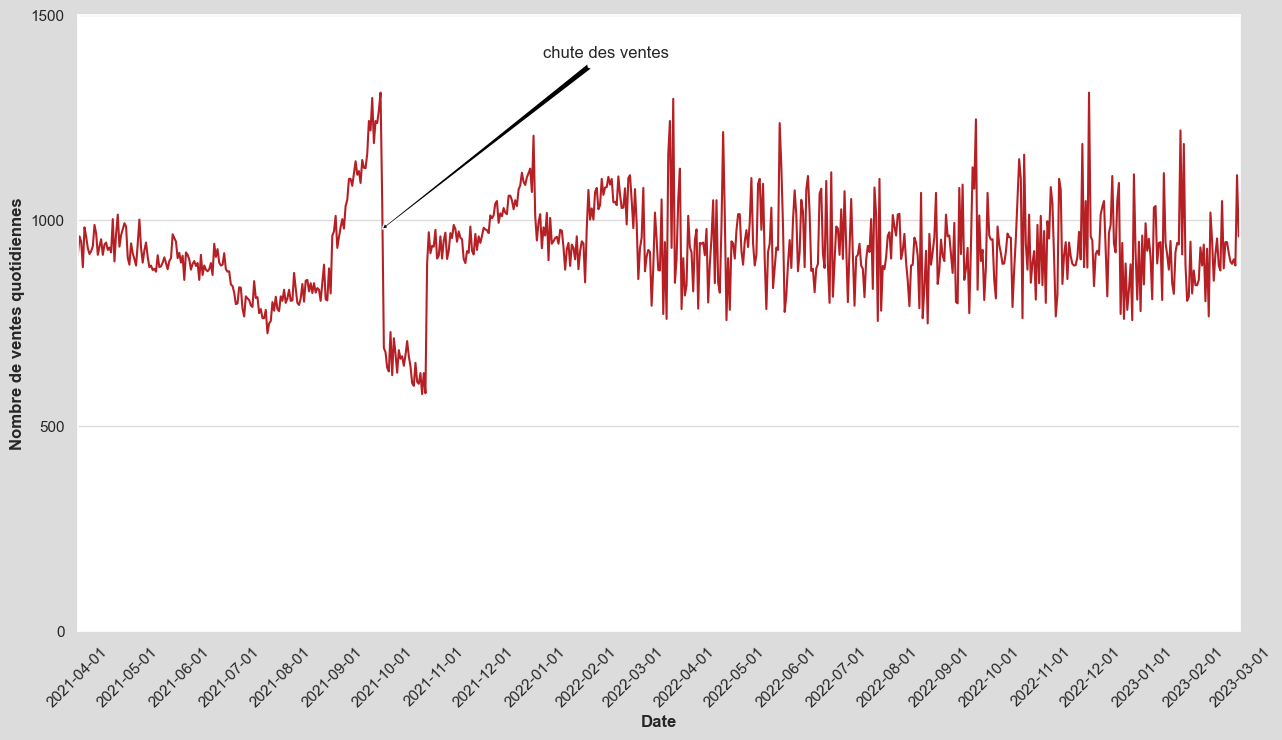

In [51]:
# plot distribution of daily sales in sales_trim table
sns.set(rc={'figure.figsize':(15,8),'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})
graph3 = sns.lineplot(data=sales_trim_g, x=('date_only_sales',        ''), y=('product_id_sales', 'count'),color=col)
plt.xticks(['2021-04', '2021-05', '2021-06', '2021-07', '2021-08', '2021-09', '2021-10', '2021-11', '2021-12',
            '2022-01', '2022-02', '2022-03', '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09', '2022-10',
            '2022-11', '2022-12','2023-01', '2023-02', '2023-03'], rotation=45)
plt.yticks([0,500,1000,1500])
plt.xlim([dt.date(2021, 4, 1), dt.date(2023, 3, 1)])
plt.xlabel('Date', fontweight='bold', fontsize='12')
plt.ylabel('Nombre de ventes quotidiennes', fontweight='bold', fontsize='12')
plt.grid(axis='y', color='gainsboro')

# anootate drop in sales
graph3.annotate('chute des ventes',xy=(0.26,0.65),xycoords='axes fraction',xytext=(0.40,.95),
            textcoords='axes fraction',va='top',ha='left',arrowprops=dict(facecolor='black', arrowstyle='fancy'))

plt.savefig("graph3.png",bbox_inches='tight')

#### On note des "sauts" dans les nombres de transactions quotidiennes entre septembre et octobre 2021 ainsi qu'entre janvier et fevrier 2022 qu'il conviendra d'expliquer.

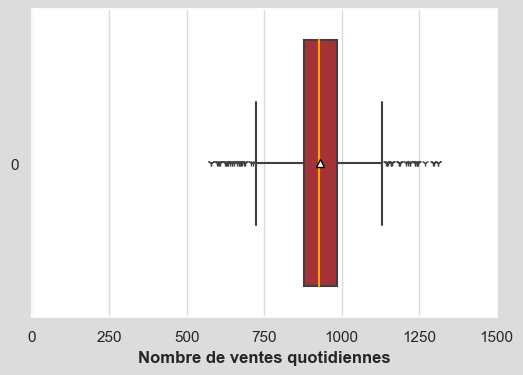

In [52]:
# analyse daily sales numbers with a box plot
sns.set(rc={'figure.figsize':(6,4),'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})
graph4 = sns.boxplot(data=sales_trim_g[('product_id_sales', 'count')], flierprops={"marker": "1"},
            medianprops={"color" : "orange"}, meanprops={"markerfacecolor":"white", "markeredgecolor":"black"},
            orient="h", color=col, showmeans=True)
plt.xticks([0, 250, 500, 750, 1000,1250,1500])
plt.xlabel('Nombre de ventes quotidiennes', fontweight='bold', fontsize=12)
plt.grid(axis='x', color='gainsboro')
plt.savefig("graph4.png", bbox_inches='tight')

In [53]:
# check normality of daily sales distribution with Anderson-Darling test
print(st.anderson(sales_trim_g[('product_id_sales', 'count')],dist="norm"))

AndersonResult(statistic=5.320182072680041, critical_values=array([0.573, 0.652, 0.783, 0.913, 1.086]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))


#### La statistique de test vaut 5.3202. Elle est superieure a toutes les valeurs critiques pour tous les niveaux de risque testes. Les resultats du test sont donc significatifs jusqu'au seuil de risque α = 1%, et nous avons donc suffisamment d'informations pour rejeter H0 et conclure que le nombre de ventes quotidiennes n'est pas distribue selon une loi N(μ,σ).

In [54]:
# check normality of daily sales distribution with Shapiro-Wilk test
stat, p = st.shapiro(sales_trim_g[('product_id_sales', 'count')])
alpha = 0.05
print('Statistique de test:', round(stat,4))
print('p-value:', round(p,4))
if p > alpha:
    print('La distribution est probablement gaussienne.')
else:
    print("La distribution n'est probablement pas gaussienne.")

Statistique de test: 0.9786
p-value: 0.0
La distribution n'est probablement pas gaussienne.


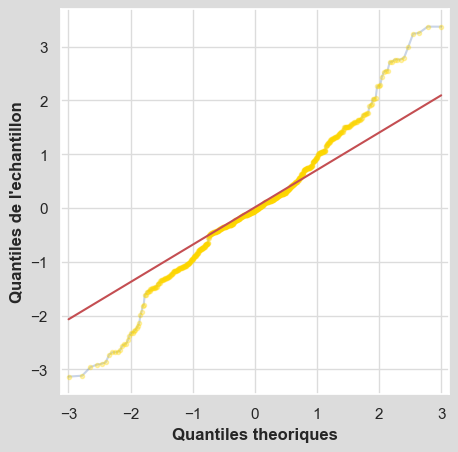

In [55]:
# check normality of daily sales distribution with a QQ plot
sns.set(rc={'figure.figsize':(5, 5),'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})
graph5 = sm.qqplot(sales_trim_g[('product_id_sales', 'count')],marker='.', markerfacecolor='gold',
                     markeredgecolor='gold', alpha=0.3, line="q", linestyle='solid', fit=True)
plt.xlabel("Quantiles theoriques", fontweight='bold', fontsize=12)
plt.ylabel("Quantiles de l'echantillon", fontweight='bold', fontsize=12)
plt.grid(axis='both', color='gainsboro')
plt.savefig("graph5.png", bbox_inches='tight')

#### Les quantiles de l'echantillon s'ecartent significativement des quantiles theoriques d'une loi Normale, confirmant graphiquement les resultats des tests numeriques.

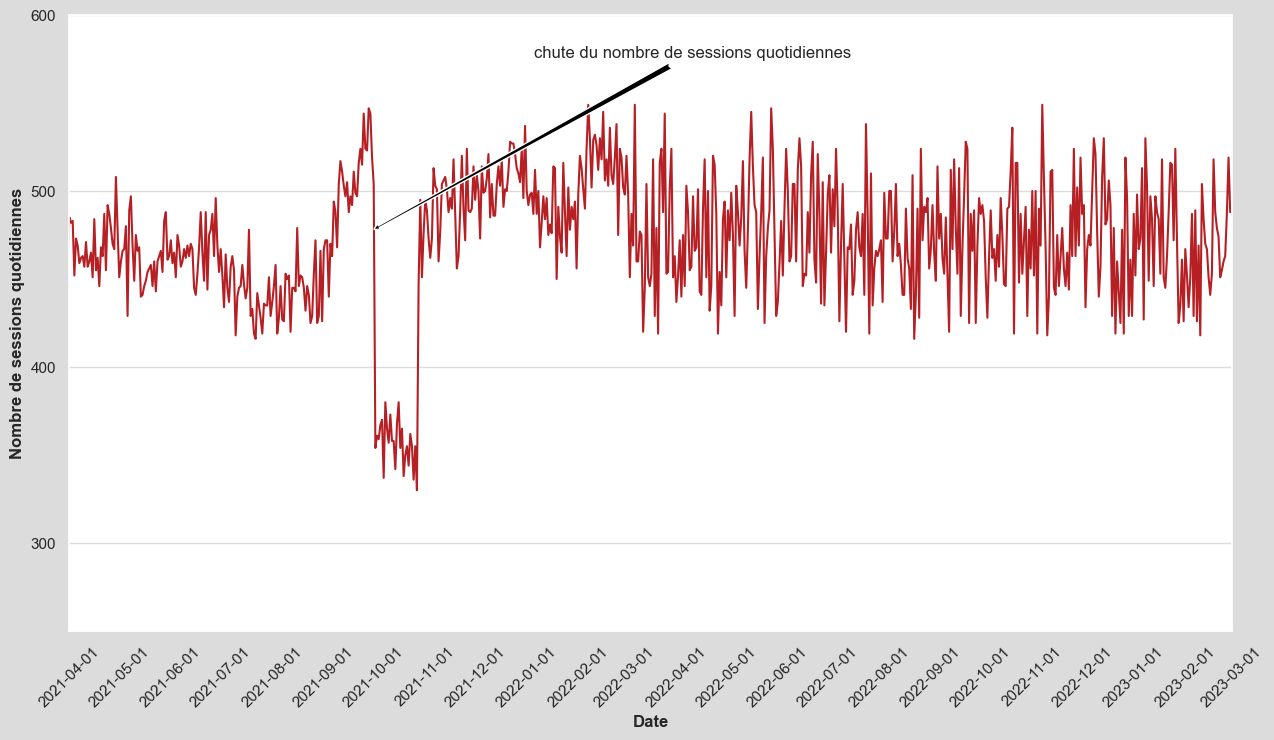

In [56]:
# plot distribution of daily sessions in sales_trim table
sns.set(rc={'figure.figsize':(15,8),'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})
graph6 = sns.lineplot(data=sales_trim_g, x=('date_only_sales',        ''), y=('session_id_sales', 'nunique'),color=col)
plt.xticks(['2021-04', '2021-05', '2021-06', '2021-07', '2021-08', '2021-09', '2021-10', '2021-11', '2021-12',
            '2022-01', '2022-02', '2022-03', '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09', '2022-10', '2022-11', '2022-12',
            '2023-01', '2023-02', '2023-03'], rotation=45)
plt.yticks([0,100,200,300,400,500,600])
plt.xlim([dt.date(2021, 4, 1), dt.date(2023, 3, 1)])
plt.ylim([250,600])
plt.xlabel('Date', fontweight='bold', fontsize='12')
plt.ylabel('Nombre de sessions quotidiennes', fontweight='bold', fontsize='12')
plt.grid(axis='y', color='gainsboro')


# annotate drop in daily sessions
graph6.annotate('chute du nombre de sessions quotidiennes',xy=(0.26,0.65),xycoords='axes fraction',xytext=(0.40,.95),
            textcoords='axes fraction',va='top',ha='left',arrowprops=dict(facecolor='black', arrowstyle='fancy'))

plt.savefig("graph6.png",bbox_inches='tight')

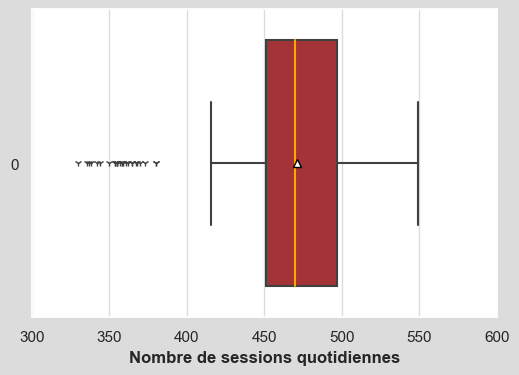

In [57]:
# analyse daily sessions with a box plot
sns.set(rc={'figure.figsize':(6,4),'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})
graph7 = sns.boxplot(data=sales_trim_g[('session_id_sales', 'nunique')], flierprops={"marker": "1"},
            medianprops={"color" : "orange"}, meanprops={"markerfacecolor":"white", "markeredgecolor":"black"},
            orient="h", color=col, showmeans=True)
plt.xticks([300, 350, 400, 450, 500, 550, 600])
plt.xlabel('Nombre de sessions quotidiennes', fontweight='bold', fontsize=12)
plt.grid(axis='x', color='gainsboro')
plt.savefig("graph7.png", bbox_inches='tight')
plt.show()

In [58]:
# check normality of daily sessions distribution with Anderson-Darling test
print(st.anderson(sales_trim_g[('session_id_sales', 'nunique')],dist="norm"))

AndersonResult(statistic=5.025177509684568, critical_values=array([0.573, 0.652, 0.783, 0.913, 1.086]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))


#### La statistique de test vaut 5.0252. Elle est superieure a toutes les valeurs critiques pour tous les niveaux de risque testes. Les resultats du test sont donc significatifs jusqu'au seuil de risque α = 1%, et nous avons donc suffisamment d'informations pour rejeter H0 et conclure que le nombre de sessions quotidiennes n'est pas distribue selon une loi N(μ,σ).

In [59]:
# check normality of daily sessions with Shapiro-Wilk test
stat3, p3 = st.shapiro(sales_trim_g[('session_id_sales', 'nunique')])
alpha3 = 0.05
print('Statistique de test:', round(stat3,4))
print('p-value:', round(p3,4))
if p > alpha3:
    print('La distribution est probablement gaussienne.')
else:
    print("La distribution n'est probablement pas gaussienne.")

Statistique de test: 0.9516
p-value: 0.0
La distribution n'est probablement pas gaussienne.


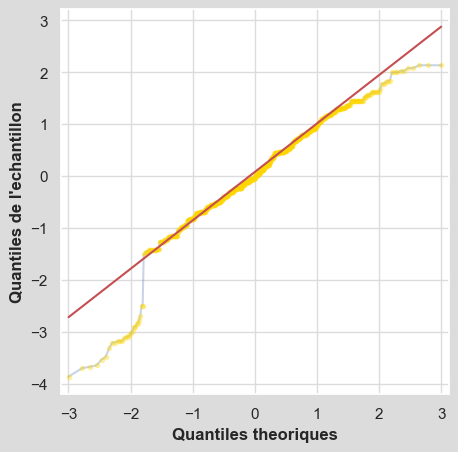

In [60]:
# check normality of daily sessions distribution with a QQ plot
sns.set(rc={'figure.figsize':(5, 5),'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})
graph8 = sm.qqplot(sales_trim_g[('session_id_sales','nunique')],marker='.', markerfacecolor='gold',
                     markeredgecolor='gold', alpha=0.3, line="q", linestyle='solid', fit=True)
plt.xlabel("Quantiles theoriques", fontweight='bold', fontsize=12)
plt.ylabel("Quantiles de l'echantillon", fontweight='bold', fontsize=12)
plt.grid(axis='both', color='gainsboro')
plt.savefig("graph8.png", bbox_inches='tight')

#### Les quantiles de l'echantillon s'ecartent significativement des quantiles theoriques d'une loi Normale, confirmant graphiquement les resultats des tests numeriques. Ni le nombre de sessions quotidiennes ni le nombre de ventes quotidiennes ne semblent distribuees selon une loi normale.

In [61]:
sales_trim_g2 = sales_trim.groupby('date_only_sales')['session_id_sales'].count().reset_index()

# calculate first quartile
sales_trim_g_Q1 = np.percentile(sales_trim_g2['session_id_sales'], 25)

# calculate third quartile
sales_trim_g_Q3 = np.percentile(sales_trim_g2['session_id_sales'], 75)

# calculate interquartile range
sales_trim_g_IQ = sales_trim_g_Q3 - sales_trim_g_Q1

# calculate value of bottom whisker
sales_trim_g_bottom_whisker = sales_trim_g_Q1 - sales_trim_g_IQ*1.5
print("Valeur de la moustache basse:", round(sales_trim_g_bottom_whisker, 2), "transactions par jour.")

# list bottom outliers
sales_trim_g_outliers_bottom = sales_trim_g2[sales_trim_g2['session_id_sales'] < sales_trim_g_bottom_whisker]
print(sales_trim_g_outliers_bottom.shape[0], "jours ont un nombre de transactions inferieur à la moustache basse. Liste:")
print(sales_trim_g_outliers_bottom.to_csv("low_sales.csv", index=False))
sales_trim_g_outliers_bottom

Valeur de la moustache basse: 720.62 transactions par jour.
25 jours ont un nombre de transactions inferieur à la moustache basse. Liste:
None


date_only_sales  session_id_sales
215      2021-10-02               689
216      2021-10-03               679
217      2021-10-04               641
218      2021-10-05               632
220      2021-10-07               623
221      2021-10-08               713
222      2021-10-09               675
223      2021-10-10               629
224      2021-10-11               684
225      2021-10-12               663
226      2021-10-13               669
227      2021-10-14               646
228      2021-10-15               672
229      2021-10-16               706
230      2021-10-17               669
231      2021-10-18               645
232      2021-10-19               604
233      2021-10-20               597
234      2021-10-21               653
235      2021-10-22               607
236      2021-10-23               602
237      2021-10-24               628
238      2021-10-25               577
239      2021-10-26               628
240      2021-10-27               579

In [62]:
# analyse sales by product category on low sales days
low_sales_days = sales_trim_g_outliers_bottom['date_only_sales'].tolist()
low_sales = sales_trim[(sales_trim.date_only_sales.isin(low_sales_days))].copy()
low_sales['category_sales'] = low_sales['product_id_sales'].str[:1]
low_sales.shape

(16110, 6)

In [63]:
low_sales_cat = low_sales.groupby(['date_only_sales', 'category_sales'])['session_id_sales'].count().reset_index()
low_sales_cat.shape

(50, 3)

In [64]:
print(low_sales_cat.to_csv("low_sales_cat.csv", index=False))
low_sales_cat

None


date_only_sales category_sales  session_id_sales
0       2021-10-02              0               661
1       2021-10-02              2                28
2       2021-10-03              0               648
3       2021-10-03              2                31
4       2021-10-04              0               603
5       2021-10-04              2                38
6       2021-10-05              0               594
7       2021-10-05              2                38
8       2021-10-07              0               597
9       2021-10-07              2                26
10      2021-10-08              0               669
11      2021-10-08              2                44
12      2021-10-09              0               640
13      2021-10-09              2                35
14      2021-10-10              0               600
15      2021-10-10              2                29
16      2021-10-11              0               642
17      2021-10-11              2                42
18      2021-10-12              0               633
19      2021-10-12              2                30
20      2021-10-13              0               633
21      2021-10-13              2                36
22      2021-10-14              0               606
23      2021-10-14              2                40
24      2021-10-15              0               634
25      2021-10-15              2                38
26      2021-10-16              0               661
27      2021-10-16              2                45
28      2021-10-17              0               625
29      2021-10-17              2                44
30      2021-10-18              0               608
31      2021-10-18              2                37
32      2021-10-19              0               567
33      2021-10-19              2                37
34      2021-10-20              0               555
35      2021-10-20              2                42
36      2021-10-21              0               610
37      2021-10-21              2                43
38      2021-10-22              0               572
39      2021-10-22              2                35
40      2021-10-23              0               555
41      2021-10-23              2                47
42      2021-10-24              0               584
43      2021-10-24              2                44
44      2021-10-25              0               545
45      2021-10-25              2                32
46      2021-10-26              0               592
47      2021-10-26              2                36
48      2021-10-27              0               530
49      2021-10-27              2                49

#### Tous les jours ouliers a faibles ventes sont des jours ou aucune vente de produits de categorie 1 n'a ete realisee (la plupart des jours d'octobre 2021).

In [65]:
# calculate value of top whisker
sales_trim_g_top_whisker = sales_trim_g_Q3 + sales_trim_g_IQ*1.5
print("Valeur de la moustache haute:", round(sales_trim_g_top_whisker, 2), "transactions par jour.")

# list top outliers
sales_trim_g_outliers_top = sales_trim_g2[sales_trim_g2['session_id_sales'] > sales_trim_g_top_whisker]
print(sales_trim_g_outliers_top.shape[0], "jours ont un nombre de transactions superieur à la moustache haute. Liste:")
sales_trim_g_outliers_top

Valeur de la moustache haute: 1143.62 transactions par jour.
24 jours ont un nombre de transactions superieur à la moustache haute. Liste:


date_only_sales  session_id_sales
198      2021-09-15              1144
202      2021-09-19              1147
205      2021-09-22              1162
206      2021-09-23              1242
207      2021-09-24              1219
208      2021-09-25              1298
209      2021-09-26              1188
210      2021-09-27              1242
211      2021-09-28              1237
212      2021-09-29              1268
213      2021-09-30              1311
305      2021-12-31              1206
386      2022-03-22              1160
387      2022-03-23              1242
389      2022-03-25              1296
419      2022-04-24              1215
453      2022-05-28              1237
571      2022-09-23              1246
597      2022-10-19              1149
600      2022-10-22              1160
635      2022-11-26              1186
639      2022-11-30              1311
694      2023-01-24              1219
696      2023-01-26              1186

In [66]:
# analyse sales by product category on high sales days
high_sales_days = sales_trim_g_outliers_top['date_only_sales'].tolist()
high_sales = sales_trim[(sales_trim.date_only_sales.isin(high_sales_days))].copy()
high_sales['category_sales'] = high_sales['product_id_sales'].str[:1]
high_sales.shape

(29271, 6)

In [67]:
high_sales_cat = high_sales.groupby(['date_only_sales', 'category_sales'])['session_id_sales'].count().reset_index()
high_sales_cat.shape

(72, 3)

In [68]:
high_sales_cat.head(36)

date_only_sales category_sales  session_id_sales
0       2021-09-15              0               774
1       2021-09-15              1               339
2       2021-09-15              2                31
3       2021-09-19              0               807
4       2021-09-19              1               315
5       2021-09-19              2                25
6       2021-09-22              0               838
7       2021-09-22              1               303
8       2021-09-22              2                21
9       2021-09-23              0               854
10      2021-09-23              1               357
11      2021-09-23              2                31
12      2021-09-24              0               883
13      2021-09-24              1               311
14      2021-09-24              2                25
15      2021-09-25              0               916
16      2021-09-25              1               357
17      2021-09-25              2                25
18      2021-09-26              0               878
19      2021-09-26              1               290
20      2021-09-26              2                20
21      2021-09-27              0               882
22      2021-09-27              1               334
23      2021-09-27              2                26
24      2021-09-28              0               910
25      2021-09-28              1               298
26      2021-09-28              2                29
27      2021-09-29              0               922
28      2021-09-29              1               327
29      2021-09-29              2                19
30      2021-09-30              0               950
31      2021-09-30              1               342
32      2021-09-30              2                19
33      2021-12-31              0               783
34      2021-12-31              1               392
35      2021-12-31              2                31

In [69]:
high_sales_cat.tail(36)

date_only_sales category_sales  session_id_sales
36      2022-03-22              0               837
37      2022-03-22              1               303
38      2022-03-22              2                20
39      2022-03-23              0               854
40      2022-03-23              1               357
41      2022-03-23              2                31
42      2022-03-25              0               915
43      2022-03-25              1               357
44      2022-03-25              2                24
45      2022-04-24              0               881
46      2022-04-24              1               311
47      2022-04-24              2                23
48      2022-05-28              0               910
49      2022-05-28              1               298
50      2022-05-28              2                29
51      2022-09-23              0               856
52      2022-09-23              1               357
53      2022-09-23              2                33
54      2022-10-19              0               808
55      2022-10-19              1               315
56      2022-10-19              2                26
57      2022-10-22              0               837
58      2022-10-22              1               303
59      2022-10-22              2                20
60      2022-11-26              0               877
61      2022-11-26              1               290
62      2022-11-26              2                19
63      2022-11-30              0               950
64      2022-11-30              1               342
65      2022-11-30              2                19
66      2023-01-24              0               883
67      2023-01-24              1               311
68      2023-01-24              2                25
69      2023-01-26              0               877
70      2023-01-26              1               290
71      2023-01-26              2                19

In [70]:
# calculate average daily sales by product category
sales_trim_g_cat = sales_trim.copy()
sales_trim_g_cat['category_sales'] = sales_trim_g_cat['product_id_sales'].str[:1]
sales_trim_g_cat_nb = sales_trim_g_cat.groupby(['date_only_sales',
                                                'category_sales'])['product_id_sales'].count().reset_index()
sales_trim_g_cat_nb.groupby('category_sales')['product_id_sales'].mean().reset_index()

category_sales  product_id_sales
0              0        569.424658
1              1        322.683239
2              2         49.976712

#### Tous les jours avec des nombres de transactions superieurs a la moustache hautes sont des jours ou le nombre de ventes de produits de categorie 0 sont tres superieurs a la moyenne de leur ventes quotidiennes et les ventes de produits de categorie 2 sont tres inferieurs a la moyenne de leur ventes quotidiennes. Il faudra verifier numeriquement l'existence d'une correlation inverse entre les ventes de ces 2 categories de produits.

## 2.4 Vérification des clés primaires

### 2.4.1 - Table des clients ("clients")

In [71]:
isCandKey(clients, 'client_id_clients')

client_id_clients est une clé candidate.


True

### 2.4.2 - Table des produits ("books")

In [72]:
isCandKey(books, 'product_id_books')

product_id_books est une clé candidate.


True

### 2.4.3 - Table des ventes ("sales_trim")

In [73]:
isCandKey(sales_trim, 'product_id_sales')

product_id_sales n'est pas une clé candidate.


False

In [74]:
isCandKey(sales_trim, 'date_sales')

date_sales est une clé candidate.


True

In [75]:
isCandKey(sales_trim, 'session_id_sales')

session_id_sales n'est pas une clé candidate.


False

In [76]:
isCandKey(sales_trim, 'client_id_sales')

client_id_sales n'est pas une clé candidate.


False

#### Aucune des colonnes de la table sales ne peut ete consideree individuellement comme une cle candidate, sauf date_sales qui est l'horodatage de la transaction a 10e-6 secondes pres (ce qui a peu d'utilite pour notre analyse). Nous avons par ailleurs verifie l'absence de doublons dans cette table. 
#### Les colonnes product_id_sales et client_id_sales sont des cles etrangeres pour les tables books(product_id_books) et clients (client_id_clients) respectivement.

## 2.5 - Ajout d'indicateurs

### 2.5.1 - Table clients

In [77]:
# add age column in clients dataframe
currentYear = dt.date.today().year
clients['age_clients'] = currentYear - clients['birth_year_clients']

# add age ranges in clients dataframe
# the limitsof each age category have been set to match the IPSOS study available at
# https://centrenationaldulivre.fr/actualites/resultats-de-l-etude-les-jeunes-francais-et-la-lecture
# in order to draw meaningful comparisons to the general French population
clients.loc[(clients['age_clients'] >= 7) & (clients['age_clients'] <= 14), 'age_range_clients'] = "7-14"
clients.loc[(clients['age_clients'] >= 15) & (clients['age_clients'] <= 24), 'age_range_clients'] = "15-24"
clients.loc[(clients['age_clients'] >= 25) & (clients['age_clients'] <= 34), 'age_range_clients'] = "25-34"
clients.loc[(clients['age_clients'] >= 35) & (clients['age_clients'] <= 49), 'age_range_clients'] = "35-49"
clients.loc[(clients['age_clients'] >= 50) & (clients['age_clients'] <= 64), 'age_range_clients'] = "50-64"
clients.loc[(clients['age_clients'] >= 65), 'age_range_clients'] = "65+"

### 2.5.2 - Table sales_trim

In [78]:
# Add day of the week column in sales dataframe
sales_trim['day_sales'] = sales_trim['date_sales'].dt.strftime('%a').astype('string')

# Add financial quarter column in sales dataframe
sales_trim['quarter_sales'] = sales_trim['date_sales'].dt.to_period(freq='Q').astype('string')

# Add year column in sales dataframe
sales_trim['year_only_sales'] = sales_trim['date_sales'].dt.strftime('%Y').astype('string')

# Add month column in sales dataframe
sales_trim['month_only_sales'] = sales_trim['date_sales'].dt.strftime('%b').astype('string')

# Add financial year information in sales dataframe
sales_trim.loc[(sales_trim['date_sales'] >= sales_trim['date_sales'].min()) 
               & (sales_trim['date_sales'] <= '2022-03-01 00:00:00.000000'), 'fin_year_sales'] = "year 1"
sales_trim.loc[(sales_trim['date_sales'] >= '2022-03-01 00:00:00.000000') 
               & (sales_trim['date_sales'] <= sales_trim['date_sales'].max()), 'fin_year_sales'] = "year 2"

# Étape 3 - Indicateurs statistiques, filtrage, jointures & visualisation

## 3.1 - Analyse des indicateurs & tendances commerciaux

### 3.1.1 - Analyse du chiffre d'affaires

##### 3.1.1.1 - Chiffre d'affaires total

In [79]:
# merge books and sales_trim tables to calculate turnover figures
CA = pd.merge(sales_trim, books, left_on='product_id_sales', right_on='product_id_books', how='left')

# calculate daily turnover
daily_CA = CA.groupby(['date_only_sales'])['price_books'].sum().reset_index()
daily_CA.rename(columns={'price_books': 'daily_CA'}, inplace=True)

# calculate rolling averages
daily_CA['SMA_weekly'] = daily_CA['daily_CA'].rolling(7, min_periods=1).mean()
daily_CA['SMA_monthly'] = daily_CA['daily_CA'].rolling(30, min_periods=1).mean()
daily_CA['SMA_quarterly'] = daily_CA['daily_CA'].rolling(90, min_periods=1).mean()
daily_CA['SMA_yearly'] = daily_CA['daily_CA'].rolling(360, min_periods=1).mean()

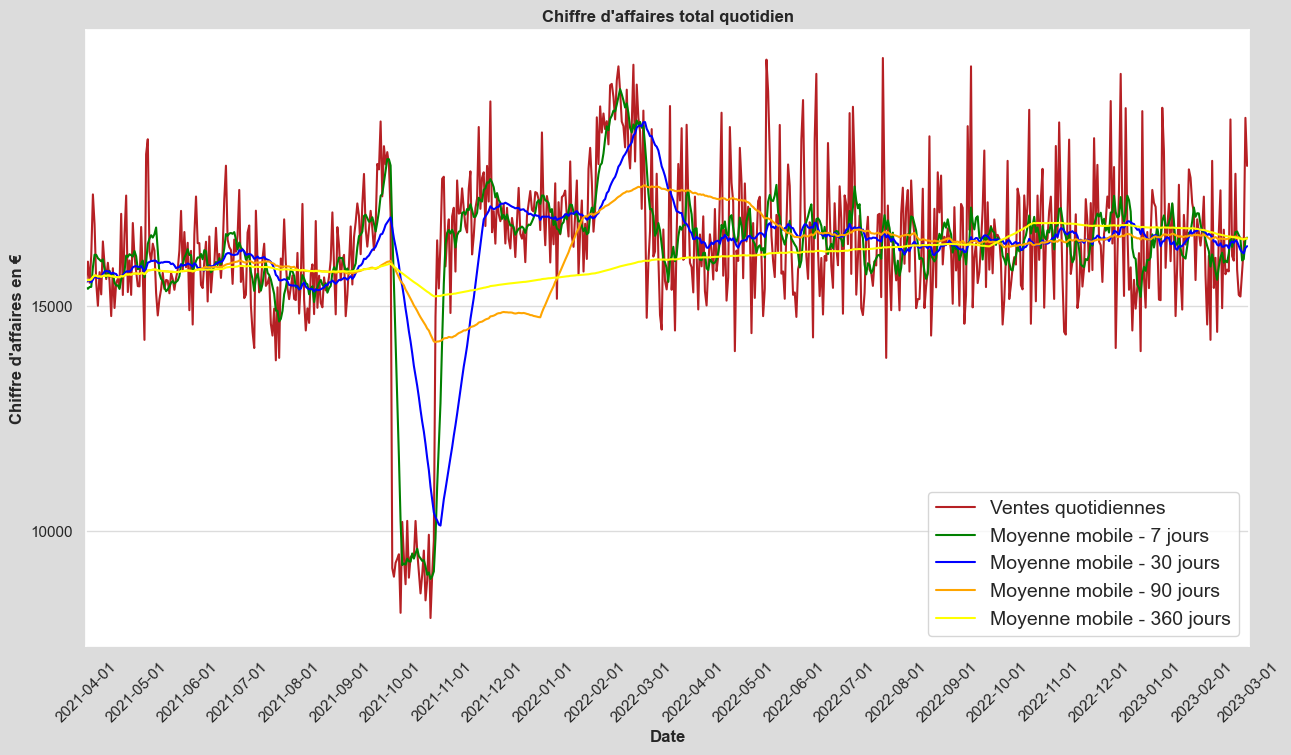

In [80]:
# plot total daily turnover
sns.set(rc={'figure.figsize':(15,8),'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})
graph9 = sns.lineplot(data=daily_CA, x='date_only_sales', y='daily_CA',color=col)
graph9.set_title("Chiffre d'affaires total quotidien", fontname = 'Arial',fontsize = 12,fontweight = 'bold')
plt.xticks(['2021-04', '2021-05', '2021-06', '2021-07', '2021-08', '2021-09', '2021-10', '2021-11', '2021-12',
            '2022-01', '2022-02', '2022-03', '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09', '2022-10', '2022-11', '2022-12',
            '2023-01', '2023-02', '2023-03'], rotation=45)
plt.yticks([0,5000,10000,15000])
plt.xlim([dt.date(2021, 4, 1), dt.date(2023, 3, 1)])
plt.xlabel('Date', fontweight='bold', fontsize='12')
plt.ylabel("Chiffre d'affaires en €", fontweight='bold', fontsize='12')
plt.grid(axis='y', color='gainsboro')
plt.plot(daily_CA['date_only_sales'],daily_CA['SMA_weekly'],color = 'green')
plt.plot(daily_CA['date_only_sales'],daily_CA['SMA_monthly'],color = 'blue')
plt.plot(daily_CA['date_only_sales'],daily_CA['SMA_quarterly'],color = 'orange')
plt.plot(daily_CA['date_only_sales'],daily_CA['SMA_yearly'],color = 'yellow')
plt.legend(labels=['Ventes quotidiennes','Moyenne mobile - 7 jours', 'Moyenne mobile - 30 jours','Moyenne mobile - 90 jours',
                    'Moyenne mobile - 360 jours'], fontsize=14)
plt.savefig("graph9.png",bbox_inches='tight')

In [81]:
# calculate total monthly turnover
monthly_CA = CA.groupby(['year_only_sales', 'month_only_sales'])['price_books'].sum().reset_index()
monthly_CA.rename(columns={'price_books': 'monthly_CA'}, inplace=True)

In [82]:
# calculate daily turnover by product category
daily_cat_CA = CA.groupby(['date_only_sales', 'category_books'])['price_books'].sum().reset_index()
daily_cat_CA.rename(columns={'price_books': 'daily_cat_CA'}, inplace=True)

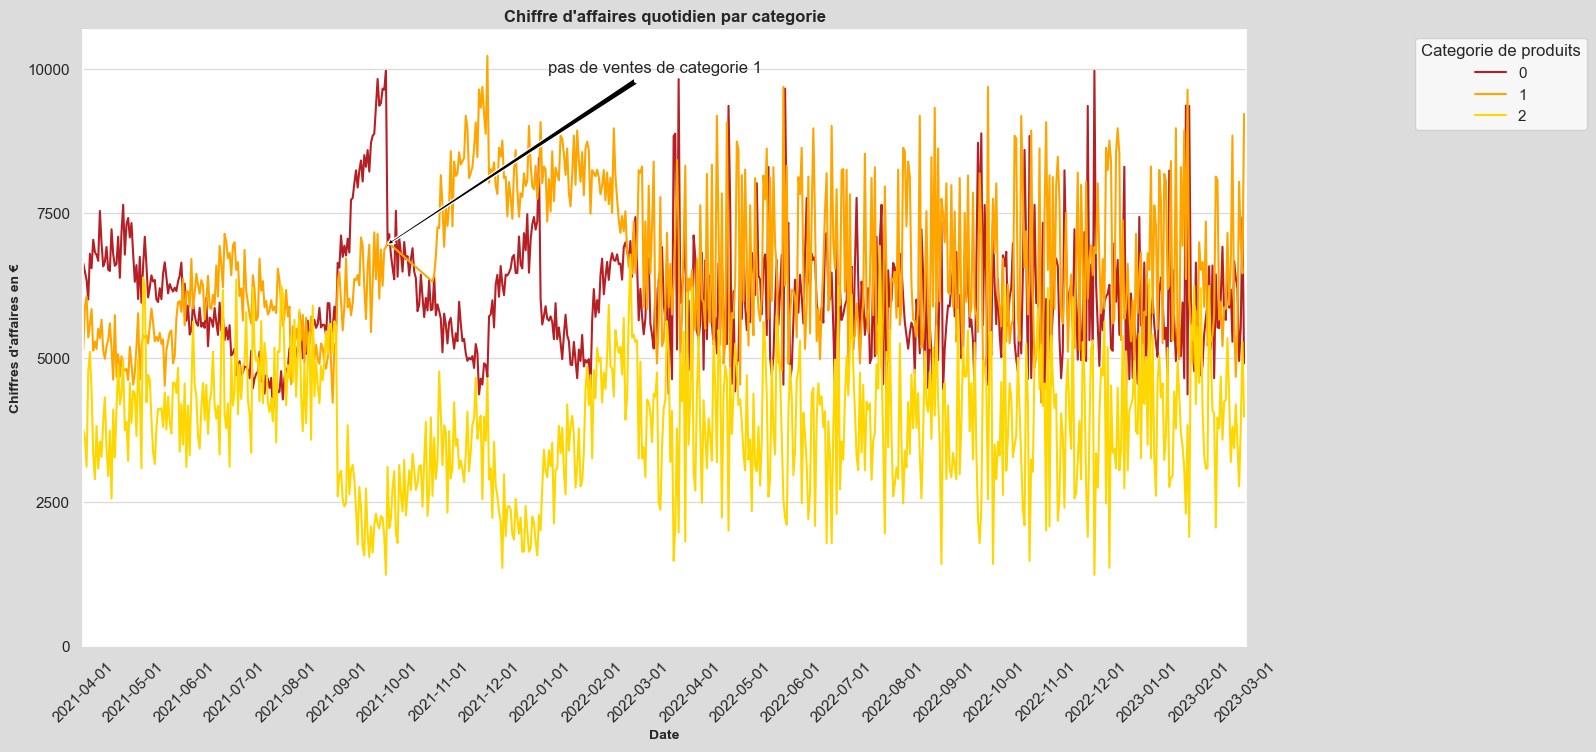

In [83]:
# plot daily turnover by product category
sns.set(rc={'figure.figsize':(15,8),'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})
graph10 = sns.lineplot(data=daily_cat_CA, x='date_only_sales', y='daily_cat_CA',hue='category_books',
                      palette=[col, 'orange', 'gold'])
graph10.set_title("Chiffre d'affaires quotidien par categorie", fontname = 'Arial',fontsize = 12,fontweight = 'bold')
plt.xlabel('Date',fontweight = 'bold' ,fontsize = 10)
sns.move_legend(graph10, "upper right", bbox_to_anchor=(1.3, 1), title='Categorie de produits')
plt.ylabel("Chiffres d'affaires en €",fontweight = 'bold',fontsize = 10)
plt.xticks(['2021-04', '2021-05', '2021-06', '2021-07', '2021-08', '2021-09', '2021-10', '2021-11', '2021-12',
            '2022-01', '2022-02', '2022-03', '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09', '2022-10',
            '2022-11', '2022-12', '2023-01', '2023-02', '2023-03'], rotation=45)
plt.xlim([dt.date(2021, 4, 1), dt.date(2023, 3, 1)])
plt.yticks([0,2500,5000,7500,10000])
plt.grid(axis='y', color='gainsboro')

# annotate drop in sales
graph10.annotate('pas de ventes de categorie 1',xy=(0.26,0.65),xycoords='axes fraction',xytext=(0.40,.95),
            textcoords='axes fraction',va='top',ha='left',arrowprops=dict(facecolor='black', arrowstyle='fancy'))

plt.savefig("graph10.png", bbox_inches='tight')
plt.show()

#### Ici encore on observe (graphiquement) que, comme mentionne plus haut dans l'etude des outliers sur le nombre de transactions journalieres par categorie, les ventes des produits de categories 0 et 2 semblent negativement correlees. Nous tenterons de verifier numeriquement cette hypothese plus loin. On note egalement l'absence de ventes de produits de categorie 1 en octobre 2021.

##### 3.1.1.2 - Chiffre d'affaires categorie 0

In [84]:
# create data for daily & moving averages graphs for category 0
daily_cat_CA_0 = daily_cat_CA.loc[daily_cat_CA['category_books'] == '0'].copy()

daily_cat_CA_0['SMA_weekly'] = daily_cat_CA_0['daily_cat_CA'].rolling(7, min_periods=1).mean()
daily_cat_CA_0['SMA_monthly'] = daily_cat_CA_0['daily_cat_CA'].rolling(30, min_periods=1).mean()
daily_cat_CA_0['SMA_quarterly'] = daily_cat_CA_0['daily_cat_CA'].rolling(90, min_periods=1).mean()
daily_cat_CA_0['SMA_yearly'] = daily_cat_CA_0['daily_cat_CA'].rolling(360, min_periods=1).mean()

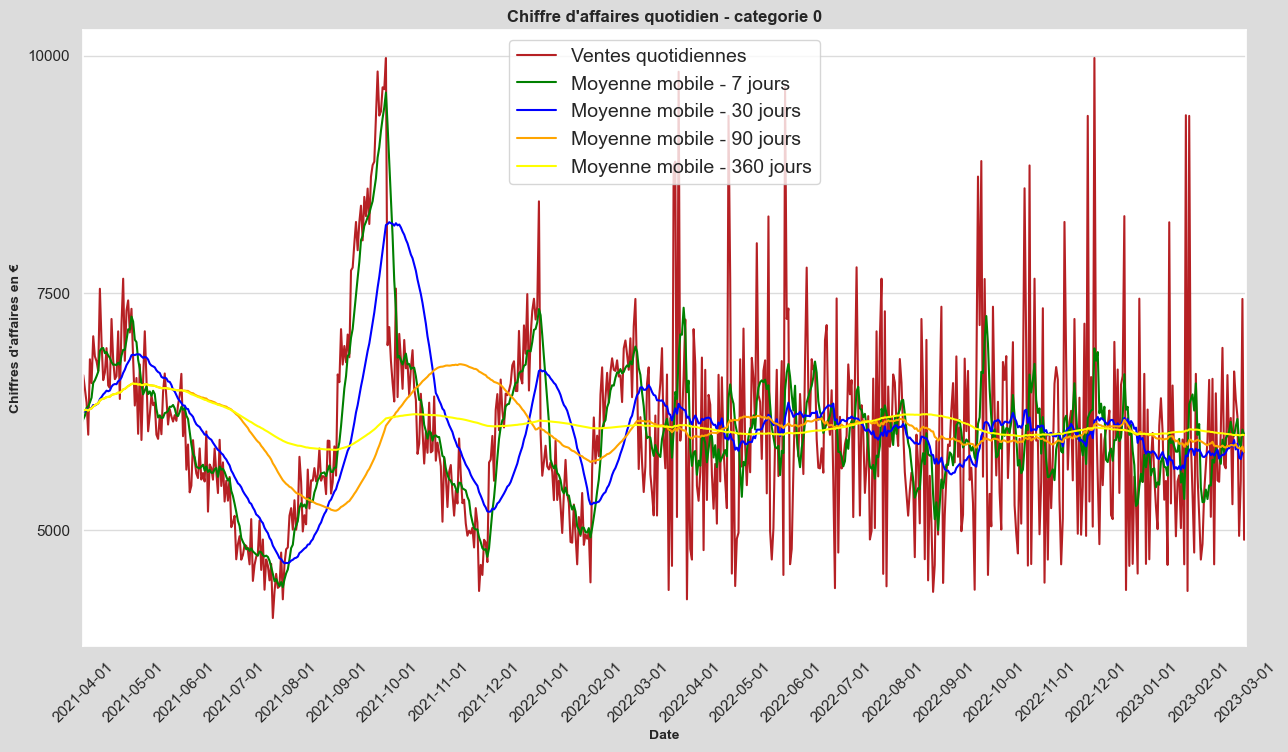

In [85]:
# plot daily turnover for product category 0
sns.set(rc={'figure.figsize':(15,8),'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})
graph11 = sns.lineplot(data=daily_cat_CA_0, x='date_only_sales', y='daily_cat_CA', color=col)
graph11.set_title("Chiffre d'affaires quotidien - categorie 0", fontname = 'Arial',fontsize = 12,fontweight = 'bold')
plt.xlabel('Date',fontweight = 'bold' ,fontsize = 10)
plt.ylabel("Chiffres d'affaires en €",fontweight = 'bold',fontsize = 10)
plt.xticks(['2021-04', '2021-05', '2021-06', '2021-07', '2021-08', '2021-09', '2021-10', '2021-11', '2021-12',
            '2022-01', '2022-02', '2022-03', '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09', '2022-10',
            '2022-11', '2022-12', '2023-01', '2023-02', '2023-03'], rotation=45)
plt.xlim([dt.date(2021, 4, 1), dt.date(2023, 3, 1)])
plt.yticks([0,2500,5000,7500,10000])
plt.grid(axis = 'y')
plt.grid(axis = 'y', color='gainsboro')
plt.plot(daily_cat_CA_0['date_only_sales'],daily_cat_CA_0['SMA_weekly'], color = 'green')
plt.plot(daily_cat_CA_0['date_only_sales'],daily_cat_CA_0['SMA_monthly'], color = 'blue')
plt.plot(daily_cat_CA_0['date_only_sales'],daily_cat_CA_0['SMA_quarterly'], color = 'orange')
plt.plot(daily_cat_CA_0['date_only_sales'],daily_cat_CA_0['SMA_yearly'], color = 'yellow')
plt.legend(labels=['Ventes quotidiennes','Moyenne mobile - 7 jours', 'Moyenne mobile - 30 jours','Moyenne mobile - 90 jours',
                    'Moyenne mobile - 360 jours'], fontsize=14)
plt.savefig("graph11.png", bbox_inches='tight')
plt.show()

##### 3.1.1.3 - Chiffre d'affaires categorie 1

In [86]:
# create data for daily & moving averages graphs for category 1
daily_cat_CA_1 = daily_cat_CA.loc[daily_cat_CA['category_books'] == '1'].copy()

daily_cat_CA_1['SMA_weekly'] = daily_cat_CA_1['daily_cat_CA'].rolling(7, min_periods=1).mean()
daily_cat_CA_1['SMA_monthly'] = daily_cat_CA_1['daily_cat_CA'].rolling(30, min_periods=1).mean()
daily_cat_CA_1['SMA_quarterly'] = daily_cat_CA_1['daily_cat_CA'].rolling(90, min_periods=1).mean()
daily_cat_CA_1['SMA_yearly'] = daily_cat_CA_1['daily_cat_CA'].rolling(360, min_periods=1).mean()

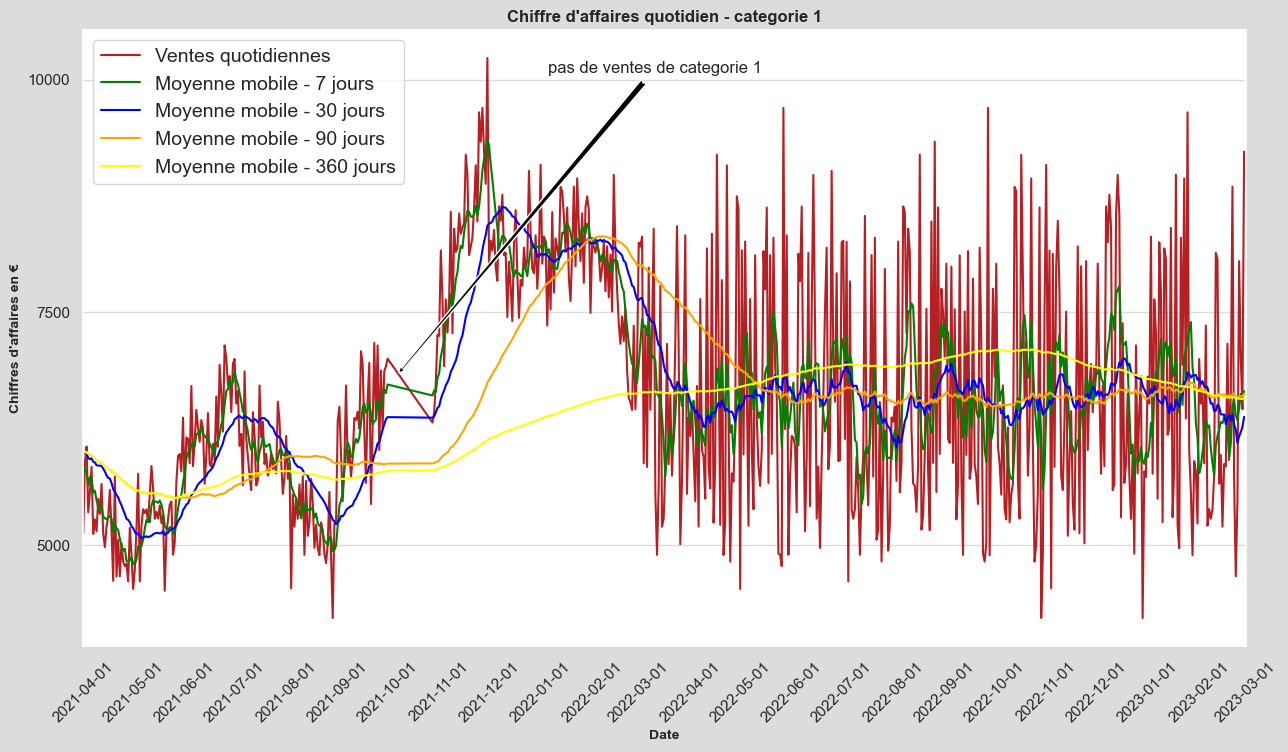

In [87]:
# plot daily turnover for product category 1
sns.set(rc={'figure.figsize':(15,8),'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})
graph12 = sns.lineplot(data=daily_cat_CA_1, x='date_only_sales', y='daily_cat_CA', color=col)
graph12.set_title("Chiffre d'affaires quotidien - categorie 1", fontname = 'Arial', fontsize = 12, fontweight = 'bold')
plt.xlabel('Date',fontweight = 'bold' ,fontsize = 10)
plt.ylabel("Chiffres d'affaires en €",fontweight = 'bold',fontsize = 10)
plt.xticks(['2021-04', '2021-05', '2021-06', '2021-07', '2021-08', '2021-09', '2021-10', '2021-11', '2021-12',
            '2022-01', '2022-02', '2022-03', '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09', '2022-10',
            '2022-11', '2022-12', '2023-01', '2023-02', '2023-03'], rotation=45)
plt.xlim([dt.date(2021, 4, 1), dt.date(2023, 3, 1)])
plt.yticks([0,2500,5000,7500,10000])
plt.grid(axis = 'y')
plt.grid(axis = 'y', color='gainsboro')
plt.plot(daily_cat_CA_1['date_only_sales'],daily_cat_CA_1['SMA_weekly'], color = 'green')
plt.plot(daily_cat_CA_1['date_only_sales'],daily_cat_CA_1['SMA_monthly'], color = 'blue')
plt.plot(daily_cat_CA_1['date_only_sales'],daily_cat_CA_1['SMA_quarterly'], color = 'orange')
plt.plot(daily_cat_CA_1['date_only_sales'],daily_cat_CA_1['SMA_yearly'], color = 'yellow')
plt.legend(labels=['Ventes quotidiennes','Moyenne mobile - 7 jours', 'Moyenne mobile - 30 jours','Moyenne mobile - 90 jours',
                    'Moyenne mobile - 360 jours'], fontsize=14)

# annotate drop in sales
graph12.annotate('pas de ventes de categorie 1',xy=(0.27,0.44),xycoords='axes fraction',xytext=(0.40,.95),
            textcoords='axes fraction',va='top',ha='left',arrowprops=dict(facecolor='black', arrowstyle='fancy'))

plt.savefig("graph12.png", bbox_inches='tight')
plt.show()

#### Ici encore on note un "saut" dans les donnees (aucune vente de produits de categorie 1 n'a ete realisee la plupart des jours d'octobre 2021).

##### 3.1.1.4 - Chiffre d'affaires categorie 2

In [88]:
# create data for daily & moving averages graphs for category 2
daily_cat_CA_2 = daily_cat_CA.loc[daily_cat_CA['category_books'] == '2'].copy()
daily_cat_CA_2['SMA_weekly'] = daily_cat_CA_2['daily_cat_CA'].rolling(7, min_periods=1).mean()
daily_cat_CA_2['SMA_monthly'] = daily_cat_CA_2['daily_cat_CA'].rolling(30, min_periods=1).mean()
daily_cat_CA_2['SMA_quarterly'] = daily_cat_CA_2['daily_cat_CA'].rolling(90, min_periods=1).mean()
daily_cat_CA_2['SMA_yearly'] = daily_cat_CA_2['daily_cat_CA'].rolling(360, min_periods=1).mean()

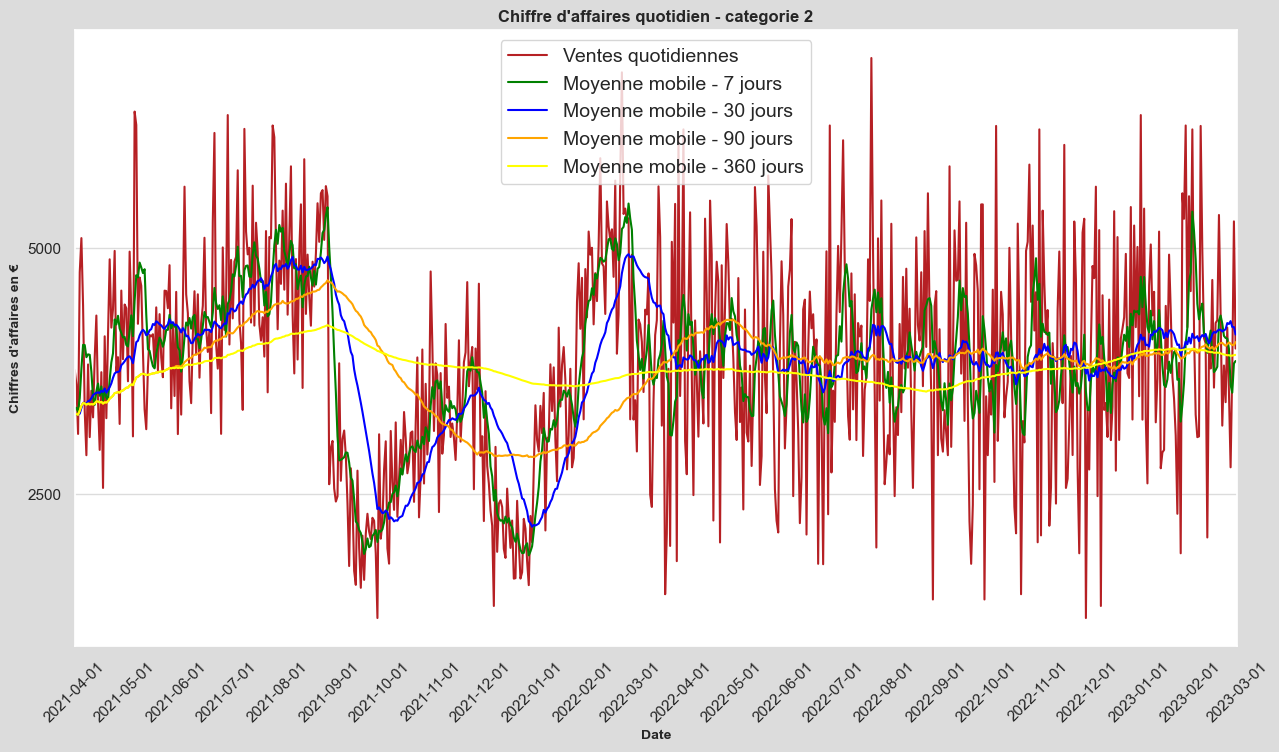

In [89]:
# plot daily turnover for product category 2
sns.set(rc={'figure.figsize':(15,8),'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})
graph13 = sns.lineplot(data=daily_cat_CA_2, x='date_only_sales', y='daily_cat_CA', color=col)
graph13.set_title("Chiffre d'affaires quotidien - categorie 2", fontname = 'Arial', fontsize = 12, fontweight = 'bold')
plt.xlabel('Date', fontweight = 'bold' , fontsize = 10)
plt.ylabel("Chiffres d'affaires en €",fontweight = 'bold',fontsize = 10)
plt.xticks(['2021-04', '2021-05', '2021-06', '2021-07', '2021-08', '2021-09', '2021-10', '2021-11', '2021-12',
            '2022-01', '2022-02', '2022-03', '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09', '2022-10',
            '2022-11', '2022-12', '2023-01', '2023-02', '2023-03'], rotation=45)
plt.xlim([dt.date(2021, 4, 1), dt.date(2023, 3, 1)])
plt.yticks([0,2500,5000,7500])
plt.grid(axis = 'y', color='gainsboro')
plt.plot(daily_cat_CA_2['date_only_sales'],daily_cat_CA_2['SMA_weekly'], color = 'green')
plt.plot(daily_cat_CA_2['date_only_sales'],daily_cat_CA_2['SMA_monthly'], color = 'blue')
plt.plot(daily_cat_CA_2['date_only_sales'],daily_cat_CA_2['SMA_quarterly'], color = 'orange')
plt.plot(daily_cat_CA_2['date_only_sales'],daily_cat_CA_2['SMA_yearly'], color = 'yellow')
plt.legend(labels=['Ventes quotidiennes','Moyenne mobile - 7 jours', 'Moyenne mobile - 30 jours','Moyenne mobile - 90 jours',
                    'Moyenne mobile - 360 jours'], fontsize=14)
plt.savefig("graph13.png", bbox_inches='tight')
plt.show()

#### Aucun des graphiques de chiffre d'affaire quotidien (global ou par produit) ni des moyennes glissantes ne permet de deceler une saisonnalite dans les ventes. Un historique plus long serait necessaire pour rendre cette analyse plus pertinente.

### 3.1.2 - Analyse des produits

In [90]:
# create data for analysis
CA_val = CA.groupby(['product_id_sales', 'category_books']).agg({'price_books' : ['sum'], 'session_id_sales' : ['count']}
                                                              ).reset_index()
CA_val.rename(columns={'price_books': 'CA_total', 'session_id_sales':'nb_sold'}, inplace=True)
CA_val_LG = CA_val[['product_id_sales', 'CA_total']].copy()

# calculate total turnover for all products
CA_tot_LG = CA_val_LG['CA_total'].sum()

# calculate number of unique products
nb_prod_LG = len(CA_val_LG['product_id_sales'].unique())

In [91]:
# create data for Lorenz curve graph
CA_val_LG.sort_values(("CA_total", "sum"), inplace=True, ascending=True)
CA_val_LG['CA_total_cum'] = np.cumsum(CA_val_LG['CA_total'])
CA_val_LG['lorenz_value'] = CA_val_LG['CA_total_cum'] / CA_tot_LG[0]
CA_val_LG['product_count'] = np.arange(CA_val_LG.shape[0])+1
CA_val_LG['product_base_1'] = CA_val_LG['product_count']/nb_prod_LG

In [92]:
# create data for 80-20 dotted line plot
# 80% du CA cumule
CA_val_LG_sort80 = CA_val_LG.iloc[(CA_val_LG['lorenz_value']-0.8).abs().argsort()[:1]]

# for values
lorenz80 = CA_val_LG_sort80['lorenz_value'].tolist()[0]

# for index
index80 = CA_val_LG_sort80.index.tolist()[0]

# % produits correspondants a 80% du CA cumule
product80 = CA_val_LG.loc[index80, 'product_base_1'].values[0]

# 20% du CA cumule
CA_val_LG_sort20 = CA_val_LG.iloc[(CA_val_LG['lorenz_value']-0.2).abs().argsort()[:1]]

# for values
lorenz20 = CA_val_LG_sort20['lorenz_value'].tolist()[0]

# for index
index20 = CA_val_LG_sort20.index.tolist()[0]

# % produits correspondants a 20% du CA cumule
product20 = CA_val_LG.loc[index20, 'product_base_1'].values[0]
print('lorenz80 = ', lorenz80, '\nindex80 = ', index80, '\nproduct80 = ', product80, '\nlorenz20 = ',
      lorenz20, '\nindex20 = ', index20, '\nproduct20 = ', product20)


# create data for medial
# 50% du CA cumule
CA_val_LG_sort50 = CA_val_LG.iloc[(CA_val_LG['lorenz_value']-0.5).abs().argsort()[:1]]

# for values
lorenz50 = CA_val_LG_sort50['lorenz_value'].tolist()[0]

# for index
index50 = CA_val_LG_sort50.index.tolist()[0]

# % produits correspondants a 80% du CA cumule
product50 = CA_val_LG.loc[index50, 'product_base_1'].values[0]

print("Chiffre d'affaires medial atteint avec", round(product50*100, 2), "% des produits.")

lorenz80 =  0.8011813873899248 
index80 =  2627 
product80 =  0.9834660134721371 
lorenz20 =  0.20013946007836367 
index20 =  2292 
product20 =  0.7850581751377832
Chiffre d'affaires medial atteint avec 92.9 % des produits.


In [93]:
# calculate area under Lorenz curve
area3 = CA_val_LG['lorenz_value'].sum() / nb_prod_LG

# calculate Gini coefficient
S3 = (0.5 - area3)
gini3 = S3 * 2
print('Coefficient de Gini:',round(gini3,4))

Coefficient de Gini: 0.7425


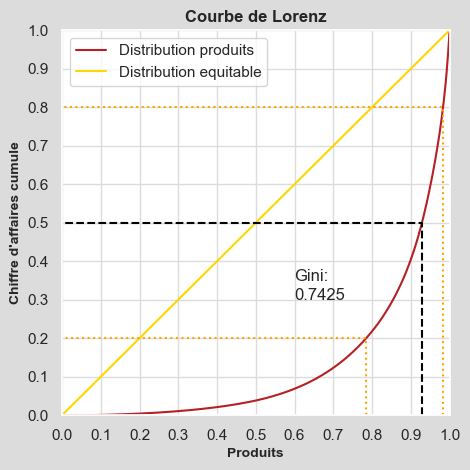

In [94]:
# plot Lorenz curve
sns.set(rc={'figure.figsize':(5,5),'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})
graph14 = sns.lineplot(data=CA_val_LG, x='product_base_1', y='lorenz_value', color=col, label='Distribution produits')
graph14.set_title("Courbe de Lorenz", fontname = 'Arial', fontsize = 12, fontweight = 'bold')
plt.xlabel('Produits', fontweight = 'bold', fontsize = 10)
plt.ylabel("Chiffre d'affaires cumule", fontweight = 'bold', fontsize = 10)
plt.xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], rotation=0)
plt.xlim([0, 1])
plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
plt.ylim([0, 1])
plt.grid(axis='both', color='gainsboro')
plt.savefig("graph22.png", bbox_inches='tight')

#adding text inside the plot
plt.text(0.60, 0.35, 'Gini:', fontsize=12)
plt.text(0.60, 0.30, round(gini3,4), fontsize=12)

# plot first bisector
origin3 = [0, 0]
limit3 = [1, 1]
x_values = [origin3[0], limit3[0]]
y_values = [origin3[1], limit3[1]]
plt.plot(x_values, y_values, 'gold', label='Distribution equitable')
plt.legend(loc="upper left")

# plot 20-80 lines for readability
x_20 = [product20, product20, 0]
y_20 = [0, lorenz20, lorenz20]
plt.plot(x_20, y_20, linestyle='dotted', color='orange')
x_80 = [product80, product80, 0]
y_80 = [0, lorenz80, lorenz80]
plt.plot(x_80, y_80, linestyle='dotted', color='orange')

# plot mediale
x_50 = [product50, product50, 0]
y_50 = [0, lorenz50, lorenz50]
plt.plot(x_50, y_50, linestyle='dashed', color='black')

#save to file
plt.savefig("graph14.png", bbox_inches='tight')

# function to show the plot
plt.show()

#### L'indice de Gini est tres eleve (0.74), ce qui revele une distribution tres inegalitaire du chiffre d'affaires sur notre gamme de produits. 80% des produits vendus ne nous permettent de realiser qu'un peu plus de 20% de notre chiffre d'affaires et ils faut plus de 90% des produits vendus pour atteindre le CA medial.

In [95]:
CA_trim = CA[['product_id_books', 'price_books', 'category_books']]
CA_trim_all = pd.concat([CA_trim, not_sold], axis=0)
CA_val_pie = CA_trim.groupby('category_books').agg({'product_id_books' : ['count','nunique'] ,'price_books' : ['sum','mean']}
                                                              ).reset_index()
CA_val_pie_all = CA_trim_all.groupby('category_books').agg({'product_id_books' : ['count','nunique'] ,
                                                            'price_books' : ['sum','mean']}).reset_index()

CA_val_pie_all.rename(columns={'count':'produits vendus', 'nunique': 'nb de refs', 'sum':'CA total',
                               'mean':'prix moyen'}, inplace=True)
CA_val_pie_all.droplevel(0, axis='columns')
CA_val_pie_all.droplevel(1, axis='columns')

category_books  product_id_books  product_id_books  price_books  price_books
0              0            415696              2309   4422240.75    10.638160
1              1            227171               739   4653794.24    20.485864
2              2             36486               239   2780769.69    76.214704

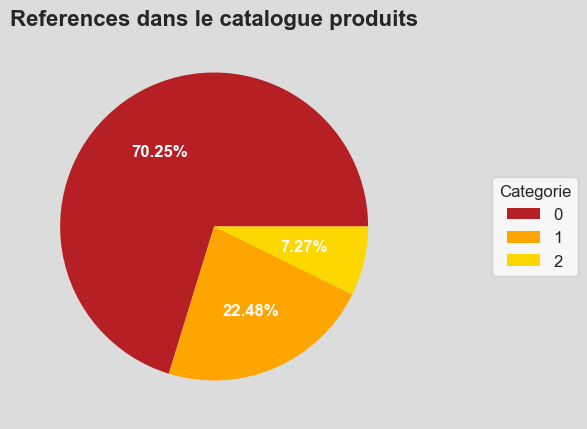

In [96]:
# pie plot references
fig, ax = plt.subplots(figsize=(5, 5))
fig.set_facecolor('gainsboro')
graph15 = plt.pie(CA_val_pie_all[("product_id_books", "nb de refs")], autopct='%1.2f%%', pctdistance=0.6, radius=1,
                   colors=(col, 'orange', 'gold'), textprops={'fontsize': 12, 'color':'white', 'fontweight':'bold'},
                   wedgeprops={'alpha':1, 'linewidth': 0})
ax.legend(CA_val_pie_all["category_books"], title="Categorie", loc="center left", bbox_to_anchor=(1.2, 0, 0.5, 1),
          fontsize=12)
ax.set_title("References dans le catalogue produits", loc="center", fontsize=16, fontweight='bold')
plt.savefig("graph15.png", bbox_inches='tight')
plt.show()

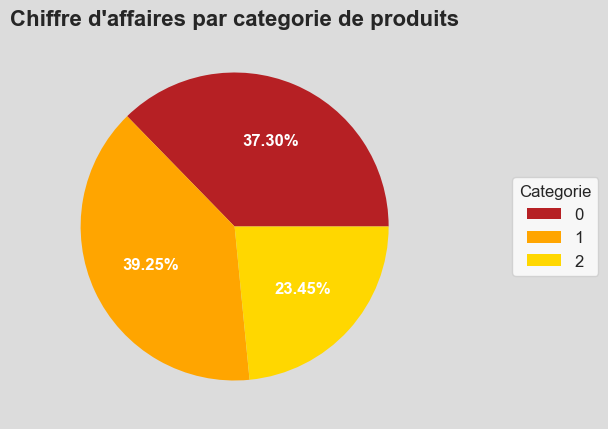

In [97]:
# pie plot turnover
fig, ax = plt.subplots(figsize=(5, 5))
fig.set_facecolor('gainsboro')
graph16 = plt.pie(CA_val_pie_all[("price_books", "CA total")], autopct='%1.2f%%', pctdistance=0.6, radius=1,
                   colors=(col, 'orange', 'gold'), textprops={'fontsize': 12, 'color':'white', 'fontweight':'bold'},
                   wedgeprops={'alpha':1, 'linewidth': 0})
ax.legend(CA_val_pie_all["category_books"], title="Categorie", loc="center left", bbox_to_anchor=(1.2, 0, 0.5, 1),
          fontsize=12)
ax.set_title("Chiffre d'affaires par categorie de produits", loc="center", fontsize=16, fontweight='bold')
plt.savefig("graph16.png", bbox_inches='tight')
plt.show()

#### Ce qui confirme la repartition inegalitaire du CA par categorie: les produits de cat 0 representent plus de 70% de notre catalogue mais a peine plus de 37% du CA.

#### 3.1.2.1 - Analyse en valeur (CA)

In [98]:
# find top and bottom 10 products by value (turnover)
CA_val.sort_values(("CA_total", "sum"), inplace=True, ascending=False)
x = 10
print(CA_val.head(x).to_csv("top_CA_prod_val.csv", index=False))
print("Les", x, "produits pour lesquels le CA total est le plus eleve en valeur sont:\n")
CA_val.head(x)

None
Les 10 produits pour lesquels le CA total est le plus eleve en valeur sont:



product_id_sales category_books  CA_total nb_sold
                                           sum   count
3097            2_159              2  94893.50     650
3071            2_135              2  69334.95    1005
3046            2_112              2  65407.76     968
3035            2_102              2  60736.78    1027
3153            2_209              2  56971.86     814
2620            1_395              1  54356.25    1875
2592            1_369              1  54025.48    2252
3044            2_110              2  53846.25     865
3202             2_39              2  53060.85     915
3105            2_166              2  52449.12     228

In [99]:
print(CA_val.tail(x).to_csv("bottom_CA_prod_val.csv", index=False))
print("Les", x, "produits pour lesquels le CA total est le plus faible en valeur sont:\n")
CA_val.tail(x)

None
Les 10 produits pour lesquels le CA total est le plus faible en valeur sont:



product_id_sales category_books CA_total nb_sold
                                          sum   count
925            0_1840              0     2.56       2
2180            0_898              0     2.54       2
549            0_1498              0     2.48       1
802            0_1728              0     2.27       1
1785            0_541              0     1.99       1
665            0_1601              0     1.99       1
2080            0_807              0     1.99       1
719            0_1653              0     1.98       2
313            0_1284              0     1.38       1
595            0_1539              0     0.99       1

In [100]:
CA_val_cat0 = CA_val.loc[(CA_val['category_books'] == '0')].copy()
CA_val_cat0.sort_values(("CA_total", "sum"), inplace=True, ascending=False)
print(CA_val_cat0.head(x).to_csv("tableau1c.csv", index=False))
print("Les", x, "produits de categorie 0 pour lesquels le CA total est le plus eleve en valeur sont:\n")
CA_val_cat0.head(x)

None
Les 10 produits de categorie 0 pour lesquels le CA total est le plus eleve en valeur sont:



product_id_sales category_books  CA_total nb_sold
                                          sum   count
487           0_1441              0  23452.65    1235
465           0_1421              0  23008.49    1151
457           0_1414              0  22287.00    1150
498           0_1451              0  21689.15    1085
460           0_1417              0  21372.12    1188
494           0_1448              0  20701.42    1093
519           0_1470              0  20194.02    1034
475           0_1430              0  20109.87    1221
389           0_1353              0  19430.28     972
391           0_1355              0  19312.83    1017

In [101]:
print(CA_val_cat0.tail(x).to_csv("tableau1d.csv", index=False))
print("Les", x, "produits de categorie 0 pour lesquels le CA total est le plus faible en valeur sont:\n")
CA_val_cat0.tail(x)

None
Les 10 produits de categorie 0 pour lesquels le CA total est le plus faible en valeur sont:



product_id_sales category_books CA_total nb_sold
                                          sum   count
925            0_1840              0     2.56       2
2180            0_898              0     2.54       2
549            0_1498              0     2.48       1
802            0_1728              0     2.27       1
1785            0_541              0     1.99       1
665            0_1601              0     1.99       1
2080            0_807              0     1.99       1
719            0_1653              0     1.98       2
313            0_1284              0     1.38       1
595            0_1539              0     0.99       1

In [102]:
CA_val_cat1 = CA_val.loc[(CA_val['category_books'] == '1')].copy()
CA_val_cat1.sort_values(("CA_total", "sum"), inplace=True, ascending=False)
print(CA_val_cat1.head(x).to_csv("tableau1e.csv", index=False))
print("Les", x, "produits de categorie 1 pour lesquels le CA total est le plus eleve en valeur sont:\n")
CA_val_cat1.head(x)

None
Les 10 produits de categorie 1 pour lesquels le CA total est le plus eleve en valeur sont:



product_id_sales category_books  CA_total nb_sold
                                           sum   count
2620            1_395              1  54356.25    1875
2592            1_369              1  54025.48    2252
2642            1_414              1  51949.40    2180
2608            1_383              1  51486.24    1776
2734            1_498              1  49731.36    2128
2633            1_406              1  48106.59    1939
2589            1_366              1  47005.38    1647
2610            1_385              1  46730.02    1798
2661            1_431              1  46575.36    1664
2603            1_379              1  46098.92    1708

In [103]:
print(CA_val_cat1.tail(x).to_csv("tableau1f.csv", index=False))
print("Les", x, "produits de categorie 1 pour lesquels le CA total est le plus faible en valeur sont:\n")
CA_val_cat1.tail(x)

None
Les 10 produits de categorie 1 pour lesquels le CA total est le plus faible en valeur sont:



product_id_sales category_books CA_total nb_sold
                                          sum   count
2653            1_424              1    49.10      10
2668            1_438              1    47.16       9
2750            1_511              1    44.85      15
2624            1_399              1    43.89      11
2333            1_135              1    39.95       5
2631            1_404              1    29.55       3
2707            1_473              1    26.91       9
2704            1_470              1    21.64       4
2432            1_224              1    19.80       4
2649            1_420              1    14.24       2

In [104]:
CA_val_cat2 = CA_val.loc[(CA_val['category_books'] == '2')].copy()
CA_val_cat2.sort_values(("CA_total", "sum"), inplace=True, ascending=False)
print(CA_val_cat2.head(x).to_csv("tableau1g.csv", index=False))
print("Les", x, "produits de categorie 2 pour lesquels le CA total est le plus eleve en valeur sont:\n")
CA_val_cat2.head(x)

None
Les 10 produits de categorie 2 pour lesquels le CA total est le plus eleve en valeur sont:



product_id_sales category_books  CA_total nb_sold
                                           sum   count
3097            2_159              2  94893.50     650
3071            2_135              2  69334.95    1005
3046            2_112              2  65407.76     968
3035            2_102              2  60736.78    1027
3153            2_209              2  56971.86     814
3044            2_110              2  53846.25     865
3202             2_39              2  53060.85     915
3105            2_166              2  52449.12     228
3207             2_43              2  49972.86     714
3146            2_202              2  46217.88     684

In [105]:
print(CA_val_cat2.tail(x).to_csv("tableau1h.csv", index=False))
print("Les", x, "produits de categorie 2 pour lesquels le CA total est le plus faible en valeur sont:\n")
CA_val_cat2.tail(x)

None
Les 10 produits de categorie 2 pour lesquels le CA total est le plus faible en valeur sont:



product_id_sales category_books CA_total nb_sold
                                          sum   count
3067            2_131              2   383.97       3
3057            2_122              2   350.00       5
3190             2_28              2   310.50       3
3189             2_27              2   295.96       4
3243             2_77              2   291.98       2
3040            2_107              2   203.94       6
3259             2_93              2   157.98       2
3264             2_98              2   149.74       1
3176             2_23              2   115.99       1
3248             2_81              2    86.99       1

#### 3.1.2.2 - Analyse en volume (unites vendues)

In [106]:
# list of products never sold (from part 1 analysis)
not_sold

product_id_books  price_books category_books
184            0_1016        35.06              0
279            0_1780         1.67              0
737            0_1062        20.08              0
794            0_1119         2.99              0
811            0_1014         1.15              0
846               1_0        31.82              1
1031           0_1318        20.92              0
1139           0_1800        22.05              0
1347           0_1645         2.99              0
1505            0_322         2.99              0
1530           0_1620         0.80              0
1543           0_1025        24.99              0
1709             2_87       220.99              2
1863            1_394        39.73              1
1946             2_72       141.32              2
2215            0_310         1.94              0
2408           0_1624        24.50              0
2525             2_86       132.36              2
2690            0_299        22.99              0
3031            0_510        23.66              0
3096           0_2308        20.28              0

In [107]:
not_sold.groupby('category_books')['product_id_books'].count().reset_index()

category_books  product_id_books
0              0                16
1              1                 2
2              2                 3

#### Les produits jamais vendus sont majoritairement de categorie 0.

In [108]:
CA_vol = CA.groupby(['product_id_sales', 'category_books']).agg({'price_books' : ['sum','mean'] ,
                                                                 'session_id_sales' : ['count']}).reset_index()
CA_vol.rename(columns={'price_books': 'CA_total', 'session_id_sales':'nb_sold'}, inplace=True)
CA_vol.sort_values(("nb_sold", "count"), inplace=True, ascending=False)
print(CA_vol.head(x).to_csv("top_CA_prod_vol.csv", index=False))
print("Les", x, "produits pour lesquels le CA total est le plus eleve en volume sont:\n")
CA_vol.head(x)

None
Les 10 produits pour lesquels le CA total est le plus eleve en volume sont:



product_id_sales category_books  CA_total        nb_sold
                                           sum   mean   count
2592            1_369              1  54025.48  23.99    2252
2645            1_417              1  45947.11  20.99    2189
2642            1_414              1  51949.40  23.83    2180
2734            1_498              1  49731.36  23.37    2128
2654            1_425              1  35611.04  16.99    2096
2630            1_403              1  35260.40  17.99    1960
2640            1_412              1  32484.15  16.65    1951
2641            1_413              1  34990.55  17.99    1945
2633            1_406              1  48106.59  24.81    1939
2634            1_407              1  30940.65  15.99    1935

In [109]:
print(CA_vol.tail(x).to_csv("bottom_CA_prod_vol.csv", index=False))
print("Les", x, "produits pour lesquels le CA total est le plus faible en volume sont:\n")
CA_vol.tail(x)

None
Les 10 produits pour lesquels le CA total est le plus faible en volume sont:



product_id_sales category_books CA_total        nb_sold
                                          sum   mean   count
1327           0_2201              0    20.99  20.99       1
166            0_1151              0     2.99   2.99       1
802            0_1728              0     2.27   2.27       1
3248             2_81              2    86.99  86.99       1
595            0_1539              0     0.99   0.99       1
313            0_1284              0     1.38   1.38       1
1793            0_549              0     2.99   2.99       1
549            0_1498              0     2.48   2.48       1
1785            0_541              0     1.99   1.99       1
2167            0_886              0    21.82  21.82       1

In [110]:
CA_unit = CA.groupby('product_id_sales')['product_id_books'].count().reset_index()
CA_unit.head()

product_id_sales  product_id_books
0              0_0              1242
1              0_1               487
2             0_10                22
3            0_100                 3
4           0_1000               432

In [111]:
print(len(CA_unit['product_id_sales']),"references produit uniques.")
CA_unit_sales = CA_unit.loc[CA_unit['product_id_books'] == 1]
print(CA_unit_sales.shape[0]," produits n'ont ete vendus qu'une seule fois.")
CA_unit_sales2 = CA_unit.loc[CA_unit['product_id_books'] < 24]
print(CA_unit_sales2.shape[0]," produits ont ete vendus moins de 24 fois.")

3266 references produit uniques.
18  produits n'ont ete vendus qu'une seule fois.
1066  produits ont ete vendus moins de 24 fois.


#### Pres de 33% des produits de notre catalogue se vendent tres peu (moins d'une fois par mois)

In [112]:
CA_vol_cat0 = CA_val.loc[(CA_val['category_books'] == '0')].copy()
CA_vol_cat0.sort_values(("nb_sold", "count"), inplace=True, ascending=False)
print(CA_vol_cat0.head(x).to_csv("tableau2c.csv", index=False))
print("Les", x, "produits de categorie 0 pour lesquels le CA total est le plus eleve en volume sont:\n")
CA_vol_cat0.head(x)

None
Les 10 produits de categorie 0 pour lesquels le CA total est le plus eleve en volume sont:



product_id_sales category_books  CA_total nb_sold
                                          sum   count
466           0_1422              0  14741.72    1292
476           0_1431              0  14089.18    1282
469           0_1425              0  16445.34    1266
477           0_1432              0  19261.44    1254
454           0_1411              0  11201.54    1246
472           0_1428              0   4419.75    1245
0                0_0              0   4657.50    1242
468           0_1424              0  10411.58    1238
487           0_1441              0  23452.65    1235
479           0_1434              0  10596.30    1235

In [113]:
print(CA_vol_cat0.tail(x).to_csv("tableau2d.csv", index=False))
print("Les", x, "produits de categorie 0 pour lesquels le CA total est le plus faible en volume sont:\n")
CA_vol_cat0.tail(x)

None
Les 10 produits de categorie 0 pour lesquels le CA total est le plus faible en volume sont:



product_id_sales category_books CA_total nb_sold
                                          sum   count
802            0_1728              0     2.27       1
2167            0_886              0    21.82       1
1327           0_2201              0    20.99       1
752            0_1683              0     2.99       1
698            0_1633              0    24.99       1
2109            0_833              0     2.99       1
166            0_1151              0     2.99       1
417            0_1379              0     2.99       1
1793            0_549              0     2.99       1
595            0_1539              0     0.99       1

In [114]:
CA_vol_cat1 = CA_val.loc[(CA_val['category_books'] == '1')].copy()
CA_vol_cat1.sort_values(("nb_sold", "count"), inplace=True, ascending=False)
print(CA_vol_cat1.head(x).to_csv("tableau2e.csv", index=False))
print("Les", x, "produits de categorie 1 pour lesquels le CA total est le plus eleve en volume sont:\n")
CA_vol_cat1.head(x)

None
Les 10 produits de categorie 1 pour lesquels le CA total est le plus eleve en volume sont:



product_id_sales category_books  CA_total nb_sold
                                           sum   count
2592            1_369              1  54025.48    2252
2645            1_417              1  45947.11    2189
2642            1_414              1  51949.40    2180
2734            1_498              1  49731.36    2128
2654            1_425              1  35611.04    2096
2630            1_403              1  35260.40    1960
2640            1_412              1  32484.15    1951
2641            1_413              1  34990.55    1945
2633            1_406              1  48106.59    1939
2634            1_407              1  30940.65    1935

In [115]:
print(CA_vol_cat1.tail(x).to_csv("tableau2f.csv", index=False))
print("Les", x, "produits de categorie 1 pour lesquels le CA total est le plus faible en volume sont:\n")
CA_vol_cat1.tail(x)

None
Les 10 produits de categorie 1 pour lesquels le CA total est le plus faible en volume sont:



product_id_sales category_books CA_total nb_sold
                                          sum   count
2720            1_485              1   151.96       4
2313            1_117              1   167.96       4
2453            1_243              1   171.96       4
2345            1_146              1    95.94       3
2635            1_408              1   105.72       3
2631            1_404              1    29.55       3
2636            1_409              1   167.97       3
2629            1_402              1    69.04       2
2753            1_514              1   135.32       2
2649            1_420              1    14.24       2

In [116]:
CA_vol_cat2 = CA_val.loc[(CA_val['category_books'] == '2')].copy()
CA_vol_cat2.sort_values(("nb_sold", "count"), inplace=True, ascending=False)
print(CA_vol_cat2.head(x).to_csv("tableau2g.csv", index=False))
print("Les", x, "produits de categorie 2 pour lesquels le CA total est le plus eleve en volume sont:\n")
CA_vol_cat2.head(x)

None
Les 10 produits de categorie 2 pour lesquels le CA total est le plus eleve en volume sont:



product_id_sales category_books  CA_total nb_sold
                                           sum   count
3035            2_102              2  60736.78    1027
3071            2_135              2  69334.95    1005
3046            2_112              2  65407.76     968
3202             2_39              2  53060.85     915
3200             2_37              2  43209.18     882
3044            2_110              2  53846.25     865
3152            2_208              2  45596.97     831
3153            2_209              2  56971.86     814
3151            2_207              2  40078.14     786
3042            2_109              2  40168.56     744

In [117]:
print(CA_vol_cat2.tail(x).to_csv("tableau2h.csv", index=False))
print("Les", x, "produits de categorie 2 pour lesquels le CA total est le plus faible en volume sont:\n")
CA_vol_cat2.tail(x)

None
Les 10 produits de categorie 2 pour lesquels le CA total est le plus faible en volume sont:



product_id_sales category_books CA_total nb_sold
                                          sum   count
3190             2_28              2   310.50       3
3066            2_130              2   427.74       3
3067            2_131              2   383.97       3
3232             2_66              2   452.16       3
3244             2_78              2   502.47       3
3243             2_77              2   291.98       2
3259             2_93              2   157.98       2
3264             2_98              2   149.74       1
3176             2_23              2   115.99       1
3248             2_81              2    86.99       1

#### Conclusion: Parmi les produits vendus, les 10 produits les moins vendus globalement (en valeur) sont tous de categorie 0, qui a le prix moyen le plus faible, et 9 produits les moins vendus en volume sur 10 sont aussi de categorie 0.
#### Parmi 21 produits jamais vendus, 16 sont de categorie 0.

### 3.1.3 - Analyse des profils client

#### 3.1.3.1 - Indicateurs demographiques

In [118]:
# create data for pie by genre
genre_pie = clients.groupby(['gender_clients'])['client_id_clients'].count().reset_index()

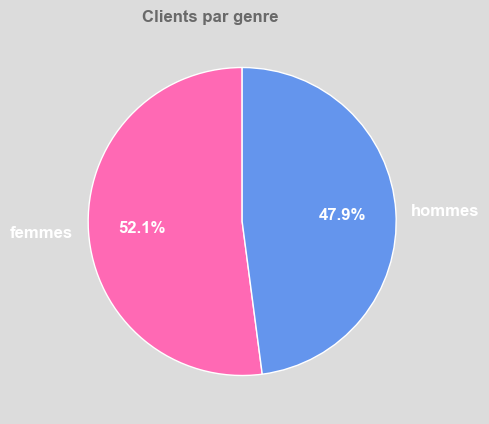

In [119]:
#plot pie by genre for buying clients

fig, ax = plt.subplots(figsize=(5,5))
fig.set_facecolor('gainsboro')

colors_GR17 = ['hotpink','cornflowerblue']

ax.pie(genre_pie['client_id_clients'], radius=1,
       colors=colors_GR17, labels=['femmes','hommes'],
       autopct=my_autopct, pctdistance=0.65, textprops={'fontsize': 12, 'color':'white','fontweight':'bold'}, startangle=90)

#adding title inside the plot
plt.text(-0.65, 1.3, "Clients par genre", fontsize=12, fontweight='bold', color='dimgray')

plt.savefig("graph17.png", bbox_inches='tight')
plt.show()

#### On veut tester si nos clients ont plus de probabilite d'etre des femmes que dans la population francaise au total (51.6% en 2019 d'apres les resultats detailles de l'INSEE publies le 27/06/2022 - https://www.insee.fr/fr/statistiques/4238375?sommaire=4238781). 
#### On pose H0 : les proportions de femmes sont egales dans nos clients et dans la population francaise (i.e. la probabilite que nos clients soient des femmes est de 51.6%)
#### On pose H1 : la probabilite que nos clients soient des femmes est > a 51.6%

In [120]:
# test if proportion of women in our clients > 0.516
nb_wom = genre_pie.iloc[0, 1]
pop_tot =  genre_pie.iloc[0, 1] + genre_pie.iloc[1, 1]
stat2, p2 = proportions_ztest(nb_wom, pop_tot, value=0.516, alternative='larger', prop_var=False)
print("Statistique de test Z:", round(stat2, 4))


print("p-value:", round(p2,4)) 

# comment trouver le p-value a partir de la statistique de test:
# cdf = cumulative density function vs pdf = probability density function
# p-value = 1 - st.norm(0,1).cdf(stat2)
# on lit dans la table N(0,1) la proba que notre statistique de test soit inferieure a 0.8960. On trouve p = 0.8133
# pour Z=0.89 et p=0.8159 pour Z=0.9. On interpole et on trouve p=0.8149 pour Z=0.8961, donc la p-value vaut
# 1-0.8149 = 0.1851

Statistique de test Z: 0.8961
p-value: 0.1851


#### La p-value vaut 18.51% : p-value > α, donc au seuil de risque donne α = 5%, nous n'avons pas suffisamment d'informations pour rejeter H0, donc la difference entre les proportions de femmes dans nos clients et dans la population francaise en general n'est pas statistiquement significative mais due au hasard de l'echantillonnage.

In [121]:
# confirm result with different relevant test for this case
print("p-value binom test:", round(st.binom_test(nb_wom, pop_tot, 0.516, alternative='greater'), 4))
# The null hypothesis cannot be rejected at the 5% level of significance because the returned p-value is greater than
# the critical value of 5%.

p-value binom test: 0.1881


#### L'utilisation de la fonction binom_test de scipy_stats confirme ce resultat.

In [122]:
# create data for pyramid
clients_pyr = clients.groupby(['gender_clients', 'age_clients'])['client_id_clients'].count().reset_index()
clients_pyr.rename(columns={'client_id_clients': 'client_count'}, inplace=True)
clients_pyr.loc[(clients_pyr['gender_clients'] == 'm'), 'client_count_g'] = clients_pyr['client_count']*-1
clients_pyr.loc[(clients_pyr['gender_clients'] == 'f'), 'client_count_g'] = clients_pyr['client_count']
clients_pyr.head()

gender_clients  age_clients  client_count  client_count_g
0              f           19           232           232.0
1              f           20            65            65.0
2              f           21            66            66.0
3              f           22            71            71.0
4              f           23            78            78.0

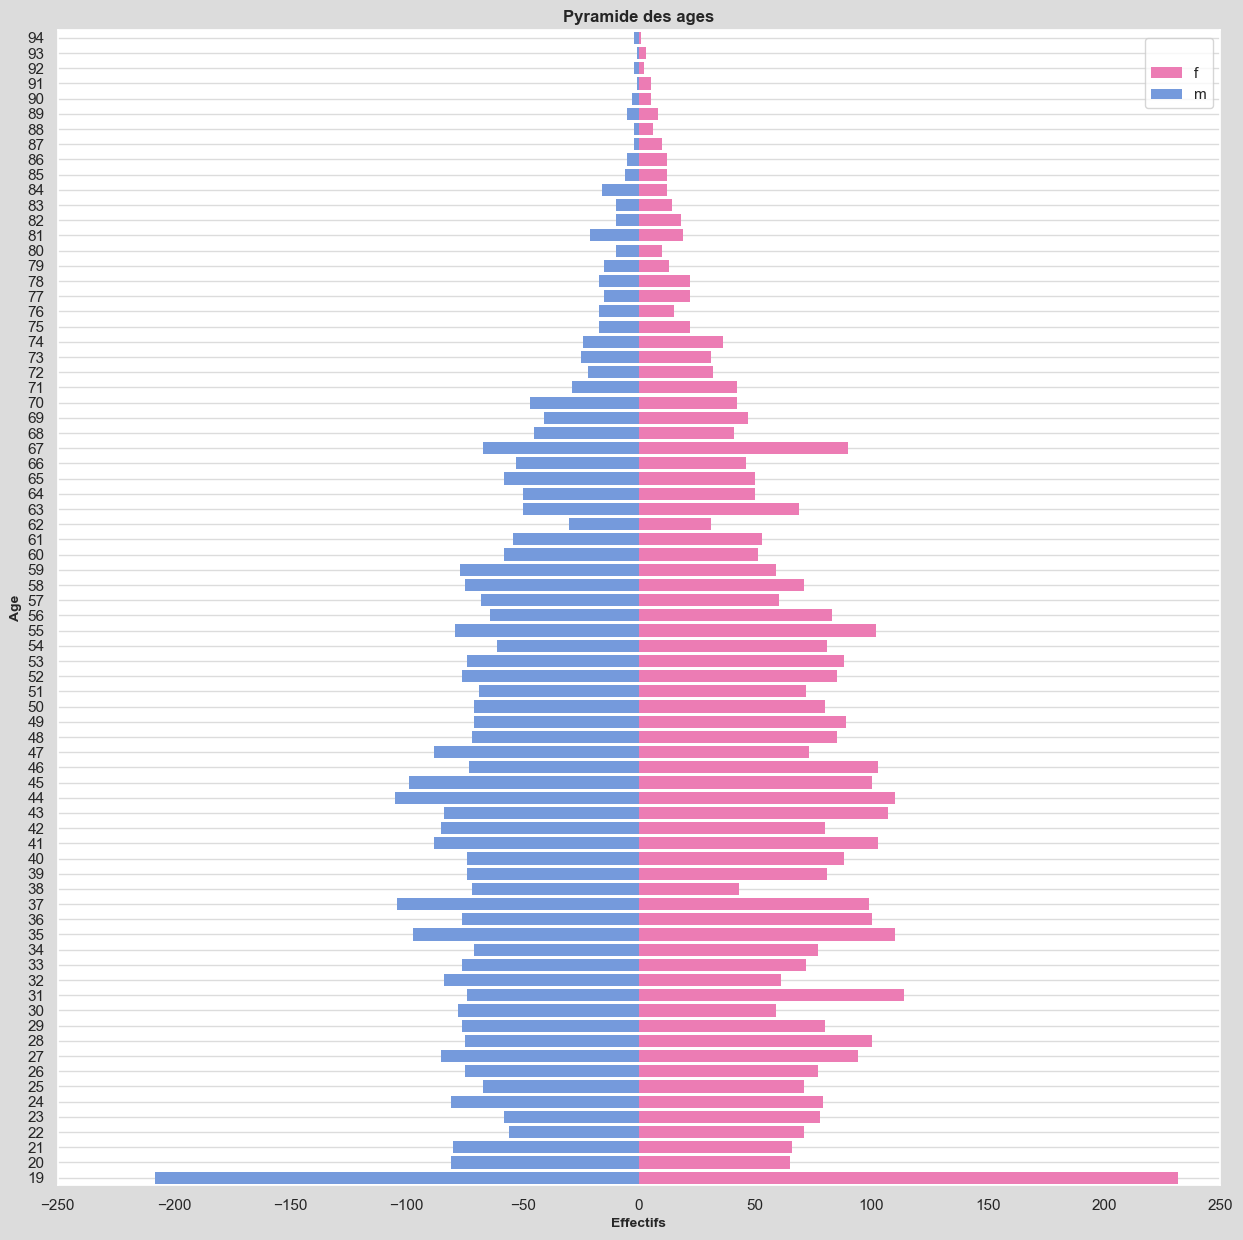

In [123]:
# Plot age pyramid
sns.set(rc={'figure.figsize':(15,15),'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})
order_bars = clients_pyr['age_clients'].unique()[::-1]
graph18 = sns.barplot(data=clients_pyr, x='client_count_g', y='age_clients', hue='gender_clients', orient='horizontal',
            order=order_bars, dodge=False, palette=['hotpink', 'cornflowerblue'], lw=0)
graph18.set_title("Pyramide des ages", fontname='Arial', fontsize=12, fontweight='bold')
plt.xlabel('Effectifs', fontweight='bold', fontsize=10)
plt.ylabel("Age", fontweight='bold', fontsize=10)
plt.xticks([-250, -200, -150, -100, -50, 0, 50, 100, 150, 200, 250], rotation=0)
plt.xlim([-250, 250])
plt.grid(axis='y', color='gainsboro')
plt.legend(title=' ')
plt.savefig("graph18.png", bbox_inches='tight')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


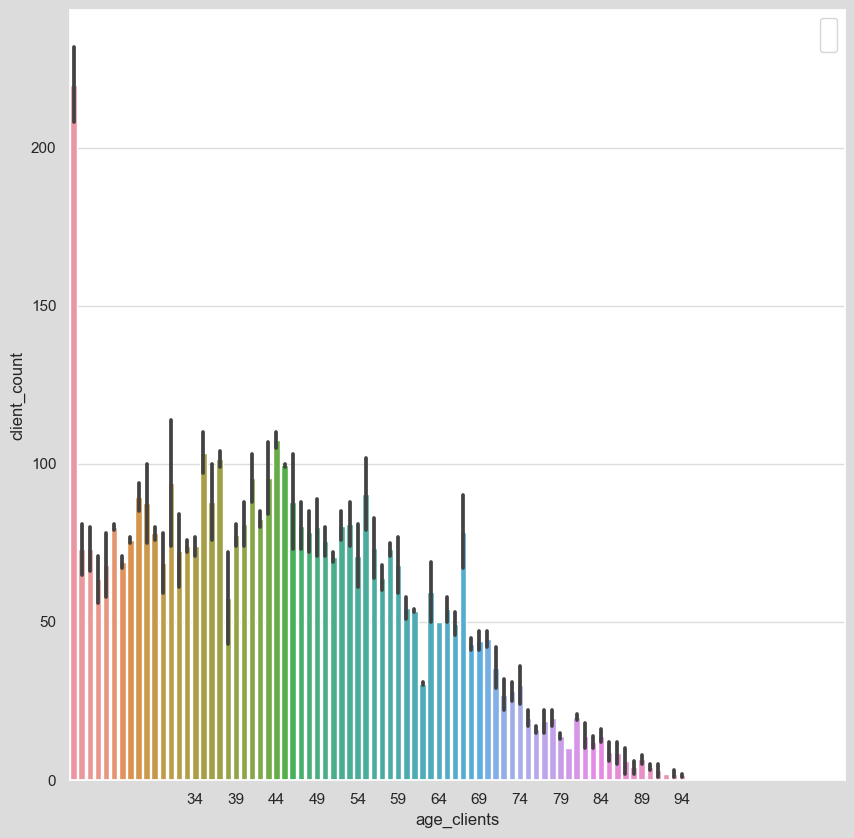

In [124]:
# Plot client age distribution
sns.set(rc={'figure.figsize':(10,10),'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})
graph19 = sns.barplot(data=clients_pyr, x='age_clients', y='client_count')
plt.xticks([15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95], rotation=0)
plt.grid(axis='y', color='gainsboro')
plt.legend(title=' ')
plt.savefig("graph19.png", bbox_inches='tight')
plt.show()

In [125]:
# test for normality of age distribution using Anderson-Darling test
# H0 : the age of our clients follows a normal distribution
print(st.anderson(clients_pyr['age_clients'], dist='norm'))

AndersonResult(statistic=1.6715963597803238, critical_values=array([0.562, 0.64 , 0.768, 0.895, 1.065]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))


#### La statistique de test vaut 1.6716. Elle est superieure a toutes les valeurs critiques pour tous les niveaux de risque testes. Les resultats du test sont donc significatifs jusqu'au seuil de risque α = 1%, et nous avons donc suffisamment d'informations pour rejeter H0 et conclure que l'age de nos clients n'est pas distribue selon une loi N(μ,σ).

In [126]:
# create data for nested donuts by age group
clients_pyr_2 = clients.groupby(['gender_clients', 'age_range_clients'])['client_id_clients'].count().reset_index()
clients_pyr_2.rename(columns={'client_id_clients': 'client_count'}, inplace=True)
clients_pyr_2.loc[(clients_pyr_2['gender_clients'] == 'm'), 'client_count_g'] = clients_pyr_2['client_count']*-1
clients_pyr_2.loc[(clients_pyr_2['gender_clients'] == 'f'), 'client_count_g'] = clients_pyr_2['client_count']
clients_pyr_2

gender_clients age_range_clients  client_count  client_count_g
0              f             15-24           591           591.0
1              f             25-34           805           805.0
2              f             35-49          1371          1371.0
3              f             50-64          1035          1035.0
4              f               65+           688           688.0
5              m             15-24           564          -564.0
6              m             25-34           761          -761.0
7              m             35-49          1262         -1262.0
8              m             50-64           956          -956.0
9              m               65+           588          -588.0

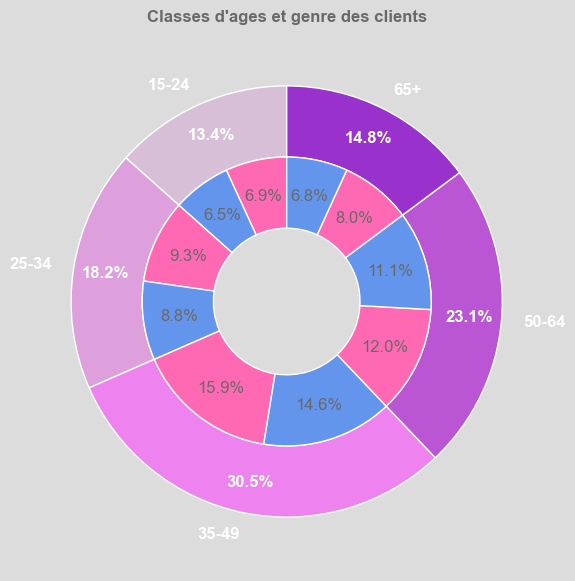

In [127]:
#plot nested donut chart by age group and gender

fig, ax = plt.subplots(figsize=(7,7))
fig.set_facecolor('gainsboro')
size = 0.33

outer_colors_GR20 = ['thistle', 'plum','violet','mediumorchid','darkorchid']
inner_colors_GR20 = ['hotpink', 'cornflowerblue']

#plot outer donut by age group
ax.pie(clients_pyr_2.groupby('age_range_clients', sort=True)['client_count'].sum(), radius=1,
       colors=outer_colors_GR20,
       labels=clients_pyr_2['age_range_clients'].drop_duplicates(),
       autopct=my_autopct, pctdistance=0.85, wedgeprops=dict(width=size, edgecolor='w'),
       textprops={'fontsize': 12, 'color':'white','fontweight':'bold'},startangle=90)

#plot inner donut by genre
ax.pie(clients_pyr_2.groupby(['age_range_clients','gender_clients'], sort=True)['client_count'].sum(), radius=1-size,
      colors=inner_colors_GR20, autopct=my_autopct,
       pctdistance=0.75, wedgeprops=dict(width=size, edgecolor='w'), textprops={'fontsize': 12, 'color':'dimgray'},
       startangle=90)

#adding title inside the plot
plt.text(-0.65, 1.3, "Classes d'ages et genre des clients", fontsize=12, fontweight='bold', color='dimgray')

plt.savefig("graph20.png", bbox_inches='tight')
plt.show()

#### On constate que la repartition hommes/femmes est  similaire dans toutes les classes d'ages de nos clients.

#### Une analyse RFM (recence-frequence-montant) semble faire peu de sens pour un bien culturel tel que le livre (bien d'acquisition et non de consommation). Par ailleurs, l'historique limite des transactions clients (2 ans) n'est pas suffisant pour calculer un taux d'attrition significatif. Nous etablirons donc une segmentation basique de nos clients en fonction du nombre de livres lus par an.

In [128]:
CA_val_cli = CA.groupby(['client_id_sales']).agg({'price_books' : ['sum'] ,'session_id_sales' : ['count']}
                                                              ).reset_index()
CA_val_cli.rename(columns={'price_books': 'amount_spent', 'session_id_sales':'books_purchased'}, inplace=True)

# classify clients by tiers depending on numbers of books purchased on average every year
CA_val_cli3 = CA_val_cli.copy()
CA_val_cli3['books_per_year'] = CA_val_cli['books_purchased']/2
CA_val_cli3.loc[(CA_val_cli3['books_per_year'] > 0)
                & (CA_val_cli3['books_per_year'] <= 5), 'reader_class'] = "Petits lecteurs"
CA_val_cli3.loc[(CA_val_cli3['books_per_year'] > 5)
                & (CA_val_cli3['books_per_year'] <= 20), 'reader_class'] = "Lecteurs moyens"
CA_val_cli3.loc[(CA_val_cli3['books_per_year'] > 20)
                & (CA_val_cli3['books_per_year'] <= 52), 'reader_class'] = "Grands lecteurs"
CA_val_cli3.loc[(CA_val_cli3['books_per_year'] > 52)
                & (CA_val_cli3['books_per_year'] <= 104), 'reader_class'] = "Tres grands lecteurs"
CA_val_cli3.loc[(CA_val_cli3['books_per_year'] > 104)
                & (CA_val_cli3['books_per_year'] <= 1000), 'reader_class'] = "Collectionneurs"
CA_val_cli3.loc[(CA_val_cli3['books_per_year'] > 1000), 'reader_class'] = "Clients professionnels"

# create data for nested donut chart by age group and reader class
CA_val_cli3 = pd.DataFrame(CA_val_cli3.groupby(( 'client_id_sales',      '')).agg(
    {(    'reader_class',      ''): 'first'})).reset_index()
CA_val_cli3.columns = CA_val_cli3.columns.droplevel(1)
client_tiers = pd.merge(clients,CA_val_cli3,how='right',right_on='client_id_sales', left_on='client_id_clients')

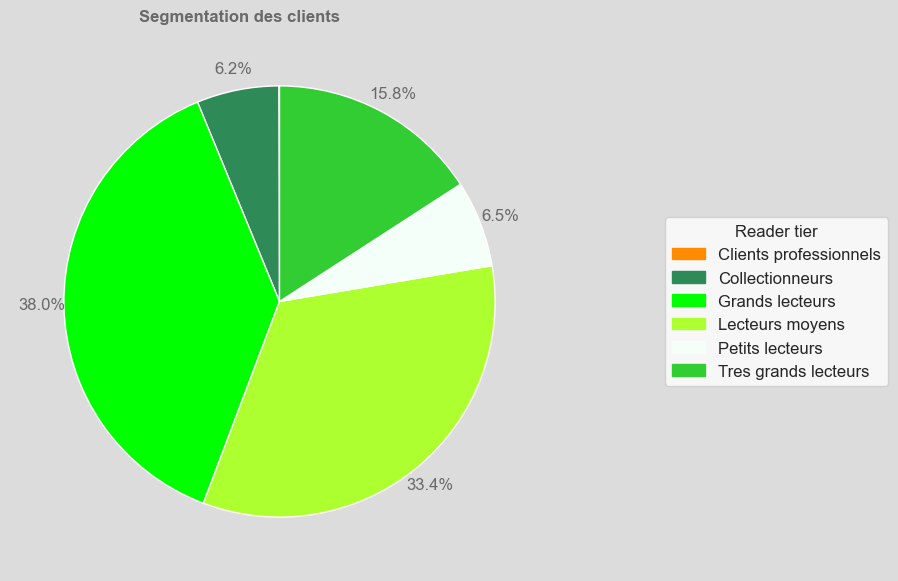

In [129]:
#plot pie by reader class
fig, ax = plt.subplots(figsize=(7,7))
fig.set_facecolor('gainsboro')
ax.pie(client_tiers.groupby(['reader_class'], sort=True)['client_id_clients'].count(), radius=1,
      colors=['darkorange','seagreen','lime','greenyellow','mintcream', 'limegreen'], autopct=my_autopct, pctdistance=1.1,
       wedgeprops=dict(edgecolor='w'), textprops={'fontsize': 12, 'color':'dimgray'},startangle=90)
ax.legend(client_tiers['reader_class'].drop_duplicates().sort_values(), title="Reader tier", loc="center left",
          bbox_to_anchor=(1.2, 0, 0.5, 1), fontsize=12)
leg = ax.get_legend()
leg.legendHandles[0].set_color('darkorange')
leg.legendHandles[1].set_color('seagreen')
leg.legendHandles[2].set_color('lime')
leg.legendHandles[3].set_color('greenyellow')
leg.legendHandles[4].set_color('mintcream')
leg.legendHandles[5].set_color('limegreen')

#adding title inside the plot
plt.text(-0.65, 1.3, "Segmentation des clients", fontsize=12, fontweight='bold', color='dimgray')

plt.savefig("graph21.png", bbox_inches='tight')
plt.show()

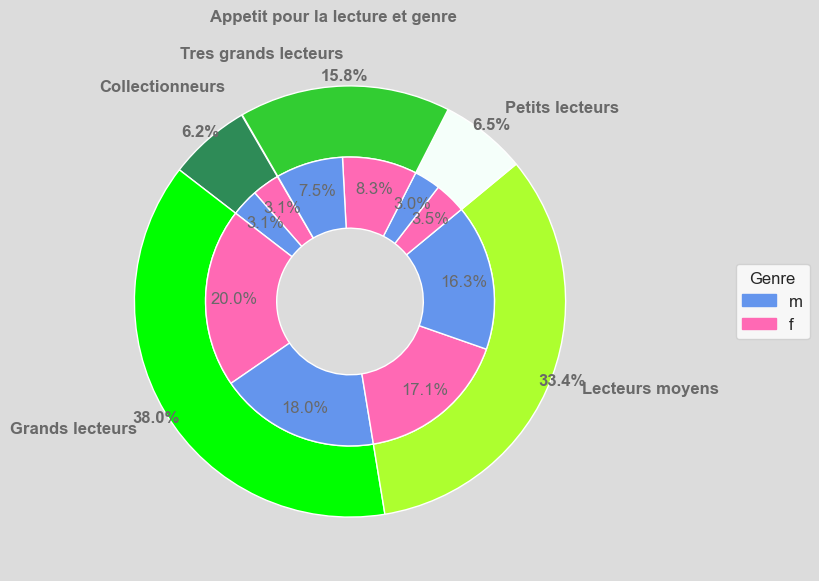

In [130]:
#plot nested donut chart by age group and gender

fig, ax = plt.subplots(figsize=(7,7))
fig.set_facecolor('gainsboro')
size = 0.33
inner_colors_GR22 = ['hotpink', 'cornflowerblue']
outer_colors_GR22 = ['darkorange','seagreen','lime','greenyellow','mintcream','limegreen']


#plot outer donut by age group
ax.pie(client_tiers.groupby('reader_class')['client_id_clients'].count(), radius=1,
       colors=outer_colors_GR22,
       labels=['Collectionneurs','','Grands lecteurs','Lecteurs moyens','Petits lecteurs','Tres grands lecteurs'],
       autopct=my_autopct, pctdistance=1.05, labeldistance=1.15, wedgeprops=dict(width=size, edgecolor='w'),
       textprops={'fontsize': 12, 'color':'dimgray','fontweight':'bold'},startangle=120)

#plot inner donut by genre
ax.pie(client_tiers.groupby(['reader_class','gender_clients'])['client_id_clients'].count(), radius=1-size,
      colors=inner_colors_GR22, autopct=my_autopct, pctdistance=0.80, wedgeprops=dict(width=size, edgecolor='w'),
       textprops={'fontsize': 12, 'color':'dimgray'},startangle=120)

ax.legend(client_tiers['gender_clients'].drop_duplicates(), title="Genre", loc="center left",
          bbox_to_anchor=(1.2, 0, 0.5, 1), fontsize=12)

leg1 = ax.get_legend()
leg1.legendHandles[0].set_color(inner_colors_GR22[1])
leg1.legendHandles[1].set_color(inner_colors_GR22[0])


#adding title inside the plot
plt.text(-0.65, 1.3, "Appetit pour la lecture et genre", fontsize=12, fontweight='bold', color='dimgray')

plt.savefig("graph22.png", bbox_inches='tight')
plt.show()

In [131]:
# add age column in no_sales dataframe
no_sales2 = no_sales.copy()
no_sales2['age_clients'] = currentYear - no_sales2['birth_year_clients']

# add age ranges in no_sales dataframe
# the limitsof each age category have been set to match the IPSOS study available at
# https://centrenationaldulivre.fr/actualites/resultats-de-l-etude-les-jeunes-francais-et-la-lecture
# in order to draw meaningful comparisons to the general French population
no_sales2.loc[(no_sales2['age_clients'] >= 7) & (no_sales2['age_clients'] <= 14), 'age_range_clients'] = "7-14"
no_sales2.loc[(no_sales2['age_clients'] >= 15) & (no_sales2['age_clients'] <= 24), 'age_range_clients'] = "15-24"
no_sales2.loc[(no_sales2['age_clients'] >= 25) & (no_sales2['age_clients'] <= 34), 'age_range_clients'] = "25-34"
no_sales2.loc[(no_sales2['age_clients'] >= 35) & (no_sales2['age_clients'] <= 49), 'age_range_clients'] = "35-49"
no_sales2.loc[(no_sales2['age_clients'] >= 50) & (no_sales2['age_clients'] <= 64), 'age_range_clients'] = "50-64"
no_sales2.loc[(no_sales2['age_clients'] >= 65), 'age_range_clients'] = "65+"

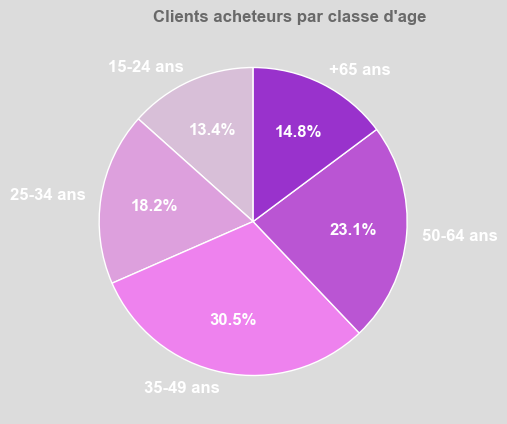

In [132]:
#plot pie by age group for buying clients

fig, ax = plt.subplots(figsize=(5,5))
fig.set_facecolor('gainsboro')

colors_GR23 = ['thistle','plum', 'violet','mediumorchid','darkorchid']

ax.pie(clients_pyr_2.groupby('age_range_clients')['client_count'].sum(), radius=1,
       colors=colors_GR23, labels=['15-24 ans','25-34 ans','35-49 ans','50-64 ans','+65 ans'],
       autopct=my_autopct, pctdistance=0.65, textprops={'fontsize': 12, 'color':'white','fontweight':'bold'},startangle=90)

#adding title inside the plot
plt.text(-0.65, 1.3, "Clients acheteurs par classe d'age", fontsize=12, fontweight='bold', color='dimgray')

plt.savefig("graph23.png", bbox_inches='tight')
plt.show()

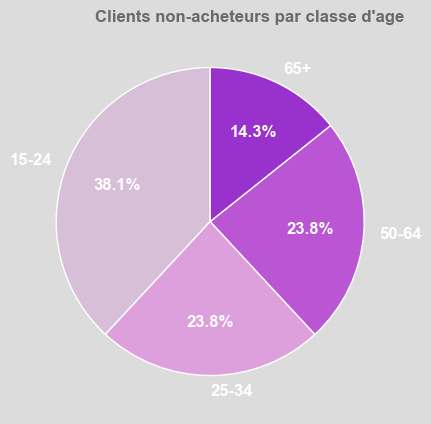

In [133]:
#plot pie by age group for non-buying clients

fig, ax = plt.subplots(figsize=(5,5))
fig.set_facecolor('gainsboro')

colors_GR24 = ['thistle','plum', 'mediumorchid','darkorchid']

ax.pie(no_sales2.groupby('age_range_clients', sort=True)['client_id_clients'].count(), radius=1,
       colors=colors_GR24, labels=no_sales2['age_range_clients'].drop_duplicates(),
       autopct=my_autopct, pctdistance=0.65, textprops={'fontsize': 12, 'color':'white','fontweight':'bold'},startangle=90)

#adding title inside the plot
plt.text(-0.75, 1.3, "Clients non-acheteurs par classe d'age", fontsize=12, fontweight='bold', color='dimgray')

plt.savefig("graph24.png", bbox_inches='tight')
plt.show()

#### La distribution par classe d'age des clients non-acheteurs est significativement differente de celle des clients acheteurs; les 35-49 ans en sont absents et les 15-24 ans y sont sur-representes (plus du double de la proportion des clients acheteurs, qui s'etablit a 14.8% pour cette classe d'age).

#### 3.1.3.2 - Analyse en valeur (CA)

In [134]:
# find top and bottom 10 clients by value (turnover)
CA_val_cli.sort_values(("amount_spent", "sum"), inplace=True, ascending=False)
print(CA_val_cli.head(x).to_csv("top_cli_val.csv", index=False))
print("Les", x, "clients ayant fait le plus d'achats en valeur sont:\n")
CA_val_cli.head(x)

None
Les 10 clients ayant fait le plus d'achats en valeur sont:



client_id_sales amount_spent books_purchased
                              sum           count
677           c_1609    324033.35           25488
4388          c_4958    289760.34            5195
6337          c_6714    153660.84            9187
2724          c_3454    113668.89            6773
2513          c_3263      5276.87             403
634           c_1570      5271.62             369
2108          c_2899      5214.05             105
1268          c_2140      5208.82             402
7006          c_7319      5155.77             371
7791          c_8026      5092.90             377

In [135]:
print(CA_val_cli.head(x).to_csv("tableau3b.csv", index=False))
print("Les", x, "clients ayant fait le moins d'achats en valeur sont:\n")
CA_val_cli.tail(x)

None
Les 10 clients ayant fait le moins d'achats en valeur sont:



client_id_sales amount_spent books_purchased
                              sum           count
5354          c_5829        16.07               2
5453          c_5919        15.98               2
5589          c_6040        15.72               2
5501          c_5962        13.99               1
3855          c_4478        13.36               1
4044          c_4648        11.20               1
1556           c_240        11.06               1
7889          c_8114         9.98               2
7918          c_8140         8.30               2
8151          c_8351         6.31               1

#### 3.1.3.3 - En volume (unites achetees)

In [136]:
# list of clients having never made a purchase online (from part 1 analysis)
print(no_sales.shape[0], " clients n'ont jamais fait d'achat en ligne. Liste:")
no_sales

21  clients n'ont jamais fait d'achat en ligne. Liste:


client_id_clients gender_clients  birth_year_clients
801             c_8253              f                2001
2483            c_3789              f                1997
2734            c_4406              f                1998
2769            c_2706              f                1967
2851            c_3443              m                1959
3179            c_4447              m                1956
3190            c_3017              f                1992
3334            c_4086              f                1992
3721            c_6930              m                2004
3821            c_4358              m                1999
4724            c_8381              f                1965
4791            c_1223              m                1963
6112            c_6862              f                2002
6208            c_5245              f                2004
6338            c_5223              m                2003
6471            c_6735              m                2004
6585             c_862              f                1956
6828            c_7584              f                1960
7790              c_90              m                2001
7819             c_587              m                1993
8536            c_3526              m                1956

In [137]:
CA_val_cli.sort_values(("books_purchased", "count"), inplace=True, ascending=False)
print(CA_val_cli.head(x).to_csv("tableau3a.csv", index=False))
print("Les", x, "clients ayant fait le plus d'achats en volume sont:\n")
CA_val_cli.head(x)

None
Les 10 clients ayant fait le plus d'achats en volume sont:



client_id_sales amount_spent books_purchased
                              sum           count
677           c_1609    324033.35           25488
6337          c_6714    153660.84            9187
2724          c_3454    113668.89            6773
4388          c_4958    289760.34            5195
2513          c_3263      5276.87             403
1268          c_2140      5208.82             402
1772          c_2595      4959.66             398
1197          c_2077      4816.78             384
708           c_1637      4698.87             380
7120          c_7421      5050.20             379

In [138]:
print(CA_val_cli.tail(x).to_csv("tableau3b.csv", index=False))
print("Les", x, "clients ayant fait le moins d'achats en volume sont:\n")
CA_val_cli.tail(x)

None
Les 10 clients ayant fait le moins d'achats en volume sont:



client_id_sales amount_spent books_purchased
                              sum           count
259           c_1232        39.70               2
6785           c_712        39.62               2
4044          c_4648        11.20               1
1556           c_240        11.06               1
5868          c_6292        24.24               1
3855          c_4478        13.36               1
5501          c_5962        13.99               1
3576          c_4223        24.81               1
694           c_1624        28.54               1
8151          c_8351         6.31               1

In [139]:
# classify clients by tiers depending on numbers of books purchased on average every year
CA_val_cli2 = CA_val_cli.copy()
CA_val_cli2['books_per_year'] = CA_val_cli2['books_purchased']/2
CA_val_cli2.loc[(CA_val_cli2['books_per_year'] > 0)
                & (CA_val_cli2['books_per_year'] <= 5), 'reader_class'] = "Petit lecteurs"
CA_val_cli2.loc[(CA_val_cli2['books_per_year'] > 5)
                & (CA_val_cli2['books_per_year'] <= 20), 'reader_class'] = "Lecteurs moyens"
CA_val_cli2.loc[(CA_val_cli2['books_per_year'] > 20)
                & (CA_val_cli2['books_per_year'] <= 52), 'reader_class'] = "Grands lecteurs"
CA_val_cli2.loc[(CA_val_cli2['books_per_year'] > 52)
                & (CA_val_cli2['books_per_year'] <= 104), 'reader_class'] = "Tres grands lecteurs"
CA_val_cli2.loc[(CA_val_cli2['books_per_year'] > 104)
                & (CA_val_cli2['books_per_year'] <= 1000), 'reader_class'] = "Collectionneurs"
CA_val_cli2.loc[(CA_val_cli2['books_per_year'] > 1000), 'reader_class'] = "Clients professionnels"
CA_val_cli2 = pd.DataFrame(CA_val_cli2.groupby('reader_class')['client_id_sales'].count())
CA_val_cli2['%'] = round(CA_val_cli2['client_id_sales']/len(CA_val_cli['client_id_sales'].unique())*100, 2)
CA_val_cli2.sort_values(("client_id_sales"), inplace=True, ascending=False)
CA_val_cli2.rename(columns={'client_id_sales': 'nb_clients'}, inplace=True)
CA_val_cli2

nb_clients      %
reader_class                             
Grands lecteurs               3272  38.05
Lecteurs moyens               2873  33.41
Tres grands lecteurs          1363  15.85
Petit lecteurs                 558   6.49
Collectionneurs                530   6.16
Clients professionnels           4   0.05

#### 3.1.3.4 - Courbe de Lorenz & indice de Gini

In [140]:
CA_cli_BP = CA.groupby('client_id_sales')['price_books'].sum().reset_index()
cli_pro = CA_cli_BP.loc[CA_cli_BP['price_books'] > 10000]
list_cli_pro = cli_pro['client_id_sales'].tolist()
cli_pro_info = clients.loc[clients['client_id_clients'].isin(list_cli_pro)]
cli_pro_info

client_id_clients gender_clients  birth_year_clients  age_clients  \
1378            c_4958              m                1999           24   
1911            c_6714              f                1968           55   
3642            c_1609              m                1980           43   
8088            c_3454              m                1969           54   

     age_range_clients  
1378             15-24  
1911             50-64  
3642             35-49  
8088             50-64

In [141]:
CA_val_cli_indiv = CA_val_cli.loc[~CA_val_cli['client_id_sales'].isin(list_cli_pro)][['client_id_sales', 'amount_spent',
                                                                                  'books_purchased']].copy()

# calculate total turnover for all non_professional clients
dep_tot_indiv = CA_val_cli_indiv['amount_spent'].sum()
print("chiffre d'affaires total realise avec les clients particuliers",'{:,.2f}'.format(dep_tot_indiv[0]))

# calculate total turnover for professional clients
dep_tot_pros = CA_val_cli.loc[CA_val_cli['client_id_sales'].isin(list_cli_pro)]['amount_spent'].sum()
print("chiffre d'affaires total realise avec les clients professionnels:",'{:,.2f}'.format(dep_tot_pros[0]))

# calculate total turnover for all clients
dep_tot = CA_val_cli['amount_spent'].sum()
print("Chiffre d'affaires total:",'{:,.2f}'.format(dep_tot[0]))

print("Les 4 clients professionnels representent", round((dep_tot_pros.values[0]/dep_tot.values[0])*100,2),
      "% de notre chiffre d'affaires total. \n")

CA_year1 = CA.loc[CA['fin_year_sales'] == 'year 1']['price_books'].sum()
print("Chiffre d'affaires annee 1:", '{:,.2f}'.format(CA_year1))
CA_year1_pro = CA.loc[(CA['fin_year_sales'] == 'year 1') 
                      & (CA['client_id_sales'].isin(list_cli_pro))]['price_books'].sum()
CA_year1_indiv = CA_year1 - CA_year1_pro
print("Dont clients professionnels:", '{:,.2f}'.format(CA_year1_pro))
print("Depense moyenne professionnels annee 1:", '{:,.2f}'.format(CA_year1_pro/4))
print("Dont clients particuliers:", '{:,.2f}'.format(CA_year1_indiv))
print("Depense moyenne particuliers annee 1:", '{:,.2f}'.format(CA_year1_indiv/8596))

CA_year2 = CA.loc[CA['fin_year_sales'] == 'year 2']['price_books'].sum()
print("\nChiffre d'affaires annee 2:", '{:,.2f}'.format(CA_year2))
CA_year2_pro = CA.loc[(CA['fin_year_sales'] == 'year 2') 
                      & (CA['client_id_sales'].isin(list_cli_pro))]['price_books'].sum()
CA_year2_indiv = CA_year2 - CA_year2_pro
print("Dont clients professionnels:", '{:,.2f}'.format(CA_year2_pro))
print("Depense moyenne professionnels annee 2:", '{:,.2f}'.format(CA_year2_pro/4))
print("Dont clients particuliers:", '{:,.2f}'.format(CA_year2_indiv))
print("Depense moyenne particuliers annee 2:", '{:,.2f}'.format(CA_year2_indiv/8596))

delta_CA = ((CA_year2 - CA_year1) / CA_year1 ) * 100
print("\nEvolution totale chiffre d'affaires +", '{:,.2f}'.format(delta_CA),"%")
delta_CA_indiv = ((CA_year2_indiv -CA_year1_indiv ) / CA_year1_indiv) * 100
print("Evolution chiffre d'affaires clients particuliers +", '{:,.2f}'.format(delta_CA_indiv),"%")
delta_CA_pro = ((CA_year2_pro - CA_year1_pro)  / CA_year1_pro) * 100
print("Evolution chiffre d'affaires clients professionnels +", '{:,.2f}'.format(delta_CA_pro),"%")

chiffre d'affaires total realise avec les clients particuliers 10,974,885.98
chiffre d'affaires total realise avec les clients professionnels: 881,123.42
Chiffre d'affaires total: 11,856,009.40
Les 4 clients professionnels representent 7.43 % de notre chiffre d'affaires total. 

Chiffre d'affaires annee 1: 5,832,800.01
Dont clients professionnels: 435,733.85
Depense moyenne professionnels annee 1: 108,933.46
Dont clients particuliers: 5,397,066.16
Depense moyenne particuliers annee 1: 627.86

Chiffre d'affaires annee 2: 6,023,209.39
Dont clients professionnels: 445,389.57
Depense moyenne professionnels annee 2: 111,347.39
Dont clients particuliers: 5,577,819.82
Depense moyenne particuliers annee 2: 648.89

Evolution totale chiffre d'affaires + 3.26 %
Evolution chiffre d'affaires clients particuliers + 3.35 %
Evolution chiffre d'affaires clients professionnels + 2.22 %


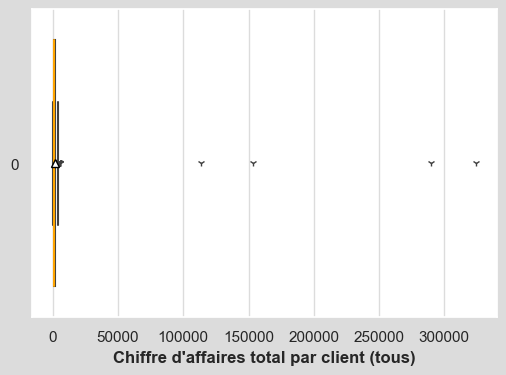

In [142]:
# analyse total sales by client with a box plot
sns.set(rc={'figure.figsize':(6,4),'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})
graph25 = sns.boxplot(data=CA_cli_BP[('price_books')], flierprops={"marker": "1"},
            medianprops={"color" : "orange"}, meanprops={"markerfacecolor":"white", "markeredgecolor":"black"},
            orient="h", color=col, showmeans=True)
plt.xlabel("Chiffre d'affaires total par client (tous)", fontweight='bold', fontsize=12)
plt.grid(axis='x', color='gainsboro')
plt.savefig("graph25.png", bbox_inches='tight')

#### On retrouve les 4 clients professionnels dont les achats sont tres superieurs a ceux des autres clients.

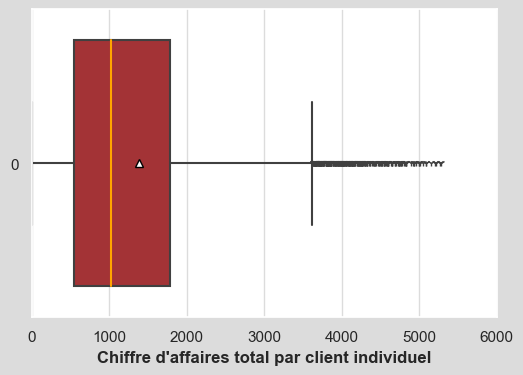

In [143]:
# analyse total sales by client with a box plot
sns.set(rc={'figure.figsize':(6,4),'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})
graph26 = sns.boxplot(data=CA_cli_BP[('price_books')], flierprops={"marker": "1"},
            medianprops={"color" : "orange"}, meanprops={"markerfacecolor":"white", "markeredgecolor":"black"},
            orient="h", color=col, showmeans=True)
plt.xlim([0,6000]) #zoom in to exclude professional clients from view
plt.xlabel("Chiffre d'affaires total par client individuel", fontweight='bold', fontsize=12)
plt.grid(axis='x', color='gainsboro')
plt.savefig("graph26.png", bbox_inches='tight')
plt.show()

In [144]:
# Create data to compare both financial years for executive summary
sales_year1 = sales_trim.loc[(sales_trim['fin_year_sales'] == 'year 1') & (~sales_trim['client_id_sales'].isin(list_cli_pro))]
sales_year1['category_books'] = sales_year1['product_id_sales'].str[:1]
sales_year1_pro = sales_trim.loc[(sales_trim['fin_year_sales'] == 'year 1') 
                                 & (sales_trim['client_id_sales'].isin(list_cli_pro))].copy()
sales_year1_pro['category_books'] = sales_year1_pro['product_id_sales'].str[:1]
sales_year2 = sales_trim.loc[(sales_trim['fin_year_sales'] == 'year 2') & (~sales_trim['client_id_sales'].isin(list_cli_pro)) ]
sales_year2['category_books'] = sales_year2['product_id_sales'].str[:1]
sales_year2_pro = sales_trim.loc[(sales_trim['fin_year_sales'] == 'year 2') 
                                 & (sales_trim['client_id_sales'].isin(list_cli_pro))].copy()
sales_year2_pro['category_books'] = sales_year2_pro['product_id_sales'].str[:1]
nb_sales_year1 = sales_year1.groupby('fin_year_sales')[['product_id_sales', 'client_id_sales']].agg(
    ['count', 'size', 'nunique']).reset_index()
print("Ventes aux particuliers annee 1:")
nb_sales_year1

C:\Users\PC\AppData\Local\Temp\ipykernel_17368\4214664817.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_year1['category_books'] = sales_year1['product_id_sales'].str[:1]
C:\Users\PC\AppData\Local\Temp\ipykernel_17368\4214664817.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_year2['category_books'] = sales_year2['product_id_sales'].str[:1]


Ventes aux particuliers annee 1:


fin_year_sales product_id_sales                 client_id_sales          \
                            count    size nunique           count    size   
0         year 1           314099  314099    3263          314099  314099   

           
  nunique  
0    8596

In [145]:
nb_sales_year1_pro = sales_year1_pro.groupby('fin_year_sales')[['product_id_sales', 'client_id_sales']].agg(
    ['count', 'size', 'nunique']).reset_index()
print("Ventes aux professionnels annee 1:")
nb_sales_year1_pro

Ventes aux professionnels annee 1:


fin_year_sales product_id_sales                client_id_sales         \
                            count   size nunique           count   size   
0         year 1            23189  23189    2354           23189  23189   

           
  nunique  
0       4

In [146]:
sales_year1_pro_cat = sales_year1_pro.groupby('category_books')['product_id_sales'].count().reset_index()
print(sales_year1_pro_cat.to_csv("ventes_pro_y1_cat.csv", index=False))
print("Ventes aux professionnels par categorie annee 1:")
sales_year1_pro_cat

None
Ventes aux professionnels par categorie annee 1:


category_books  product_id_sales
0              0             14271
1              1              7110
2              2              1808

In [147]:
sales_year1_indiv_cat = sales_year1.groupby('category_books')['product_id_sales'].count().reset_index()
print(sales_year1_indiv_cat.to_csv("ventes_indiv_y1_cat.csv", index=False))
print("Ventes aux particuliers par categorie annee 1:")
sales_year1_indiv_cat

None
Ventes aux particuliers par categorie annee 1:


category_books  product_id_sales
0              0            195494
1              1            102625
2              2             15980

In [148]:
nb_sales_year2 = sales_year2.groupby('fin_year_sales')[['product_id_sales', 'client_id_sales']].agg(
    ['count', 'size', 'nunique']).reset_index()
print("Ventes aux particuliers annee 2:")
nb_sales_year2

Ventes aux particuliers annee 2:


fin_year_sales product_id_sales                 client_id_sales          \
                            count    size nunique           count    size   
0         year 2           318590  318590    3209          318590  318590   

           
  nunique  
0    8520

In [149]:
nb_sales_year2_pro = sales_year2_pro.groupby('fin_year_sales')[['product_id_sales', 'client_id_sales']].agg(
    ['count', 'size', 'nunique']).reset_index()
print("Ventes aux professionnels annee 2:")
nb_sales_year2_pro

Ventes aux professionnels annee 2:


fin_year_sales product_id_sales                client_id_sales         \
                            count   size nunique           count   size   
0         year 2            23454  23454    2094           23454  23454   

           
  nunique  
0       4

In [150]:
sales_year2_pro_cat = sales_year2_pro.groupby('category_books')['product_id_sales'].count().reset_index()
print(sales_year2_pro_cat.to_csv("ventes_pro_y2_cat.csv", index=False))
print("Ventes aux professionnels par categorie annee 2:")
sales_year2_pro_cat

None
Ventes aux professionnels par categorie annee 2:


category_books  product_id_sales
0              0             13916
1              1              7711
2              2              1827

In [151]:
sales_year2_indiv_cat = sales_year2.groupby('category_books')['product_id_sales'].count().reset_index()
print(sales_year2_indiv_cat.to_csv("ventes_indiv_y2_cat.csv", index=False))
print("Ventes aux particuliers par categorie annee 2:")
sales_year2_indiv_cat

None
Ventes aux particuliers par categorie annee 2:


category_books  product_id_sales
0              0            191999
1              1            109723
2              2             16868

#### Les clients professionnels comme particuliers achetent majoritairement des produits de categorie 0

In [152]:
clients_y1 = nb_sales_year1['client_id_sales', 'nunique'].values[0]
clients_y2 = nb_sales_year2['client_id_sales', 'nunique'].values[0]
print("Nombre d'acheteurs:",round(((clients_y2 - clients_y1)/clients_y1)*100,2),"%.")

Nombre d'acheteurs: -0.88 %.


In [153]:
books_y1 = nb_sales_year1['product_id_sales',   'count'].values[0]
books_y2 = nb_sales_year2['product_id_sales',   'count'].values[0]
print("Nombre de livres vendus: +",round(((books_y2 - books_y1)/books_y1)*100,2),"%.")

Nombre de livres vendus: + 1.43 %.


In [154]:
CA_indiv2 = CA.loc[~CA['client_id_sales'].isin(list_cli_pro)]
CA_pro2 = CA.loc[CA['client_id_sales'].isin(list_cli_pro)]
basket_avg = CA_indiv2.groupby(['session_id_sales','fin_year_sales'])['price_books'].mean().reset_index()
basket_avg_pro = CA_pro2.groupby(['session_id_sales','fin_year_sales'])['price_books'].mean().reset_index()
basket_avg2 = basket_avg.groupby('fin_year_sales')['price_books'].mean()
basket_avg2

fin_year_sales
year 1    18.811551
year 2    19.168329
Name: price_books, dtype: float64

In [155]:
basket_avg2_pro = basket_avg_pro.groupby('fin_year_sales')['price_books'].mean()
basket_avg2_pro

fin_year_sales
year 1    21.310701
year 2    21.412877
Name: price_books, dtype: float64

#### Les clients professionnels realisent plus de transactions que les clients particuliers et ont un montant du panier moyen plus eleve.

In [156]:
basket_y1 = basket_avg2[0]
basket_y2 = basket_avg2[1]
print("Panier moyen (clients particuliers): +",round(((basket_y2 - basket_y1)/basket_y1)*100,2),"%.")

Panier moyen (clients particuliers): + 1.9 %.


In [157]:
basket_y1_pro = basket_avg2_pro[0]
basket_y2_pro = basket_avg2_pro[1]
print("Panier moyen (clients professionnels): +",round(((basket_y2_pro - basket_y1_pro)/basket_y1_pro)*100,2),"%.")

Panier moyen (clients professionnels): + 0.48 %.


#### Le panier moyen des clients professionnels a enregistre une augmentation moins marquee entre l'annee 1 et l'annee 2.

In [158]:
CA_cli = pd.merge(CA, clients, how='left', left_on='client_id_sales', right_on='client_id_clients')
# fill in CA_cli['category_books'] for all products of reference 0_2245, otherwise totals in contingency table won't
# match length of original table CA_cli
CA_cli['category_books'] = CA_cli['product_id_sales'].str[:1]
CA_indiv3 = CA_cli.loc[~CA['client_id_sales'].isin(list_cli_pro)]
basket_avg_genre = CA_indiv3.groupby('session_id_sales',as_index=False).agg({'price_books': 'mean', 
                                                                                             'gender_clients': 'first',
                                                                         'fin_year_sales': 'first'})
basket_avg_genre2 = basket_avg_genre.groupby(['fin_year_sales','gender_clients'])['price_books'].mean().reset_index()
print("Panier moyen:", round(basket_avg_genre2['price_books'].mean(),2), "€")

Panier moyen: 18.99 €


In [159]:
basket_avg_f_y1 = basket_avg_genre2.iloc[0,2]
basket_avg_m_y1 = basket_avg_genre2.iloc[1,2]
basket_avg_f_y2 = basket_avg_genre2.iloc[2,2]
basket_avg_m_y2 = basket_avg_genre2.iloc[3,2]
print("Panier moyen femmes:", round((basket_avg_f_y1+basket_avg_f_y2)/2,2), "€")

Panier moyen femmes: 18.95 €


In [160]:
print("Panier moyen hommes:", round((basket_avg_m_y1+basket_avg_m_y2)/2,2), "€")

Panier moyen hommes: 19.04 €


In [161]:
print("Panier moyen annee 1:", round((basket_avg_f_y1+basket_avg_m_y1)/2,2), "€")

Panier moyen annee 1: 18.81 €


In [162]:
print("Panier moyen annee 2:", round((basket_avg_f_y2+basket_avg_m_y2)/2,2), "€")

Panier moyen annee 2: 19.17 €


In [163]:
print("Depense moyenne femmes: +",round(((basket_avg_f_y2 - basket_avg_f_y1)/basket_avg_f_y1)*100,2),"%.")
print("Depense moyenne hommes: +",round(((basket_avg_m_y2 - basket_avg_m_y1)/basket_avg_m_y1)*100,2),"%.")

Depense moyenne femmes: + 1.99 %.
Depense moyenne hommes: + 1.8 %.


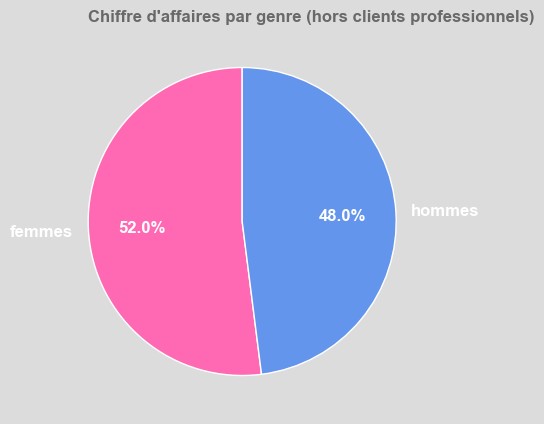

In [164]:
# create data for pie plot by turnover & genre for buying clients (individuals only)
CA_genre_pie = CA_indiv3.groupby('gender_clients')['price_books'].sum().reset_index()

# plot pie by turnover & genre for buying clients (individuals only)

fig, ax = plt.subplots(figsize=(5,5))
fig.set_facecolor('gainsboro')

colors_GR27 = ['hotpink','cornflowerblue']

ax.pie(CA_genre_pie['price_books'], radius=1,
       colors=colors_GR27, labels=['femmes','hommes'],
       autopct=my_autopct, pctdistance=0.65, textprops={'fontsize': 12, 'color':'white','fontweight':'bold'},startangle=90)

#adding title inside the plot
plt.text(-1, 1.3, "Chiffre d'affaires par genre (hors clients professionnels)", fontsize=12, fontweight='bold', color='dimgray')

plt.savefig("graph27.png", bbox_inches='tight')
plt.show()

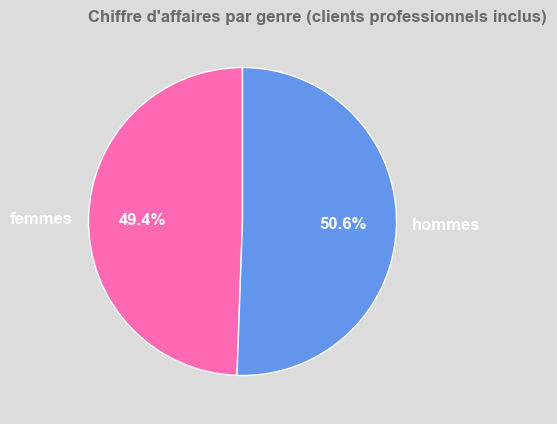

In [165]:
# create data for pie plot by turnover & genre for buying clients (all)
CA_genre_pie2 = CA_cli.groupby('gender_clients')['price_books'].sum().reset_index()

# plot pie by turnover & genre for buying clients (all)

fig, ax = plt.subplots(figsize=(5,5))
fig.set_facecolor('gainsboro')

colors_GR28 = ['hotpink','cornflowerblue']

ax.pie(CA_genre_pie2['price_books'], radius=1,
       colors=colors_GR28, labels=['femmes','hommes'],
       autopct=my_autopct, pctdistance=0.65, textprops={'fontsize': 12, 'color':'white','fontweight':'bold'},startangle=90)

#adding title inside the plot
plt.text(-1, 1.3, "Chiffre d'affaires par genre (clients professionnels inclus)", fontsize=12, fontweight='bold', color='dimgray')

plt.savefig("graph28.png", bbox_inches='tight')
plt.show()

##### 3.1.3.4.1 - Pour tous les clients

In [166]:
# calculate number of unique clients having made purchases
nb_cli = len(CA_val_cli['client_id_sales'].unique())
nb_cli

8600

In [167]:
# create data for Lorenz curve graph
CA_val_cli.sort_values(("amount_spent", "sum"), inplace=True, ascending=True)
CA_val_cli['amount_spent_cum'] = np.cumsum(CA_val_cli['amount_spent'])
CA_val_cli['lorenz_value'] = CA_val_cli['amount_spent_cum'] / dep_tot[0]
CA_val_cli['client_count'] = np.arange(CA_val_cli.shape[0])+1
CA_val_cli['client_base_1'] = CA_val_cli['client_count']/nb_cli
CA_val_cli.tail()

client_id_sales amount_spent books_purchased amount_spent_cum  \
                              sum           count                    
2513          c_3263      5276.87             403      10974885.98   
2724          c_3454    113668.89            6773      11088554.87   
6337          c_6714    153660.84            9187      11242215.71   
4388          c_4958    289760.34            5195      11531976.05   
677           c_1609    324033.35           25488      11856009.40   

     lorenz_value client_count client_base_1  
                                              
2513     0.925681         8596      0.999535  
2724     0.935269         8597      0.999651  
6337     0.948229         8598      0.999767  
4388     0.972669         8599      0.999884  
677      1.000000         8600      1.000000

In [168]:
# create data for 80-20 dotted line plot
# 80% du CA cumule
CA_val_cli_LG_sort80 = CA_val_cli.iloc[(CA_val_cli['lorenz_value']-0.8).abs().argsort()[:1]]

# for values
lorenz80_2 = CA_val_cli_LG_sort80['lorenz_value'].tolist()[0]

# for index
index80_2 = CA_val_cli_LG_sort80.index.tolist()[0]

# % produits correspondants a 80% du CA cumule
product80_2 = CA_val_cli.loc[index80_2, 'client_base_1'].values[0]

# 20% du CA cumule
CA_val_cli_LG_sort20 = CA_val_cli.iloc[(CA_val_cli['lorenz_value']-0.2).abs().argsort()[:1]]

# for values
lorenz20_2 = CA_val_cli_LG_sort20['lorenz_value'].tolist()[0]

# for index
index20_2 = CA_val_cli_LG_sort20.index.tolist()[0]

# % produits correspondants a 20% du CA cumule
product20_2 = CA_val_cli.loc[index20_2, 'client_base_1'].values[0]

print('lorenz80 = ', lorenz80_2, '\nindex80 = ', index80_2, '\nproduct80 = ', product80_2, '\nlorenz20 = ',
      lorenz20_2, '\nindex20 = ', index20_2, '\nproduct20 = ', product20_2)


# create data for medial
# 50% du CA cumule
CA_val_cli_LG_sort50 = CA_val_cli.iloc[(CA_val_cli['lorenz_value']-0.5).abs().argsort()[:1]]

# for values
lorenz50_2 = CA_val_cli_LG_sort50['lorenz_value'].tolist()[0]

# for index
index50_2 = CA_val_cli_LG_sort50.index.tolist()[0]

# % produits correspondants a 80% du CA cumule
product50_2 = CA_val_cli.loc[index50_2, 'client_base_1'].values[0]

print("Chiffre d'affaires medial atteint avec", round(product50_2*100, 2), "% des clients.")

lorenz80 =  0.8001331029646451 
index80 =  1270 
product80 =  0.9551162790697675 
lorenz20 =  0.20002789555817985 
index20 =  7697 
product20 =  0.5008139534883721
Chiffre d'affaires medial atteint avec 78.91 % des clients.


In [169]:
# calculate area under Lorenz curve
area = CA_val_cli['lorenz_value'].sum() / nb_cli

# calculate Gini coefficient
S = (0.5 - area)
gini = S * 2
print('Coefficient de Gini:' , round(gini,4))

Coefficient de Gini: 0.4463


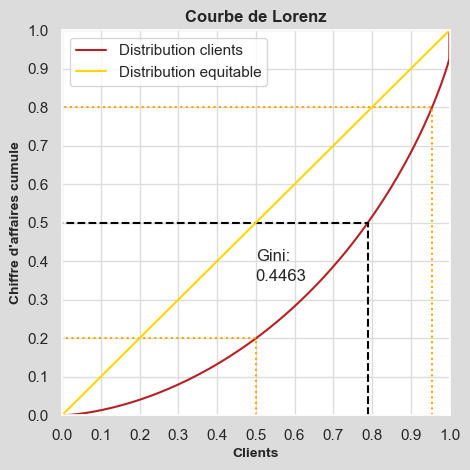

In [170]:
# plot Lorenz curve
sns.set(rc={'figure.figsize':(5, 5),'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})
graph29 = sns.lineplot(data=CA_val_cli, x='client_base_1', y='lorenz_value', color=col, label='Distribution clients')
graph29.set_title("Courbe de Lorenz", fontname='Arial', fontsize=12, fontweight='bold')
plt.xlabel('Clients', fontweight='bold' , fontsize=10)
plt.ylabel("Chiffre d'affaires cumule", fontweight='bold', fontsize=10)
plt.xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], rotation=0)
plt.xlim([0,1])
plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
plt.ylim([0, 1])
plt.grid(axis='both', color='gainsboro')

# adding text inside the plot
plt.text(0.50, 0.40, 'Gini:',fontsize=12)
plt.text(0.50, 0.35, round(gini,4), fontsize=12)

# plot 20-80 lines for readability
x_20_2 = [product20_2, product20_2, 0]
y_20_2 = [0, lorenz20_2, lorenz20_2]
plt.plot(x_20_2, y_20_2, linestyle='dotted', color='orange')
x_80_2 = [product80_2, product80_2, 0]
y_80_2 = [0, lorenz80_2, lorenz80_2]
plt.plot(x_80_2, y_80_2, linestyle='dotted', color='orange')

# plot mediale
x_50_2 = [product50_2, product50_2, 0]
y_50_2 = [0, lorenz50_2, lorenz50_2]
plt.plot(x_50_2, y_50_2, linestyle='dashed', color='black')

# plot first bisector
origin = [0, 0]
limit = [1, 1]
x_values = [origin[0], limit[0]]
y_values = [origin[1], limit[1]]
plt.plot(x_values, y_values, 'gold', label='Distribution equitable')
plt.legend(loc="upper left")

plt.savefig("graph29.png", bbox_inches='tight')
plt.show()

#### Les depenses realisees par les clients sont distribuees de facon assez inegalitaire, avec 50% des clients realisant juste 20% du chiffre d'affaires et les 20% des plus gros clients en realisant plus de 50%. Le chiffre d'affaires medial se situe aux environs de 78% des clients.
#### Les clients n'ayant jamais effectue d'achats en ligne n'ont pas ete inclus dans ces calculs, leur faible nombre (20 sur un total de 8600 clients) n'etant pas significatif (<3‰)

##### 3.1.3.4.2 - Excluant les clients professionnels

In [171]:
# calculate number of unique clients
nb_cli_indiv = len(CA_val_cli_indiv['client_id_sales'].unique())
nb_cli_indiv

8596

In [172]:
# create data for Lorenz curve graph
CA_val_cli_indiv.sort_values(("amount_spent", "sum"), inplace=True, ascending=True)
CA_val_cli_indiv['amount_spent_cum'] = np.cumsum(CA_val_cli_indiv['amount_spent'])
CA_val_cli_indiv['lorenz_value'] = CA_val_cli_indiv['amount_spent_cum'] / dep_tot_indiv[0]
CA_val_cli_indiv['client_count'] = np.arange(CA_val_cli_indiv.shape[0])+1
CA_val_cli_indiv['client_base_1'] = CA_val_cli_indiv['client_count']/nb_cli_indiv

In [173]:
# create data for 80-20 dotted line plot
# 80% du CA cumule
CA_val_cli_indiv_LG_sort80 = CA_val_cli_indiv.iloc[(CA_val_cli_indiv['lorenz_value']-0.8).abs().argsort()[:1]]

# for values
lorenz80_3 = CA_val_cli_indiv_LG_sort80['lorenz_value'].tolist()[0]

# for index
index80_3 = CA_val_cli_indiv_LG_sort80.index.tolist()[0]

# % produits correspondants a 80% du CA cumule
product80_3 = CA_val_cli_indiv.loc[index80_3, 'client_base_1'].values[0]

# 20% du CA cumule
CA_val_cli_indiv_LG_sort20 = CA_val_cli_indiv.iloc[(CA_val_cli_indiv['lorenz_value']-0.2).abs().argsort()[:1]]

# for values
lorenz20_3 = CA_val_cli_indiv_LG_sort20['lorenz_value'].tolist()[0]

# for index
index20_3 = CA_val_cli_indiv_LG_sort20.index.tolist()[0]

# % produits correspondants a 20% du CA cumule
product20_3 = CA_val_cli_indiv.loc[index20_3, 'client_base_1'].values[0]

print('lorenz80 = ', lorenz80_3, '\nindex80 = ', index80_3, '\nproduct80 = ', product80_3, '\nlorenz20 = ',
      lorenz20_3, '\nindex20 = ', index20_3, '\nproduct20 = ', product20_3)


# create data for medial
# 50% du CA cumule
CA_val_cli_indiv_LG_sort50 = CA_val_cli_indiv.iloc[(CA_val_cli_indiv['lorenz_value']-0.5).abs().argsort()[:1]]

# for values
lorenz50_3 = CA_val_cli_indiv_LG_sort50['lorenz_value'].tolist()[0]

# for index
index50_3 = CA_val_cli_indiv_LG_sort50.index.tolist()[0]

# % produits correspondants a 80% du CA cumule
product50_3 = CA_val_cli.loc[index50_3, 'client_base_1'].values[0]

print("Chiffre d'affaires medial atteint avec", round(product50_3*100, 2), "% des clients.")

lorenz80 =  0.7999576629770145 
index80 =  2661 
product80 =  0.9292694276407631 
lorenz20 =  0.2000444992322371 
index20 =  1192 
product20 =  0.4806886924150768
Chiffre d'affaires medial atteint avec 76.21 % des clients.


In [174]:
# calculate area under Lorenz curve
area2 = CA_val_cli_indiv['lorenz_value'].sum() / nb_cli_indiv

# calculate Gini coefficient
S2 = (0.5 - area2)
gini2 = S2 * 2
print("Coefficient de Gini:", round(gini2,4))

Coefficient de Gini: 0.4025


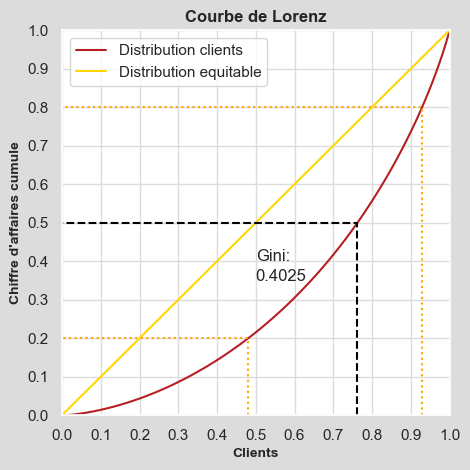

In [175]:
# plot Lorenz curve
sns.set(rc={'figure.figsize':(5,5),'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})
graph30 = sns.lineplot(data=CA_val_cli_indiv, x='client_base_1', y='lorenz_value', color=col, label='Distribution clients')
graph30.set_title("Courbe de Lorenz", fontname='Arial', fontsize=12, fontweight='bold')
plt.xlabel('Clients', fontweight='bold', fontsize=10)
plt.ylabel("Chiffre d'affaires cumule", fontweight='bold', fontsize=10)
plt.xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], rotation=0)
plt.xlim([0,1])
plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
plt.ylim([0,1])
plt.grid(axis='both', color='gainsboro')

# adding text inside the plot
plt.text(0.50, 0.40, 'Gini:',fontsize=12)
plt.text(0.50, 0.35, round(gini2,4), fontsize=12)

# plot first bisector
origin2 = [0, 0]
limit2 = [1, 1]
x_values = [origin2[0], limit2[0]]
y_values = [origin2[1], limit2[1]]
plt.plot(x_values, y_values, 'gold', label='Distribution equitable')
plt.legend(loc="upper left")

# plot 20-80 lines for readability
x_20_3 = [product20_3, product20_3, 0]
y_20_3 = [0, lorenz20_3, lorenz20_3]
plt.plot(x_20_3, y_20_3, linestyle='dotted', color='orange')
x_80_3 = [product80_3, product80_3, 0]
y_80_3 = [0, lorenz80_3, lorenz80_3]
plt.plot(x_80_3, y_80_3, linestyle='dotted', color='orange')

# plot mediale
x_50_3 = [product50_3, product50_3, 0]
y_50_3 = [0, lorenz50_3, lorenz50_3]
plt.plot(x_50_3, y_50_3, linestyle='dashed', color='black')

plt.savefig("graph30.png", bbox_inches='tight')
plt.show()

## 3.2 - Analyse des comportements des clients

#### 3.2.1 - Genre et categories de livres achetes

In [176]:
prod = CA_cli.loc[CA_cli['product_id_sales'] == '0_2245']
len(prod)

221

In [177]:
# create contingency table for client gender and book categories (empirical distribution)
CA_cli_cat_MF = pd.crosstab(CA_cli['gender_clients'], CA_cli['category_books'], margins=True, margins_name="Total")
CA_cli_cat_MF

category_books       0       1      2   Total
gender_clients                               
f               206220  114899  17283  338402
m               209460  112270  19200  340930
Total           415680  227169  36483  679332

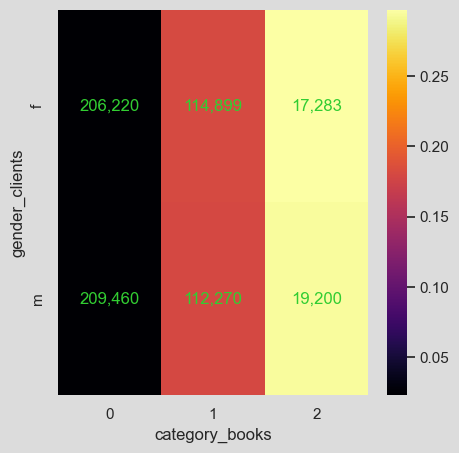

In [178]:
# create table of theoretical distribution based on marginal frequencies

# select total column
freq_genre = CA_cli_cat_MF.loc[:, ["Total"]]

# select total line
freq_cat = CA_cli_cat_MF.loc[["Total"], :]

# calculate number of observations in sample
n2 = CA_cli.shape[0]

# divide by number of observations to find theoretical distribution table
dist_theo = freq_genre.dot(freq_cat) / n2
dist_calc = (CA_cli_cat_MF-dist_theo)**2/dist_theo
chi_2 = dist_calc.sum().sum()
dist_norm = dist_calc/chi_2
sns.set(rc={'figure.figsize':(5,5),'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})
graph31 = sns.heatmap(dist_norm.iloc[:-1, :-1], annot=CA_cli_cat_MF.iloc[:-1, :-1],cmap='inferno', fmt=',d',
            annot_kws={"size": 12, "color":'limegreen'})

plt.savefig("graph31.png", bbox_inches='tight')

plt.show()

#### On cherche a savoir si les categories de livres achetees sont independantes du genre du client. Ces 2 variables etant qualitatives, un test du chi-2 de contingence est approprie. 
#### On pose H0 (hypothese nulle) : la distribution des observations est identique pour les 3 categories de livres aux frequences theoriques attendues, i.e. le genre du client n'affecte pas les categories de livres achetees; et
#### H1 (hypothese alternative) : la proportion de livres achetes dans chaque categorie depend du genre du client, i.e. les frequences observees different significativement des frequences theoriques attendues.
#### On pose egalement α = 5%

In [179]:
# select data from crosstable without total line and total column (otherwise p-value calculation is wrong)
CA_cli_cat_MF_vals = CA_cli_cat_MF.loc[:, CA_cli_cat_MF.columns != 'Total'].drop(index=["Total"])
CA_cli_cat_MF_vals

category_books       0       1      2
gender_clients                       
f               206220  114899  17283
m               209460  112270  19200

In [180]:
# perform contingent chi2 test for H0: variables are independant and risk level alpha=5%
alpha1 = 0.05
stat1,p1,dof1,expected1=st.chi2_contingency(CA_cli_cat_MF_vals)
print("La valeur du chi2 calcule est:", round(stat1,2))
print("La p-value est", p1)
print("Nombre de degres de liberte:",dof1)
print("La valeur du chi2 theorique est:",round(st.chi2.ppf(alpha1, dof1),4))
print("Distribution theorique:\n", np.round(expected1,0))
if p1 < alpha1:
    print('On rejette H0. Les variables ne sont pas independantes.')
else:
    print("Nous n'avons pas d'informations suffisantes pour rejeter H0,"
          "nous pouvons considerer les variables comme independantes.")
print(expected1.tofile("effectifs_theoriques.csv", sep=','))

La valeur du chi2 calcule est: 147.0
La p-value est 1.1989607410166063e-32
Nombre de degres de liberte: 2
La valeur du chi2 theorique est: 0.1026
Distribution theorique:
 [[207067. 113162.  18174.]
 [208613. 114007.  18309.]]
On rejette H0. Les variables ne sont pas independantes.
None


In [181]:
# Calculate Cramer's V
min_dim = min(CA_cli_cat_MF_vals.shape) - 1  #-1 if numpy array w/o totals, -2 otherwise (data dimension doesn't include totals)
c_v = np.sqrt(chi_2/(n2*min_dim))
print("Le V de Cramer est:", round(c_v,4))

Le V de Cramer est: 0.0147


#### Le chi2 et sa p-value permettent de tester l'existence d'un lien entre 2 variables qualitatives mais ne disent rien de l'intensite du lien s'il existe. On utilise le V de Cramer pour carateriser cette intensite.
#### Le V de Cramer etant tres proche de 0, on en conclut que, bien que les differences entre les variables qualitatives genre et categorie de livres soient statistiquement significatives, la dependance entre ces deux variables est en fait tres faible et (d'apres la heatmap) les livres de categorie 2 contribuent le plus a cette tres faible non-independance.

#### 3.2.2 - Age et montant total des achats

In [182]:
# create client table excluding large professional clients 
CA_cli_indiv = CA_cli.loc[(CA_cli['client_id_sales'] != 'c_3454') & (CA_cli['client_id_sales'] != 'c_6714')
                                  & (CA_cli['client_id_sales'] != 'c_4958')
                                  & (CA_cli['client_id_sales'] != 'c_1609')].copy()

# total purchases by age range
tot_sales_age_range = CA_cli_indiv.groupby(['age_range_clients'])['price_books'].sum().reset_index()
print(tot_sales_age_range.to_csv("tot_sales_age_range.csv", index=False))
print("Achats totaux par tranche d'age en €: \n", tot_sales_age_range)

None
Achats totaux par tranche d'age en €: 
   age_range_clients  price_books
0             15-24   1514681.30
1             25-34   2169260.51
2             35-49   4099959.07
3             50-64   2044163.09
4               65+   1146822.01


In [183]:
# number of purchases by age range
nb_sales_age_range = CA_cli_indiv.groupby(['age_range_clients'])['product_id_sales'].count().reset_index()
print(nb_sales_age_range.to_csv("nb_sales_age_range.csv", index=False))
print("Nombre de transactions par tranche d'age: \n", nb_sales_age_range)

None
Nombre de transactions par tranche d'age: 
   age_range_clients  product_id_sales
0             15-24             37820
1             25-34             87911
2             35-49            309876
3             50-64            128536
4               65+             68546


In [184]:
# average purchase amount by age range
avg_sales_age_range = CA_cli_indiv.groupby(['age_range_clients'])['price_books'].mean().reset_index()
print(avg_sales_age_range.to_csv("avg_sales_age_range.csv", index=False))
print("Achats moyens par tranche d'age en €: \n", avg_sales_age_range)

None
Achats moyens par tranche d'age en €: 
   age_range_clients  price_books
0             15-24    40.049744
1             25-34    24.675644
2             35-49    13.230967
3             50-64    15.903429
4               65+    16.730692


In [185]:
# number of clients by age range
nb_cli_age_range_tot =clients_pyr_2.groupby('age_range_clients')['client_count'].sum().reset_index()
print(nb_cli_age_range_tot.to_csv("nb_cli_age_range_tot.csv", index=False))
print("Nombre de clients par tranche d'age: \n", nb_cli_age_range_tot)

None
Nombre de clients par tranche d'age: 
   age_range_clients  client_count
0             15-24          1155
1             25-34          1566
2             35-49          2633
3             50-64          1991
4               65+          1276


#### Les 15-24 ans et les 25-34 ans depensent le plus par achat mais ils realisent moins de transactions que les 35-49 ans et les 50-64ans, probablement car leurs effectifs totaux dans notre pool de clients sont moindres que ces 2 classes. Il pourrait dont etre pertinent d'organiser des campagnes marketing ciblant les 2 classes de moins de 35 ans pour augmenter leur proportion dans le total de nos clients.

In [186]:
# create data for plot total purchases against clients ages
CA_cli_age = CA_cli_indiv.groupby(['age_clients', 'client_id_sales','age_range_clients'])['price_books'].sum().reset_index()
CA_cli_age_tot = CA_cli_indiv.groupby(['age_clients'])['price_books'].sum().reset_index()
CA_cli_age_range = CA_cli_indiv.groupby(['age_range_clients', 'client_id_sales'])['price_books'].sum().reset_index()


#### L'age des clients n'etant pas distribue selon une loi normale, 	on utilise donc un test non-parametrique pour evaluer la correlation entre ces 2 variables quantitatives: on calcule le rho de Spearman, qui est un coefficient de correlation sur les rangs d’echelles ordinales (non-lineaire, contrairement au coefficient de Pearson qui est son equivalent parametrique) et qui mesure la relation monotone entre deux variables i.e. le fait que lorsqu’une variable augmente, l’autre diminue toujours (relation monotone decroissante) ou augmente toujours (relation monotone croissante). Ce coefficient est proche de zero si la relation n’est pas monotone, i.e. si lorsqu’une variable augmente, l’autre augmente parfois et diminue parfois.

In [187]:
# check for existence of non-linear correlation (Spearman coefficient)
rho10, p10 = st.spearmanr(CA_cli_age_tot["age_clients"],CA_cli_age_tot["price_books"])
print("Coefficient de correlation de Spearman:", '{:,.2f}'.format(rho10))
print("p-value:", '{:,.2f}'.format(p10))

Coefficient de correlation de Spearman: -0.87
p-value: 0.00


#### Le rho de Spearman est (tout comme le coefficient de Pearson) toujours compris entre -1 et 1 et s'interprete de la meme facon - plus le resultat est proche de 1 et plus les variables sont correlees (resp. -1 / inversement correlees); ici, rho vaut -0.87 et on peut donc conclure a l'existence d'une correlation negative d’intensite tres forte entre l'age des clients et le montant total des achats, caracterisee par une relation monotone decroissante.
#### La p-value est indiquee comme étant zero, ce qui signifie que ce resultat est significatif. Elle correspond a la p-value du test H0: il n'existe pas de correlation monotone entre ces variables contre l'alternative H1: il existe une correlation monotone entre ces variables. Au seuil de risque α = 1%, on rejette donc H0, et on considere le coefficient de Spearman comme significatif de l'existence d'une correlation monotone decroissante tres forte entre ces 2 variables.


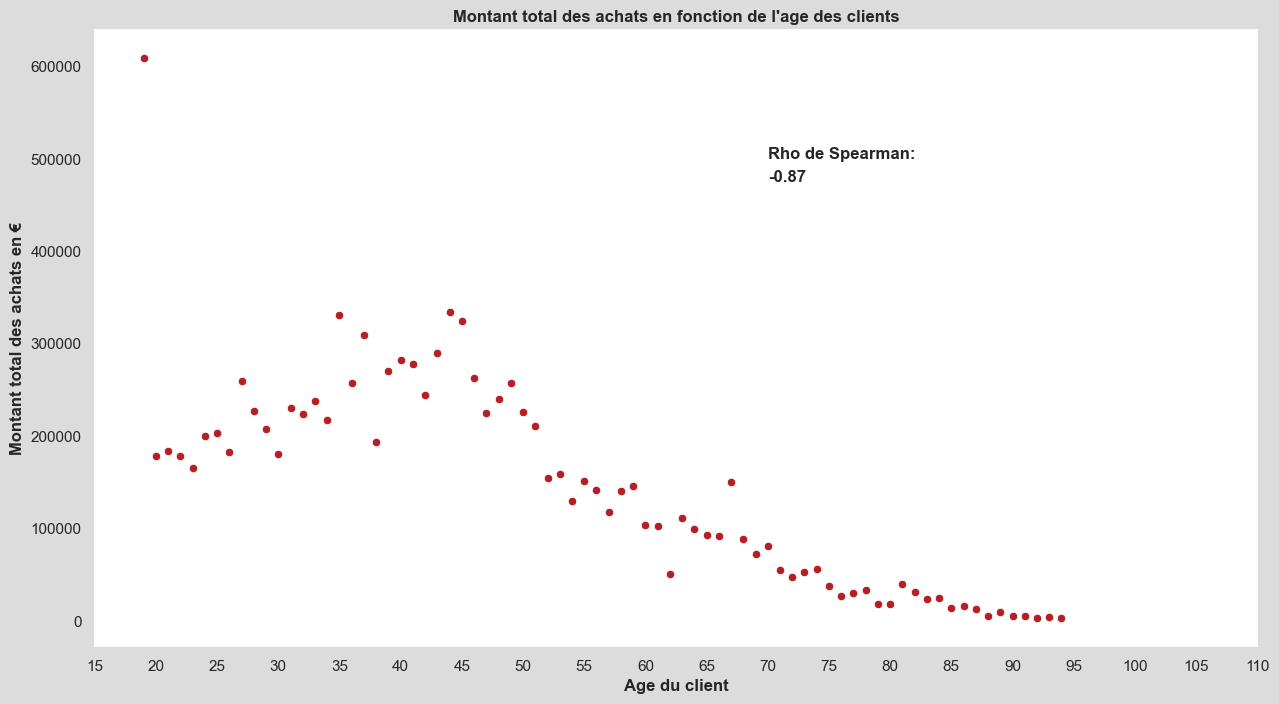

In [188]:
# plot total purchases against clients ages
sns.set(rc={'figure.figsize':(15, 8),'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})
graph32 = sns.scatterplot(data=CA_cli_age_tot, x='age_clients', y='price_books', alpha=1, color=col)                         
graph32.set_title("Montant total des achats en fonction de l'age des clients", fontname='Arial', fontsize=12,
                  fontweight='bold')
plt.xlabel('Age du client', fontweight='bold', fontsize=12)
plt.ylabel("Montant total des achats en €", fontweight='bold', fontsize=12)
plt.xticks([15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110], rotation=0)

#adding text inside the plot
plt.text(70, 500000, ("Rho de Spearman:") , fontsize=12, fontweight='bold')
plt.text(70, 475000, (round(rho10,2)) , fontsize=12, fontweight='bold')


plt.savefig("graph32.png", bbox_inches='tight')
plt.show()

#### 3.2.3 - Age et frequence d'achat (nombre de livres lus par an)

In [189]:
# create data for plot client age against purchase frequency
CA_cli_age_freq = CA_cli_indiv.groupby(['client_id_sales', 'age_clients', 'age_range_clients']).agg(
    {'price_books' : ['sum'], 'session_id_sales' : ['count']}).reset_index()
CA_cli_age_freq.rename(columns={'price_books': 'amount_spent', 'session_id_sales':'books_purchased'}, inplace=True)
CA_cli_age_freq2 = CA_cli_age_freq.copy()
CA_cli_age_freq2['books_per_year'] = CA_cli_age_freq2['books_purchased']/2
CA_cli_age_freq2.loc[(CA_cli_age_freq2['books_per_year'] > 0)
                     & (CA_cli_age_freq2['books_per_year'] <= 5), 'reader_class'] = "Petits lecteurs"
CA_cli_age_freq2.loc[(CA_cli_age_freq2['books_per_year'] > 5)
                     & (CA_cli_age_freq2['books_per_year'] <= 20), 'reader_class'] = "Lecteurs moyens"
CA_cli_age_freq2.loc[(CA_cli_age_freq2['books_per_year'] > 20)
                     & (CA_cli_age_freq2['books_per_year'] <= 52), 'reader_class'] = "Grands lecteurs"
CA_cli_age_freq2.loc[(CA_cli_age_freq2['books_per_year'] > 52)
                     & (CA_cli_age_freq2['books_per_year'] <= 104), 'reader_class'] = "Tres grands lecteurs"
CA_cli_age_freq2.loc[(CA_cli_age_freq2['books_per_year'] > 104)
                     & (CA_cli_age_freq2['books_per_year'] <= 1000), 'reader_class'] = "Collectionneurs"
CA_cli_age_freq2.loc[(CA_cli_age_freq2['books_per_year'] > 1000), 'reader_class'] = "Clients professionnels"

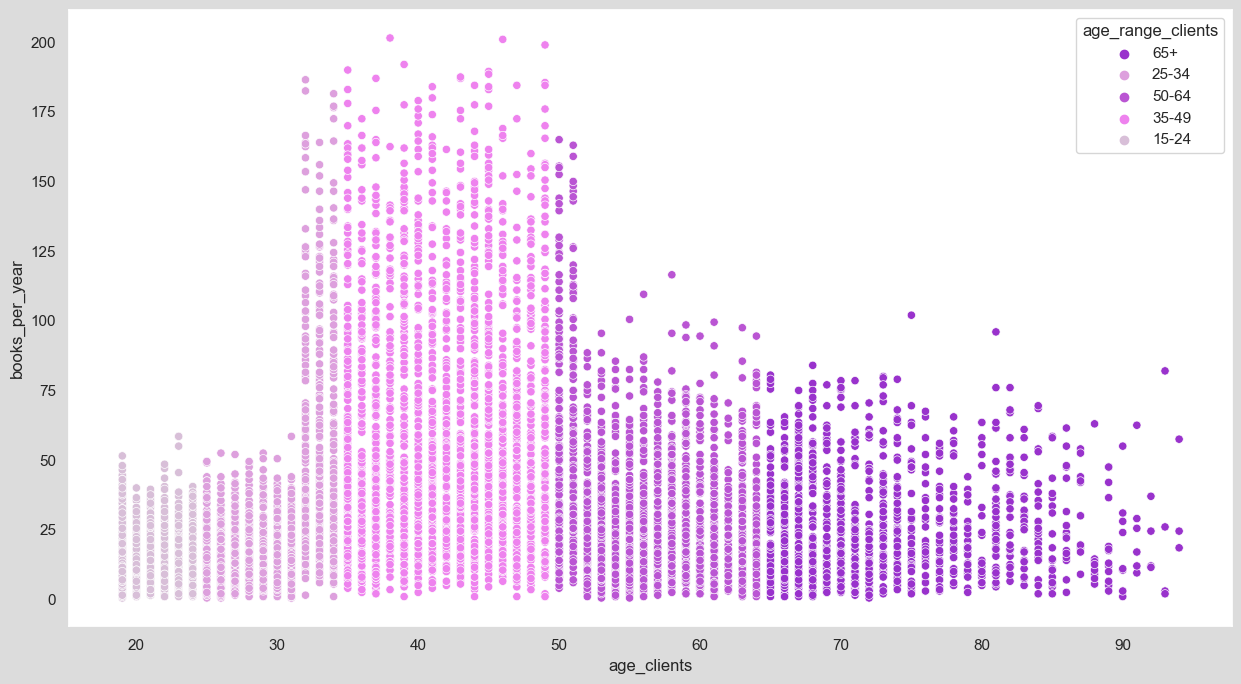

In [190]:
# plot client age against purchase frequency
sns.set(rc={'figure.figsize':(15, 8),'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})
graph33 = sns.scatterplot(data=CA_cli_age_freq2, x='age_clients', y='books_per_year',hue='age_range_clients',
                          palette=['darkorchid','plum','mediumorchid','violet','thistle'])
plt.savefig("graph33.png", bbox_inches='tight')
plt.show()

#### Il semblerait que toutes les classes d'age n'aient pas les memes habitudes d'achat en termes de frequence.

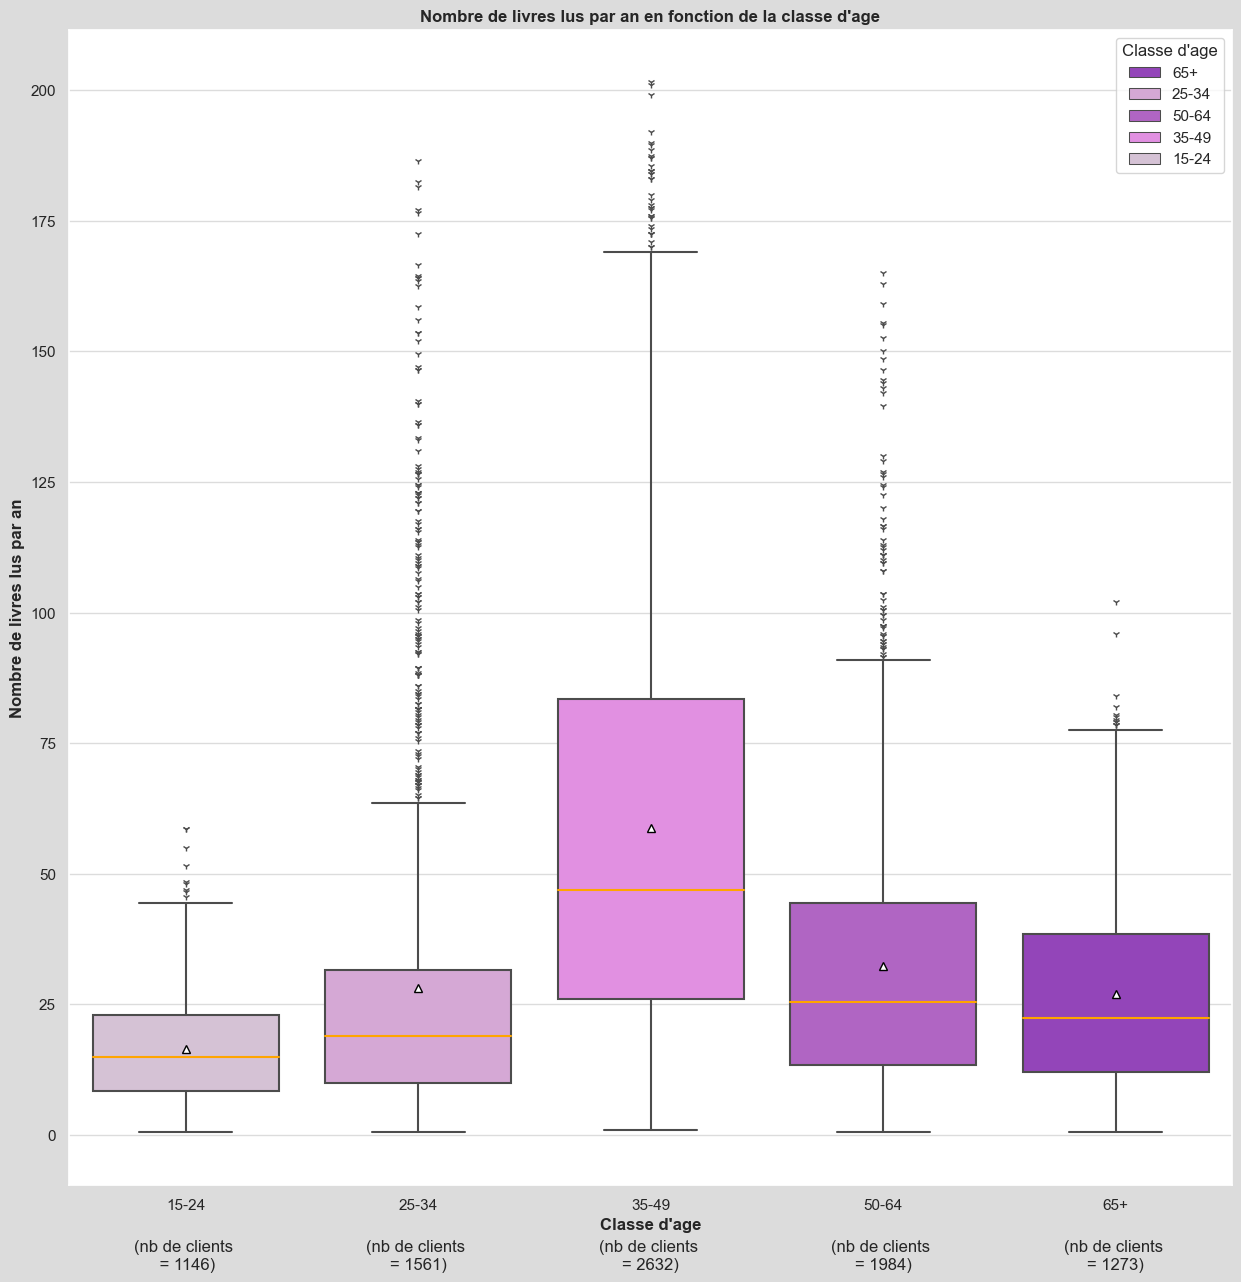

In [191]:
# plot number of books bought per year against client age range on a box plot
sns.set(rc={'figure.figsize':(15, 15), 'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})
graph34 = sns.boxplot(data=CA_cli_age_freq2, x="age_range_clients", y="books_per_year", hue="age_range_clients",
                       flierprops={"marker": "1"}, medianprops={"color" : "orange"},
                       meanprops={"markerfacecolor":"white", "markeredgecolor":"black"}, orient="v", color=col,
                       showmeans=True, dodge=False, order=['15-24', '25-34', '35-49', '50-64', '65+'],
                       palette=['darkorchid','plum','mediumorchid','violet','thistle'])
plt.xlabel("Classe d'age", fontweight='bold', fontsize=12)
plt.ylabel('Nombre de livres lus par an', fontweight='bold', fontsize=12)
plt.title("Nombre de livres lus par an en fonction de la classe d'age", fontweight='bold', fontsize=12)
plt.legend(title="Classe d'age")
plt.grid(axis='y', color='gainsboro')

# add number of clients for each age range
nb_cli_BP = CA_cli_age_freq2.groupby('age_range_clients')['client_id_sales'].count().reset_index()
plt.text(0, -20,"(nb de clients \n = {})".format(nb_cli_BP.iloc[0, 1]), horizontalalignment='center', verticalalignment='top')  
plt.text(1, -20,"(nb de clients \n= {})".format(nb_cli_BP.iloc[1, 1]), horizontalalignment='center', verticalalignment='top')
plt.text(2, -20,"(nb de clients \n= {})".format(nb_cli_BP.iloc[2, 1]), horizontalalignment='center', verticalalignment='top')
plt.text(3, -20,"(nb de clients \n= {})".format(nb_cli_BP.iloc[3, 1]), horizontalalignment='center', verticalalignment='top')
plt.text(4, -20,"(nb de clients \n= {})".format(nb_cli_BP.iloc[4, 1]), horizontalalignment='center', verticalalignment='top')



plt.savefig("graph34.png", bbox_inches='tight')


#### Il semble que le nombre median de livres lus par an n'est pas identique parmi nos 5 classes d'age. Verifions cette hypothese par un test statistique. Comme nous cherchons a analyser la relation entre une variable qualitative et une variable quantitative, mais que l'age des clients n'est pas distribue selon une loi normale, le test ANOVA n'est pas approprie ici et nous utiliserons le test non-parametrique de Kruskal-Wallis, qui est une generalisation du test de Mann-Whitney a plus de 2 populations (les populations etant ici nos groupes de lecteurs dans chaque classe d'age).
#### On pose H0 : le nombre median de livres lus par an est le meme pour toutes les classes d'age, que nous testons contre l'hypothese alternative H1 : le nombre median de livres d'au moins une  classes d'age est different de celui des 2 autres, a un seuil α = 5%.

In [192]:
# Kruskal-Wallis test
groupednumbers4 = {grp4: CA_cli_age_freq2['books_per_year'][CA_cli_age_freq2['age_range_clients']==grp4].values for grp4 in CA_cli_age_freq2[
    'age_range_clients'].unique()}
# print(groupednumbers4)
args4 = groupednumbers4.values()
args4 = [groupednumbers4[grp4] for grp4 in sorted(CA_cli_age_freq2['age_range_clients'].unique())]
stat42, p42 = st.kruskal(*args4)
print("Stat:", stat42)
print("p-value:", "{:e}".format(p42))

Stat: 1834.9450615796056
p-value: 0.000000e+00


#### On rejette donc l'hypothese nulle, au moins une classe d'age a une mediane du nombre de livres lus par an differente des 4 autres.

In [193]:
# perform Dunn's post-hoc test to see which group(s) differ
args4[0] = args4[0].tolist()
args4[1] = args4[1].tolist()
args4[2] = args4[2].tolist()
args4[3] = args4[3].tolist()
args4[4] = args4[4].tolist()
data5 = [args4[0], args4[1], args4[2],  args4[3], args4[4]]
dunn5 = sp.posthoc_dunn(data5, p_adjust=None, sort=False)
print(dunn5.to_csv("dunn5.csv", index=False))
dunn5

None


1              2              3              4              5
1   1.000000e+00   2.376036e-20  1.061068e-307   8.045756e-70   6.536929e-34
2   2.376036e-20   1.000000e+00  1.876043e-201   2.286943e-18   3.603094e-04
3  1.061068e-307  1.876043e-201   1.000000e+00  5.272353e-113  2.083455e-131
4   8.045756e-70   2.286943e-18  5.272353e-113   1.000000e+00   7.307356e-06
5   6.536929e-34   3.603094e-04  2.083455e-131   7.307356e-06   1.000000e+00

#### Le test de Dunn donnant des p-values pour toutes les differences entre les classes d'age tres proches de zero, nous pouvons en conclure que toutes nos classes d'age ont des medianes du nombre de livres lus par an differentes au seuil α = 5%.

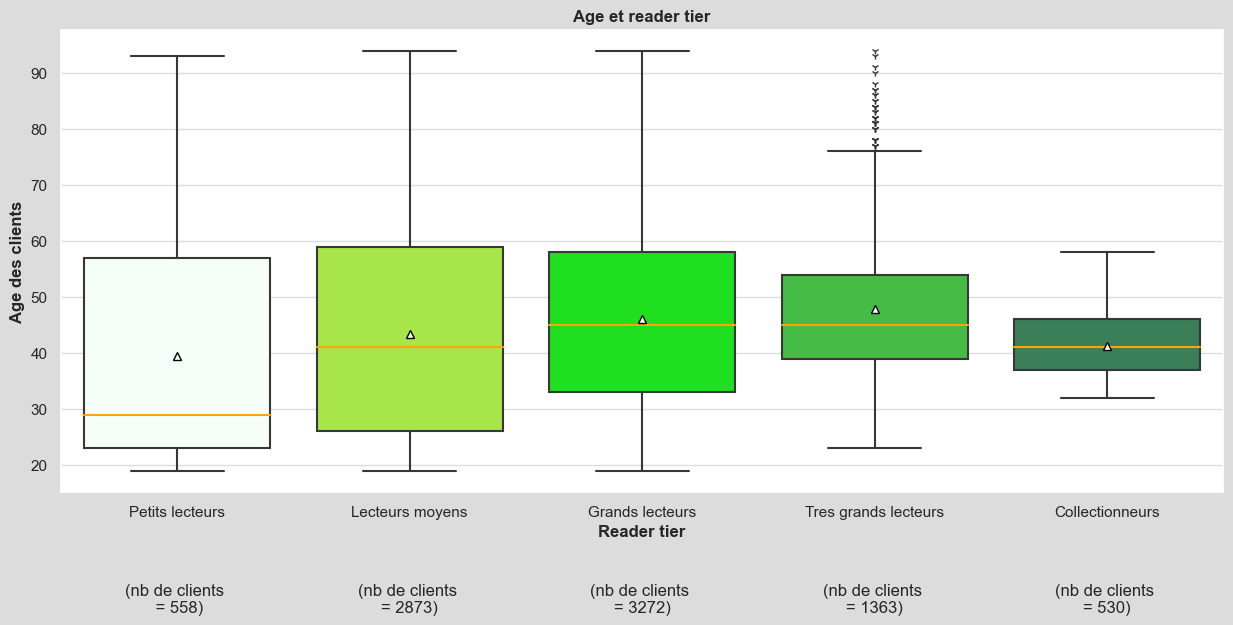

In [194]:
# create data for plot reader tier against client age range on a box plot
CA_age_tier= CA_cli_age_freq2.loc[:, ['age_clients', 'reader_class']]
CA_age_tier['reader_class'].value_counts()

# plot reader tier against client age range on a box plot
sns.set(rc={'figure.figsize':(15, 6), 'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})
graph35 = sns.boxplot(data=CA_age_tier, x="reader_class", y="age_clients",
                       flierprops={"marker": "1"}, medianprops={"color" : "orange"},
                       meanprops={"markerfacecolor":"white", "markeredgecolor":"black"}, orient="v", color=col,
                       showmeans=True, dodge=False, order=['Petits lecteurs', 'Lecteurs moyens', 'Grands lecteurs',
                                                           'Tres grands lecteurs','Collectionneurs'],
                       palette=['mintcream','greenyellow','lime','limegreen','seagreen'])
plt.xlabel("Reader tier", fontweight='bold', fontsize=12)
plt.ylabel('Age des clients', fontweight='bold', fontsize=12)
plt.title("Age et reader tier", fontweight='bold', fontsize=12)
plt.grid(axis='y', color='gainsboro')

# add number of clients for each reader tier
plt.text(0, -1,"(nb de clients \n = {})".format(CA_age_tier['reader_class'].value_counts()[3]), horizontalalignment='center',
          verticalalignment='top')  
plt.text(1, -1,"(nb de clients \n= {})".format(CA_age_tier['reader_class'].value_counts()[1]), horizontalalignment='center',
         verticalalignment='top')
plt.text(2, -1,"(nb de clients \n= {})".format(CA_age_tier['reader_class'].value_counts()[0]), horizontalalignment='center',
           verticalalignment='top')
plt.text(3, -1,"(nb de clients \n= {})".format(CA_age_tier['reader_class'].value_counts()[2]), horizontalalignment='center',
           verticalalignment='top')
plt.text(4, -1,"(nb de clients \n= {})".format(CA_age_tier['reader_class'].value_counts()[4]), horizontalalignment='center',
           verticalalignment='top')


plt.savefig("graph35.png", bbox_inches='tight')

#### Il semble que l'age median des lecteurs n'est pas identique parmi nos 5 reader tiers. Verifions cette hypothese par un test statistique. Comme nous cherchons a analyser la relation entre une variable qualitative et une variable quantitative, mais que l'age des clients n'etant pas distribue selon une loi normale, le test ANOVA n'est pas approprie ici et nous utiliserons le test non-parametrique de Kruskal-Wallis, qui est une generalisation du test de Mann-Whitney a plus de 2 populations (les populations etant ici nos groupes de lecteurs dans chaque reader tier).
#### On pose H0 : l'age median est le meme pour tous les reader tiers, que nous testons contre l'hypothese alternative H1 : l'age median d'au moins un reader tier est different de celui des 2 autres, a un seuil α = 5%.

In [195]:
CA_age_tier['age_clients'] = CA_age_tier['age_clients'].astype(float)

In [196]:
# Kruskal-Wallis test
groupednumbers2 = {grp2: CA_age_tier['age_clients'][CA_age_tier['reader_class']==grp2].values for grp2 in CA_age_tier[
    'reader_class'].unique()}
args2 = groupednumbers2.values()
args2 = [groupednumbers2[grp2] for grp2 in sorted(CA_age_tier['reader_class'].unique())]
stat12, p12 = st.kruskal(*args2)
print("Stat:", stat12)
print("p-value:", "{:e}".format(p12))

Stat: 211.1079212441607
p-value: 1.534854e-44


#### On rejette donc l'hypothese nulle, au moins un reader tier a un age median d'achat different des 4 autres.

In [197]:
# perform Dunn's post-hoc test to see which group(s) differ
args2[0] = args2[0].tolist()
args2[1] = args2[1].tolist()
args2[2] = args2[2].tolist()
args2[3] = args2[3].tolist()
args2[4] = args2[4].tolist()
data3 = [args2[0], args2[1], args2[2],  args2[3], args2[4]]
dunn3 = sp.posthoc_dunn(data3, p_adjust=None, sort=False)
print(dunn3.to_csv("dunn3.csv", index=False))
dunn3

None


1             2             3             4             5
1  1.000000e+00  2.408743e-07  3.173122e-01  7.808226e-04  1.275648e-13
2  2.408743e-07  1.000000e+00  2.754120e-14  2.270569e-22  2.017986e-05
3  3.173122e-01  2.754120e-14  1.000000e+00  5.746845e-08  5.891922e-24
4  7.808226e-04  2.270569e-22  5.746845e-08  1.000000e+00  4.085135e-31
5  1.275648e-13  2.017986e-05  5.891922e-24  4.085135e-31  1.000000e+00

####  Le test de Dunn donnant des p-values pour toutes les differences entre les reader tiers tres proches de zero sauf entre les categories 1 et 3, nous pouvons en conclure que tous nos reader tiers on des medianes differentes au seuil α = 5% sauf les grands et les tres grands lecteurs.

#### 3.2.4 - Age et taille du panier moyen

##### 3.2.4.1 - En volume (nombre de livres dans le panier)

In [198]:
session_min = sales_trim.groupby('session_id_sales')['date_sales'].min().reset_index()
session_min.rename(columns={'date_sales': 'session_start'}, inplace=True)
session_max = sales_trim.groupby('session_id_sales')['date_sales'].max().reset_index()
session_max.rename(columns={'date_sales': 'session_end'}, inplace=True)
session_length = pd.merge(session_max, session_min, how='left', right_on='session_id_sales', left_on='session_id_sales')
session_length['session_end'] = pd.to_datetime(session_length['session_end'])
session_length['session_start'] = pd.to_datetime(session_length['session_start'])
session_length['session_duration'] = session_length['session_end'] - session_length['session_start']
session_length['session_duration'] = pd.to_timedelta(session_length['session_duration'])
session_length['session_duration'] = session_length['session_duration'].dt.total_seconds()
mini = session_length['session_duration'].min()
maxi = session_length['session_duration'].max()
CA_cli_session = pd.merge(CA_cli_indiv, session_length, how='left', left_on='session_id_sales', right_on='session_id_sales')
CA_cli_session_panier = CA_cli_session.groupby(['session_id_sales', 'client_id_clients',
                                                'session_duration', 'age_clients', 'age_range_clients']
                                              )['product_id_sales'].count().reset_index()

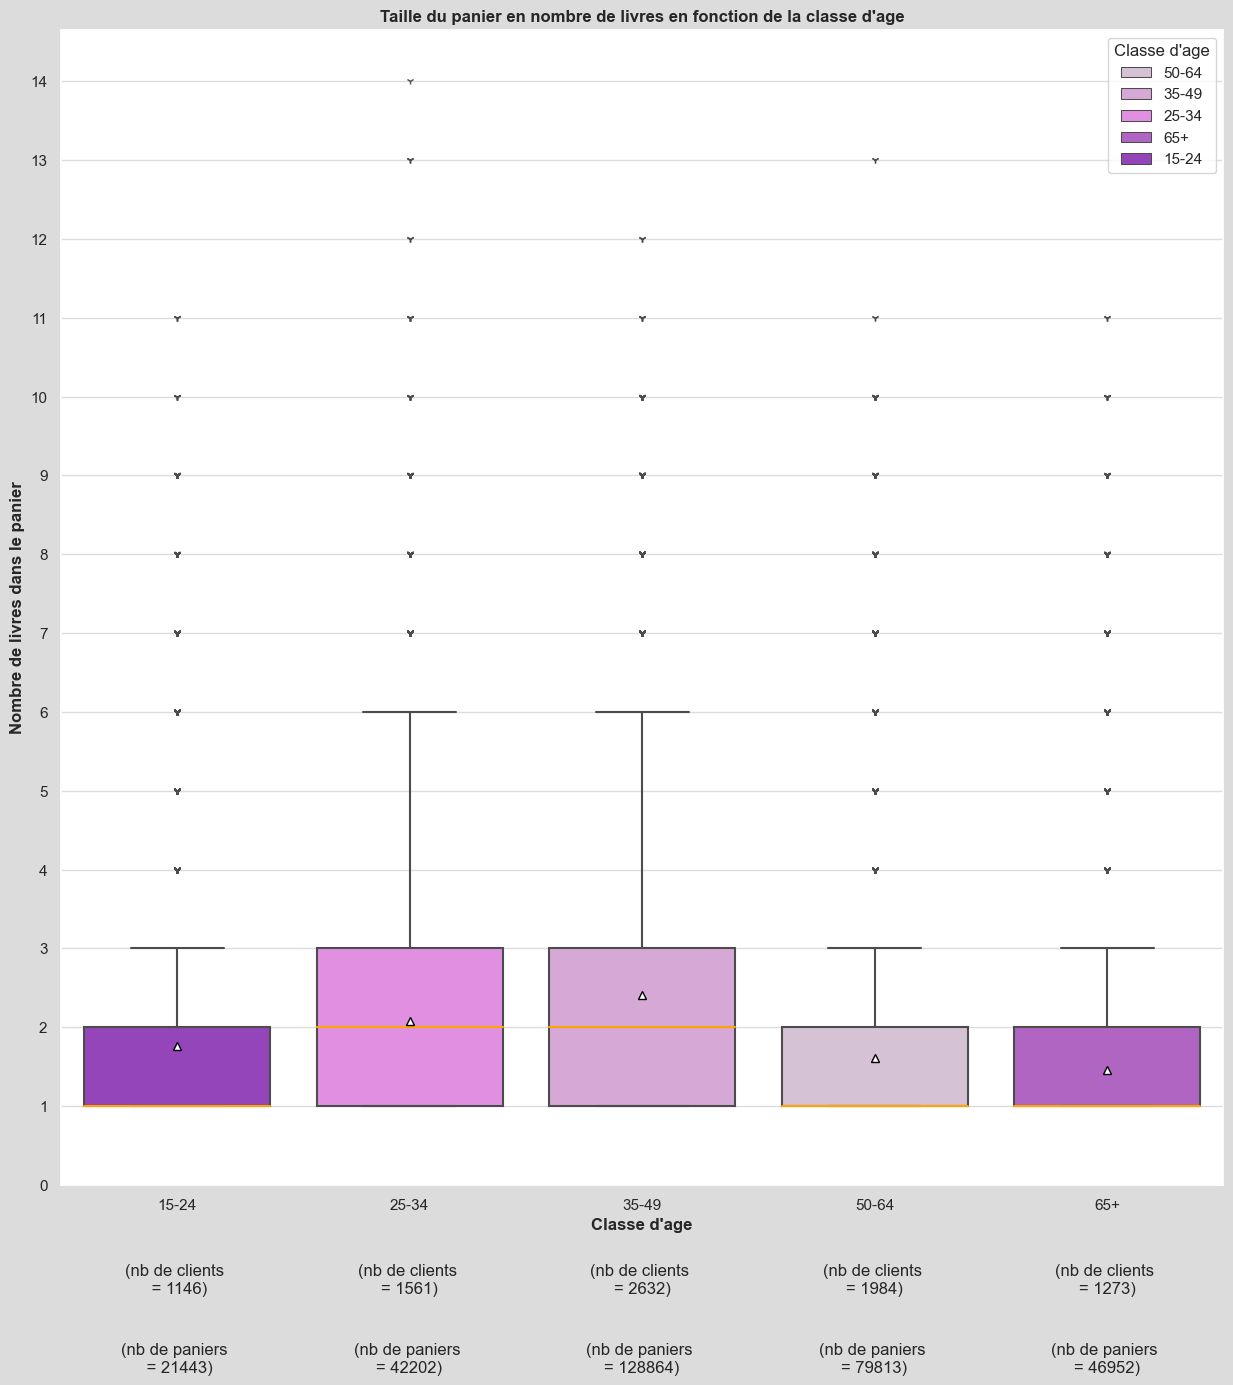

In [199]:
# plot number of books bought in basket against client age range on a box plot
sns.set(rc={'figure.figsize':(15, 15), 'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})
graph36 = sns.boxplot(data=CA_cli_session_panier, x="age_range_clients", y="product_id_sales", hue="age_range_clients",
                       flierprops={"marker": "1"}, medianprops={"color" : "orange"},
                       meanprops={"markerfacecolor":"white", "markeredgecolor":"black"}, orient="v", color=col,
                       showmeans=True, dodge=False, order=['15-24', '25-34', '35-49', '50-64', '65+'],
                       palette=['thistle','plum', 'violet','mediumorchid','darkorchid'])
plt.yticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14])
plt.xlabel("Classe d'age", fontweight='bold', fontsize=12)
plt.ylabel('Nombre de livres dans le panier', fontweight='bold', fontsize=12)
plt.title("Taille du panier en nombre de livres en fonction de la classe d'age", fontweight='bold', fontsize=12)
plt.legend(title="Classe d'age")
plt.grid(axis='y', color='gainsboro')

# add number of clients for each age range
plt.text(0, -1,"(nb de clients \n = {})".format(nb_cli_BP.iloc[0, 1]), horizontalalignment='center',
         verticalalignment='top')  
plt.text(1, -1,"(nb de clients \n= {})".format(nb_cli_BP.iloc[1, 1]), horizontalalignment='center',
         verticalalignment='top')
plt.text(2, -1,"(nb de clients \n= {})".format(nb_cli_BP.iloc[2, 1]), horizontalalignment='center',
         verticalalignment='top')
plt.text(3, -1,"(nb de clients \n= {})".format(nb_cli_BP.iloc[3, 1]), horizontalalignment='center',
         verticalalignment='top')
plt.text(4, -1,"(nb de clients \n= {})".format(nb_cli_BP.iloc[4, 1]), horizontalalignment='center',
         verticalalignment='top')


# add number of baskets for each age range
nb_cli_BP2 = CA_cli_session_panier.groupby('age_range_clients')['client_id_clients'].count().reset_index()
plt.text(0, -2,"(nb de paniers \n = {})".format(nb_cli_BP2.iloc[0, 1]), horizontalalignment='center',
         verticalalignment='top')  
plt.text(1, -2,"(nb de paniers \n= {})".format(nb_cli_BP2.iloc[1, 1]), horizontalalignment='center',
         verticalalignment='top')
plt.text(2, -2,"(nb de paniers \n= {})".format(nb_cli_BP2.iloc[2, 1]), horizontalalignment='center',
         verticalalignment='top')
plt.text(3, -2,"(nb de paniers \n= {})".format(nb_cli_BP2.iloc[3, 1]), horizontalalignment='center',
         verticalalignment='top')
plt.text(4, -2,"(nb de paniers \n= {})".format(nb_cli_BP2.iloc[4, 1]), horizontalalignment='center',
         verticalalignment='top')

plt.savefig("graph36.png", bbox_inches='tight')


#### L'age des clients ne suivant pas une loi normale, on utilise donc un test non-parametrique pour evaluer la correlation entre ces 2 variables quantitatives: on calcule le rho de Spearman, qui est un coefficient de correlation sur les rangs d’echelles ordinales (non-lineaire, contrairement au coefficient de Pearson qui est son equivalent parametrique) et qui mesure la relation monotone entre deux variables i.e. le fait que lorsqu’une variable augmente, l’autre diminue toujours (relation monotone decroissante) ou augmente toujours (relation monotone croissante). Ce coefficient est proche de zero si la relation n’est pas monotone, i.e. si lorsqu’une variable augmente, l’autre augmente parfois et diminue parfois.

In [200]:
# check for existence of non-linear correlation (Spearman coefficient)
rho3, p3 = st.spearmanr(CA_cli_session_panier["age_clients"],CA_cli_session_panier["product_id_sales"])
print("Coefficient de correlation de Spearman:", '{:,.2f}'.format(rho3))
print("p-value:", '{:,.2f}'.format(p3))


Coefficient de correlation de Spearman: -0.23
p-value: 0.00


#### Le rho de Spearman est (tout comme le coefficient de Pearson) toujours compris entre -1 et 1 et s'interprete de la meme facon - plus le resultat est proche de 1 et plus les variables sont correlees (resp. -1 / inversement correlees); ici, rho vaut -0.23 et on peut donc conclure a l'existence d'une correlation negative d’intensite faible entre ll'age des clients et le nombre de produits dans le panier, caracterisee par une relation monotone decroissante.
#### La p-value est indiquee comme étant zero, ce qui signifie que ce resultat est significatif. Elle correspond a la p-value du test H0: il n'existe pas de correlation monotone entre ces variables contre l'alternative H1: il existe une correlation monotone entre ces variables. Au seuil de risque α = 1%, on rejette donc H0, et on considere le coefficient de Spearman comme significatif de l'existence d'une correlation monotone decroissante faible entre ces 2 variables.


#### Aucune tendance claire ne se degage des boxplots, et le coefficient de Spearman reste relativement proche de zero ; il n'existe probablement pas une forte relation entre l'age des clients et le nombre de livres dans leur panier.

##### 3.2.4.2 - En valeur (montant du panier)

In [201]:
CA_cli_session_panier_MT= CA_cli_session.groupby(['session_id_sales', 'client_id_clients', 'session_duration', 'age_clients',
                                                  'age_range_clients'])['price_books'].sum().reset_index()

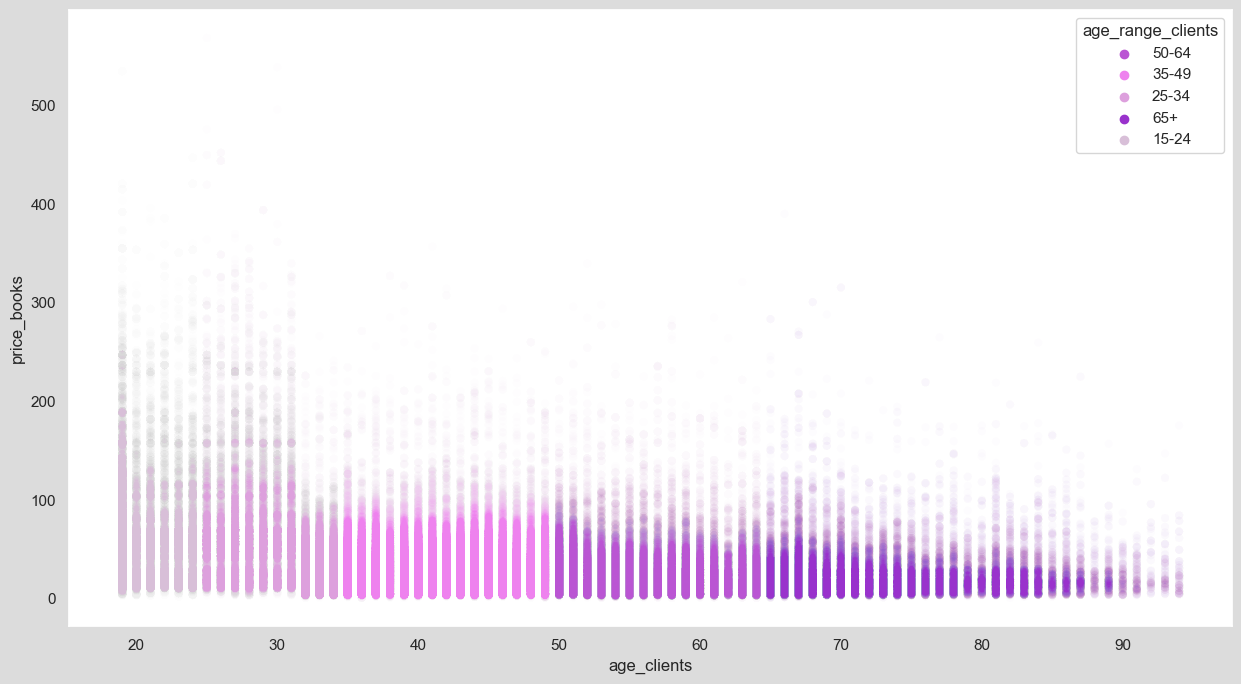

In [202]:
# plot basket size against client age
sns.set(rc={'figure.figsize':(15, 8),'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})
graph37 = sns.scatterplot(data=CA_cli_session_panier_MT, x='age_clients', y='price_books',alpha=0.01,
                           hue='age_range_clients', palette=['mediumorchid','violet','plum','darkorchid','thistle'])
plt.savefig("graph37.png", bbox_inches='tight')
plt.show()

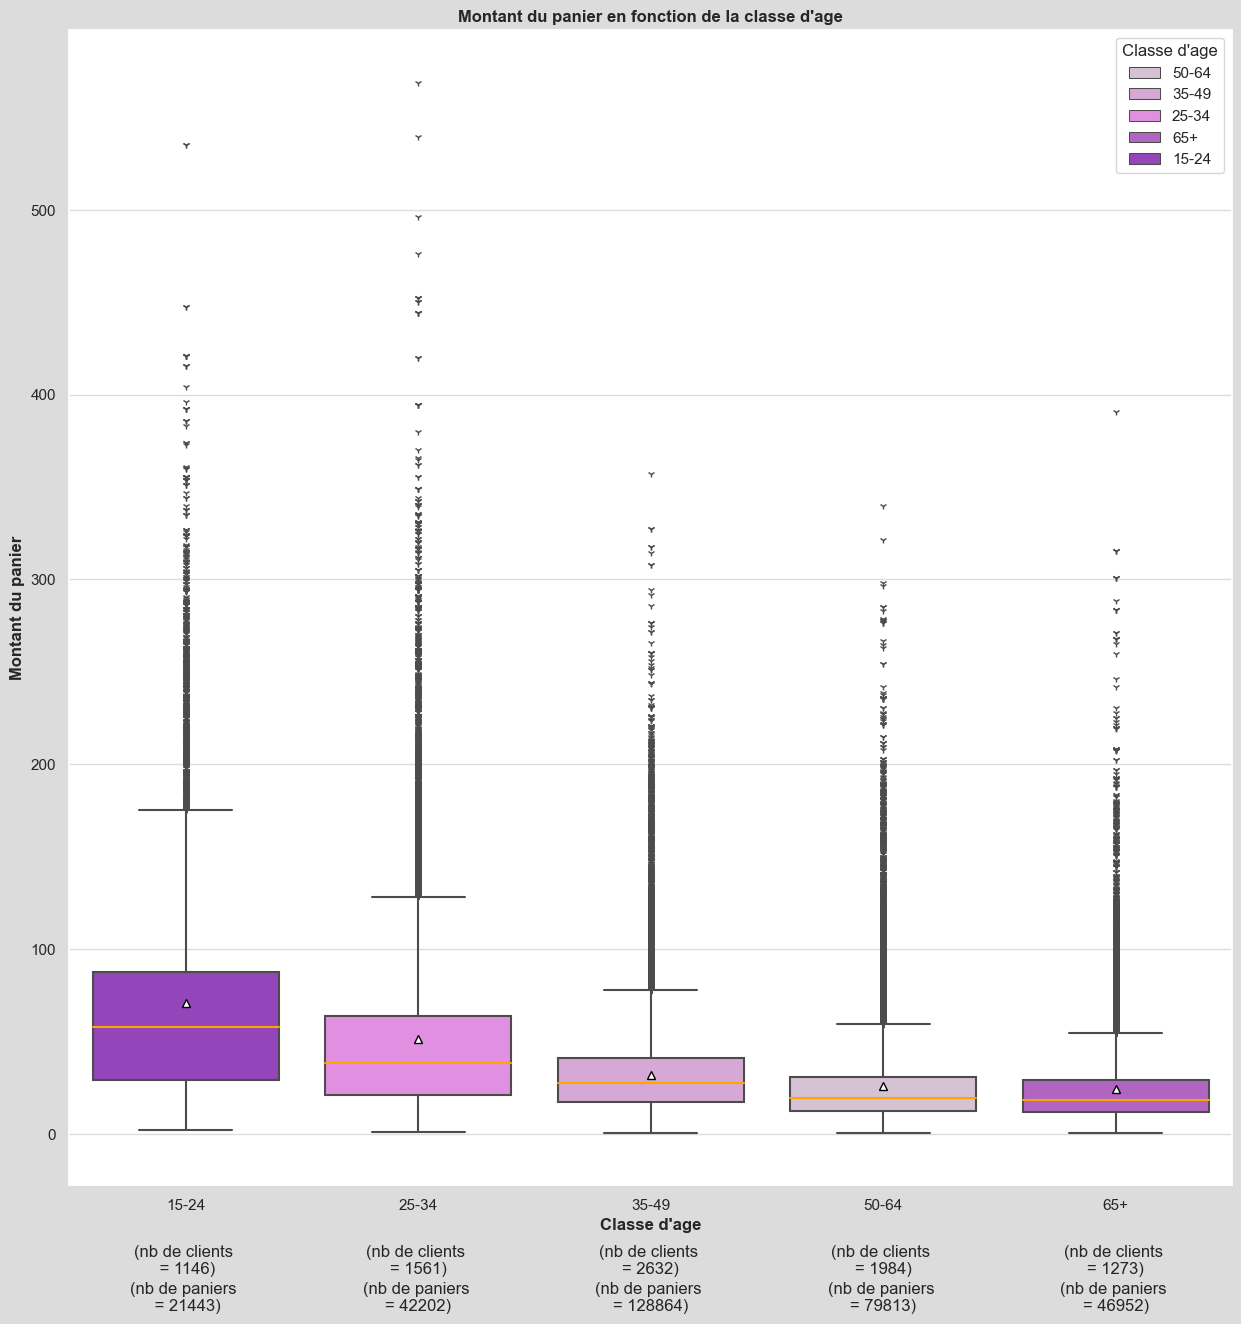

In [203]:
# plot basket size against client age range on a box plot
sns.set(rc={'figure.figsize':(15, 15), 'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})
graph38 = sns.boxplot(data=CA_cli_session_panier_MT, x="age_range_clients", y="price_books", hue="age_range_clients",
                       flierprops={"marker": "1"}, medianprops={"color" : "orange"},
                       meanprops={"markerfacecolor":"white", "markeredgecolor":"black"}, orient="v", color=col,
                       showmeans=True, dodge=False, order=['15-24', '25-34', '35-49', '50-64', '65+'],
                       palette=['thistle','plum', 'violet','mediumorchid','darkorchid'])
plt.xlabel("Classe d'age", fontweight='bold', fontsize=12)
plt.ylabel('Montant du panier', fontweight='bold', fontsize=12)
plt.title("Montant du panier en fonction de la classe d'age", fontweight='bold', fontsize=12)
plt.legend(title="Classe d'age")
plt.grid(axis='y', color='gainsboro')

# add number of clients for each age range
plt.text(0, -60,"(nb de clients \n = {})".format(nb_cli_BP.iloc[0, 1]), horizontalalignment='center', verticalalignment='top')  
plt.text(1, -60,"(nb de clients \n= {})".format(nb_cli_BP.iloc[1, 1]), horizontalalignment='center', verticalalignment='top')
plt.text(2, -60,"(nb de clients \n= {})".format(nb_cli_BP.iloc[2, 1]), horizontalalignment='center', verticalalignment='top')
plt.text(3, -60,"(nb de clients \n= {})".format(nb_cli_BP.iloc[3, 1]), horizontalalignment='center', verticalalignment='top')
plt.text(4, -60,"(nb de clients \n= {})".format(nb_cli_BP.iloc[4, 1]), horizontalalignment='center', verticalalignment='top')


# add number of baskets for each age range
plt.text(0, -80,"(nb de paniers \n = {})".format(nb_cli_BP2.iloc[0, 1]), horizontalalignment='center', verticalalignment='top')  
plt.text(1, -80,"(nb de paniers \n= {})".format(nb_cli_BP2.iloc[1, 1]), horizontalalignment='center', verticalalignment='top')
plt.text(2, -80,"(nb de paniers \n= {})".format(nb_cli_BP2.iloc[2, 1]), horizontalalignment='center', verticalalignment='top')
plt.text(3, -80,"(nb de paniers \n= {})".format(nb_cli_BP2.iloc[3, 1]), horizontalalignment='center', verticalalignment='top')
plt.text(4, -80,"(nb de paniers \n= {})".format(nb_cli_BP2.iloc[4, 1]), horizontalalignment='center', verticalalignment='top')

plt.savefig("graph38.png", bbox_inches='tight')

#### Le montant du panier semble decroitre avec la classe d'age.

#### L'age des clients n'etant pas distribue selon une loi normale, on utilise donc un test non-parametrique pour evaluer la correlation entre ces 2 variables quantitatives: on calcule le rho de Spearman, qui est un coefficient de correlation sur les rangs d’echelles ordinales (non-lineaire, contrairement au coefficient de Pearson qui est son equivalent parametrique) et qui mesure la relation monotone entre deux variables i.e. le fait que lorsqu’une variable augmente, l’autre diminue toujours (relation monotone decroissante) ou augmente toujours (relation monotone croissante). Ce coefficient est proche de zero si la relation n’est pas monotone, i.e. si lorsqu’une variable augmente, l’autre augmente parfois et diminue parfois.

In [204]:
# check for existence of non-linear correlation (Spearman coefficient)
rho4, p4 = st.spearmanr(CA_cli_session_panier_MT["age_clients"],CA_cli_session_panier_MT["price_books"])
print("Coefficient de correlation de Spearman:", '{:,.2f}'.format(rho4))
print("p-value:", '{:,.2f}'.format(p4))

Coefficient de correlation de Spearman: -0.34
p-value: 0.00


#### Le rho de Spearman est (tout comme le coefficient de Pearson) toujours compris entre -1 et 1 et s'interprete de la meme facon - plus le resultat est proche de 1 et plus les variables sont correlees (resp. -1 / inversement correlees); ici, rho vaut -0.34 et on peut donc conclure a l'existence d'une correlation negative d’intensite faible entre l'age d'un client et le montant de son panier, caracterisee par une relation monotone decroissante.
#### La p-value est indiquee comme étant zero, ce qui signifie que ce resultat est significatif. Elle correspond a la p-value du test H0: il n'existe pas de correlation monotone entre ces variables contre l'alternative H1: il existe une correlation monotone entre ces variables. Au seuil de risque α = 1%, on rejette donc H0, et on considere le coefficient de Spearman comme significatif de l'existence d'une correlation monotone decroissante faible entre ces 2 variables.


In [205]:
# number of purchases by age
nb_sales_age = CA_cli_indiv.groupby(['age_clients'])['product_id_sales'].count().reset_index()

#### L'age des clients n'etant pas distribue selon une loi normale, on utilise donc un test non-parametrique pour evaluer la correlation entre ces 2 variables quantitatives: on calcule le rho de Spearman, qui est un coefficient de correlation sur les rangs d’echelles ordinales (non-lineaire, contrairement au coefficient de Pearson qui est son equivalent parametrique) et qui mesure la relation monotone entre deux variables i.e. le fait que lorsqu’une variable augmente, l’autre diminue toujours (relation monotone decroissante) ou augmente toujours (relation monotone croissante). Ce coefficient est proche de zero si la relation n’est pas monotone, i.e. si lorsqu’une variable augmente, l’autre augmente parfois et diminue parfois.

In [206]:
# check for existence of non-linear correlation (Spearman coefficient)
rho11, p11 = st.spearmanr(nb_sales_age["age_clients"],nb_sales_age["product_id_sales"])
print("Coefficient de correlation de Spearman:", '{:,.2f}'.format(rho11))
print("p-value:", '{:,.2f}'.format(p11))

Coefficient de correlation de Spearman: -0.67
p-value: 0.00


#### Le rho de Spearman est (tout comme le coefficient de Pearson) toujours compris entre -1 et 1 et s'interprete de la meme facon - plus le resultat est proche de 1 et plus les variables sont correlees (resp. -1 / inversement correlees); ici, rho vaut -0.67 et on peut donc conclure a l'existence d'une correlation negative d’intensite forte entre ll'age d'un client et le montant total de ses achats, caracterisee par une relation monotone decroissante.
#### La p-value est indiquee comme étant zero, ce qui signifie que ce resultat est significatif. Elle correspond a la p-value du test H0: il n'existe pas de correlation monotone entre ces variables contre l'alternative H1: il existe une correlation monotone entre ces variables. Au seuil de risque α = 1%, on rejette donc H0, et on considere le coefficient de Spearman comme significatif de l'existence d'une correlation monotone decroissante forte entre ces 2 variables.


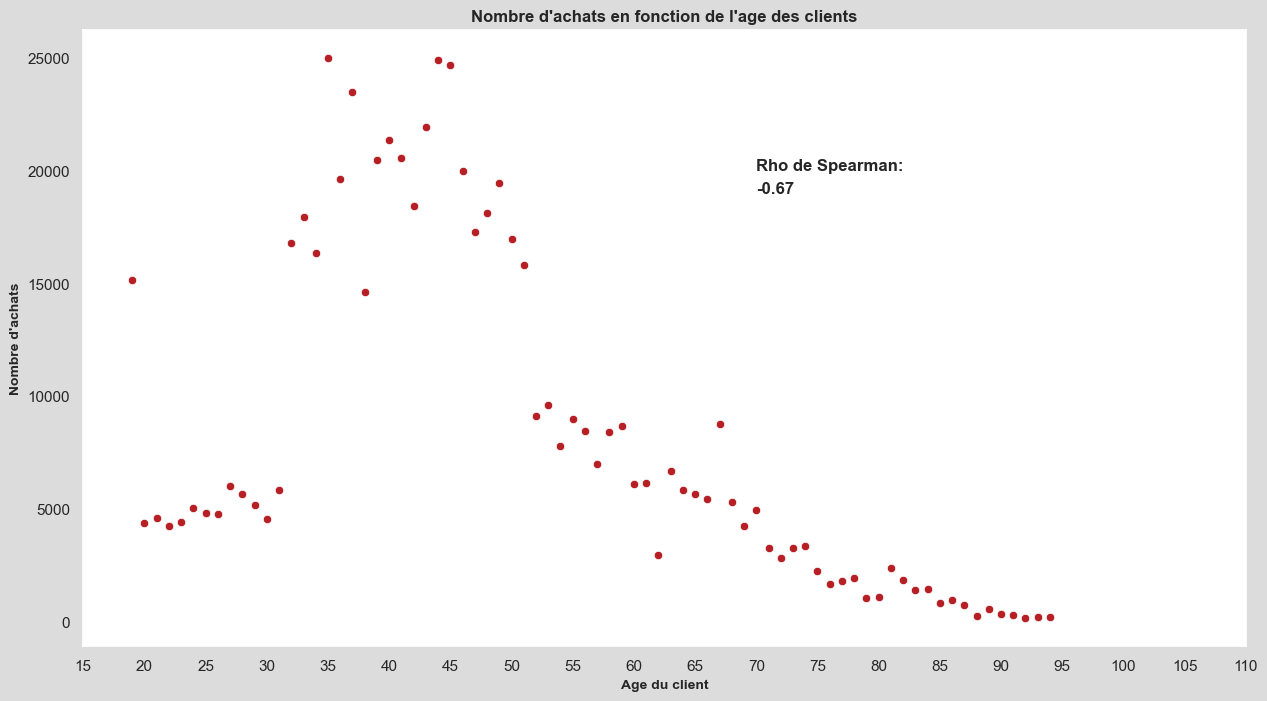

In [207]:
# plot age against total number of purchases
# plot total purchases against clients ages
sns.set(rc={'figure.figsize':(15, 8),'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})
graph39 = sns.scatterplot(data=nb_sales_age, x='age_clients', y='product_id_sales', alpha=1, color=col)                         
graph39.set_title("Nombre d'achats en fonction de l'age des clients", fontname='Arial', fontsize=12,
                  fontweight='bold')
plt.xlabel('Age du client', fontweight='bold', fontsize=10)
plt.ylabel("Nombre d'achats", fontweight='bold', fontsize=10)
plt.xticks([15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110], rotation=0)

#adding text inside the plot
plt.text(70, 20000, ("Rho de Spearman:") , fontsize=12, fontweight='bold')
plt.text(70, 19000, (round(rho11,2)) , fontsize=12, fontweight='bold')

plt.savefig("graph39.png", bbox_inches='tight')
plt.show()


#### 3.2.5 - Age et categories de livres achetes

In [208]:
CA_cli_cat_A= CA_cli_session.groupby(['age_clients','category_books'])['product_id_books'].count().reset_index()
CA_cli_cat_AR= CA_cli_session.groupby(['age_range_clients','category_books'])['product_id_books'].count().reset_index()
CA_cli_cat_BP= CA_cli_session.loc[:, ['category_books', 'age_clients']]

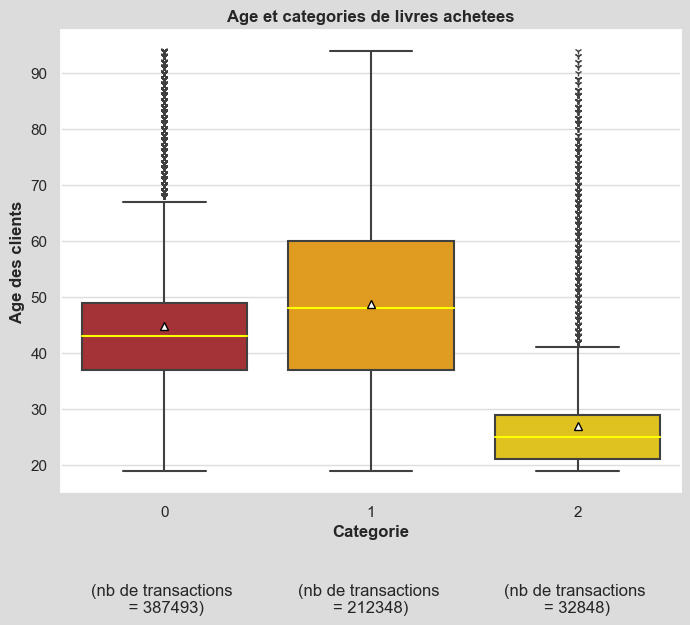

In [209]:
# plot book category against client age range on a box plot
sns.set(rc={'figure.figsize':(8, 6), 'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})
graph40 = sns.boxplot(data=CA_cli_cat_BP, x="category_books", y="age_clients",
                       flierprops={"marker": "1"}, medianprops={"color" : "yellow"},
                       meanprops={"markerfacecolor":"white", "markeredgecolor":"black"}, orient="v", color=col,
                       showmeans=True, dodge=False, order=['0', '1', '2'],
                       palette=[col, 'orange', 'gold'])
plt.xlabel("Categorie", fontweight='bold', fontsize=12)
plt.ylabel('Age des clients', fontweight='bold', fontsize=12)
plt.title("Age et categories de livres achetees", fontweight='bold', fontsize=12)
plt.grid(axis='y', color='gainsboro')

# add number of purchases for each category
nb_cat_cli = CA_cli_cat_BP.groupby(['category_books'])['age_clients'].count().reset_index()
plt.text(0, -1,"(nb de transactions \n = {})".format(nb_cat_cli.iloc[0, 1]), horizontalalignment='center',
         verticalalignment='top')  
plt.text(1, -1,"(nb de transactions \n= {})".format(nb_cat_cli.iloc[1, 1]), horizontalalignment='center',
         verticalalignment='top')
plt.text(2, -1,"(nb de transactions \n= {})".format(nb_cat_cli.iloc[2, 1]), horizontalalignment='center',
         verticalalignment='top')

plt.savefig("graph40.png", bbox_inches='tight')


#### Il semble que l'age median des lecteurs n'est pas identique parmi nos 3 categories de produits. Verifions cette hypothese par un test statistique. Comme nous cherchons a analyser la relation entre une variable qualitative et une variable quantitative, mais que l'age des clients n'etant pas distribue selon une loi normale, le test ANOVA n'est pas approprie ici et nous utiliserons le test de non-parametrique de Kruskal-Wallis, qui est une generalisation du test de Mann-Whitney a plus de 2 populations (les populations etant ici nos groupes de lecteurs dans chaque categorie).
#### On pose H0 : l'age median est le meme pour toutes les categories de livres, que nous testons contre l'hypothese alternative H1 : l'age median d'au moins une categorie de livres est different de celui des 2 autres, a un seuil α = 5%.

In [210]:
CA_cli_cat_BP['age_clients'] = CA_cli_cat_BP['age_clients'].astype(float)

In [211]:
# Kruskal-Wallis test
groupednumbers = {grp: CA_cli_cat_BP['age_clients'][CA_cli_cat_BP['category_books']==grp].values for grp in CA_cli_cat_BP[
    'category_books'].unique()}
args = groupednumbers.values()
args = [groupednumbers[grp] for grp in sorted(CA_cli_cat_BP['category_books'].unique())]
stat10, p10 = st.kruskal(*args)
print("Stat:", stat10)
print("p-value:", "{:e}".format(p10))

Stat: 72214.83433330593
p-value: 0.000000e+00


##### On rejette donc H0 : au moins une categorie de livres a un age median des acheteurs different.

#### 3.2.6 - Autres indicateurs

##### 3.2.6.1 - Age et duree des sessions

In [212]:
session_length.describe(include='all', datetime_is_numeric=True)

session_id_sales                    session_end  \
count            342315                         342315   
unique           342315                            NaN   
top                 s_1                            NaN   
freq                  1                            NaN   
mean                NaN  2022-03-04 06:50:15.824841984   
min                 NaN     2021-03-01 00:01:07.843138   
25%                 NaN  2021-09-05 21:57:45.925758976   
50%                 NaN  2022-03-04 23:53:03.432281088   
75%                 NaN  2022-09-01 02:14:30.579120896   
max                 NaN     2023-02-28 23:58:30.792755   
std                 NaN                            NaN   

                        session_start  session_duration  
count                          342315     342315.000000  
unique                            NaN               NaN  
top                               NaN               NaN  
freq                              NaN               NaN  
mean    2022-03-04 06:36:37.636154880        818.188686  
min        2021-03-01 00:01:07.843138          0.000000  
25%     2021-09-05 21:33:02.253870080          0.000000  
50%     2022-03-04 23:45:59.009061120        140.032368  
75%     2022-09-01 01:57:29.837368320       1468.941376  
max        2023-02-28 23:58:00.107815       7270.566195  
std                               NaN       1095.534889

In [213]:
session_length_pos = session_length.loc[session_length['session_duration'] > 0]

# calculate number of sessions in session_length table
n = session_length['session_id_sales'].count()
print("Nombre de sessions de duree non-nulle:", n)

# calculate first quartile
Q1 = np.percentile((session_length['session_duration'].values.astype("float64")/1000000000), 25)
print("Q1:", Q1*1000000000)

# calculate third quartile
Q3 = np.percentile((session_length['session_duration'].values.astype("float64")/1000000000), 75)
print("Q3:", Q3*1000000000)

# calculate interquartile range
IQ = Q3 - Q1
print("IQ:", IQ*1000000000)

# calculate bin width for histogram (Freedman-Diaconis rule)
bin_width = 2*((IQ*1000000000)/np.cbrt(n))
print("Bin width:", bin_width)

# calculate number of bins for histogram
nb_bins = ((maxi - mini) / bin_width).astype(int)
print("Nb of bins:", nb_bins)

Nombre de sessions de duree non-nulle: 342315
Q1: 0.0
Q3: 1468.9413760000002
IQ: 1468.9413760000002
Bin width: 41.997729904437705
Nb of bins: 173


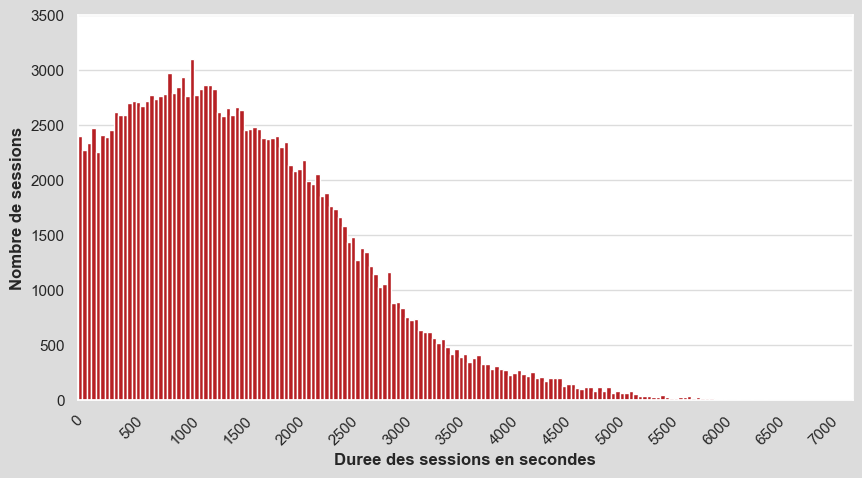

In [214]:
# graph analysis 1 - analyse session lengths distribution with histogram
sns.set(rc = {'figure.figsize':(10, 5), 'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})
graph41 = plt.hist(session_length_pos['session_duration'].values.astype("float64"), bins=nb_bins, color=col)
plt.xticks([0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000], rotation=45)
plt.yticks([0, 500, 1000, 1500, 2000, 2500, 3000, 3500])
plt.xlim([0, maxi])
plt.xlabel('Duree des sessions en secondes', fontweight='bold', fontsize='12')
plt.ylabel('Nombre de sessions', fontweight='bold', fontsize='12')
plt.grid(axis='y', color='gainsboro')
plt.savefig("graph41.png", bbox_inches='tight')

#### Il semble improbable que les durees de session soient distribues selon une loi normale. Confirmons cette hypothese avec d'autres graphiques et outils statistiques.

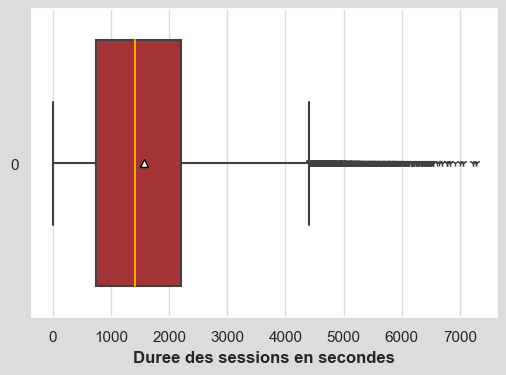

In [215]:
# graph analysis 2 - analyse session lengths distribution with a box plot
sns.set(rc={'figure.figsize':(6,4),'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})
graph42 = sns.boxplot(data=session_length_pos['session_duration'].values.astype("float64"), flierprops={"marker": "1"},
            medianprops={"color" : "orange"}, meanprops={"markerfacecolor":"white", "markeredgecolor":"black"},
            orient="h", color=col, showmeans=True)
plt.xlabel('Duree des sessions en secondes', fontweight='bold', fontsize=12)
plt.grid(axis='x', color='gainsboro')
plt.savefig("graph42.png", bbox_inches='tight')

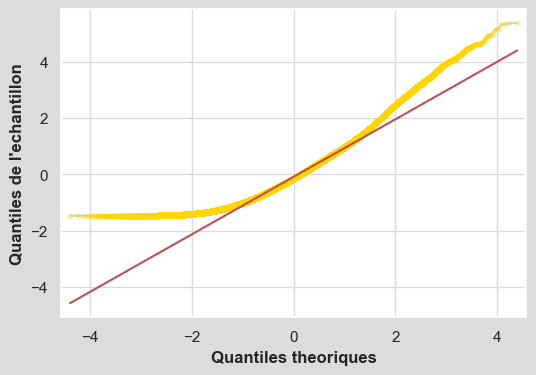

In [216]:
# analyse session lengths distribution with a QQ plot
graph43 = sm.qqplot(session_length_pos['session_duration'],marker='.', markerfacecolor='gold',
                     markeredgecolor='gold', alpha=0.3, line="q", linestyle='solid', fit=True)
plt.xlabel("Quantiles theoriques", fontweight='bold', fontsize=12)
plt.ylabel("Quantiles de l'echantillon", fontweight='bold', fontsize=12)
plt.grid(axis='both', color='gainsboro')
plt.savefig("graph43.png", bbox_inches='tight')

#### Les queues de la distribution empirique s'eloignent significativement de celles de la distribution theorique d'une loi Normale.

In [217]:
# analyse session lengths distribution with Shapiro-Wilk test
stat, p = st.shapiro(session_length_pos['session_duration'])
alpha = 0.05
print('Statistique de test:', round(stat,4))
print('p-value:', round(p,4))
if p > alpha:
    print('La distribution est probablement gaussienne.')
else:
    print("La distribution n'est probablement pas gaussienne.")

Statistique de test: 0.9475
p-value: 0.0
La distribution n'est probablement pas gaussienne.


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


#### Le test de Shapiro-Wilks confirme les analyses de l'histogramme, du boxplot et du QQ plot. La distribution des temps de session n'est probablement pas gaussienne.

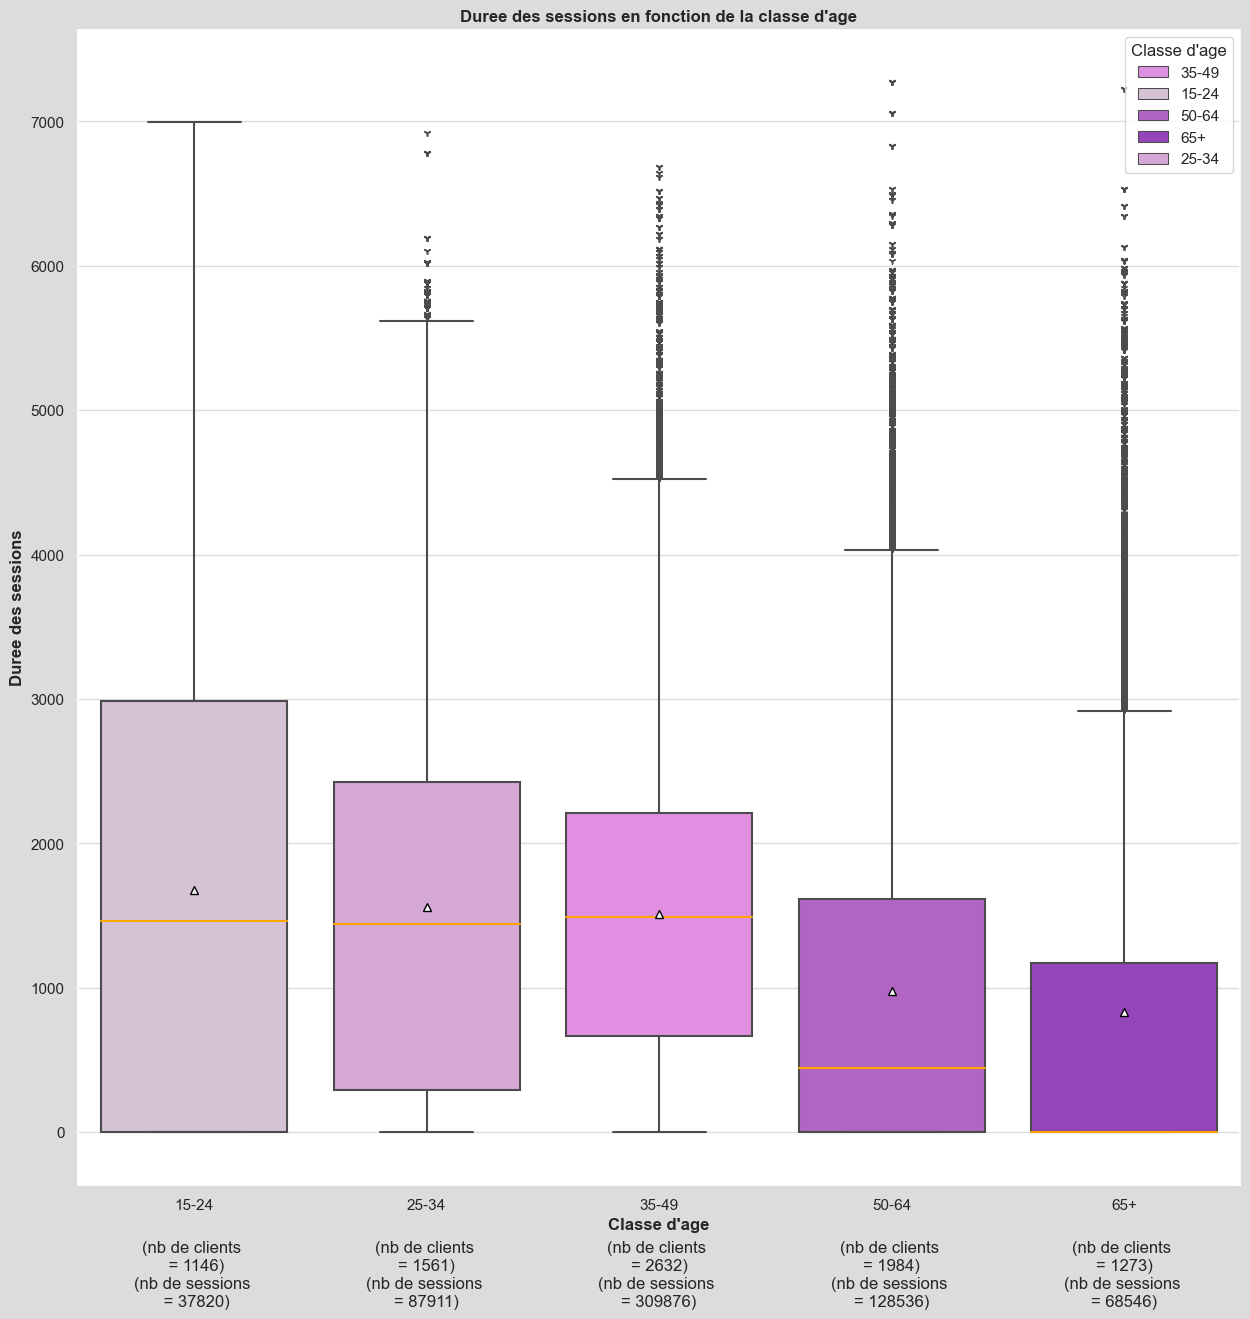

In [218]:
# plot session length against client age range on a box plot
sns.set(rc={'figure.figsize':(15, 15), 'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})
graph44 = sns.boxplot(data=CA_cli_session, x="age_range_clients", y="session_duration", hue="age_range_clients",
                       flierprops={"marker": "1"}, medianprops={"color" : "orange"},
                       meanprops={"markerfacecolor":"white", "markeredgecolor":"black"}, orient="v", color=col,
                       showmeans=True, dodge=False, order=['15-24', '25-34', '35-49', '50-64', '65+'],
                       palette=['violet', 'thistle','mediumorchid','darkorchid','plum'])
plt.xlabel("Classe d'age", fontweight='bold', fontsize=12)
plt.ylabel('Duree des sessions', fontweight='bold', fontsize=12)
plt.title("Duree des sessions en fonction de la classe d'age", fontweight='bold', fontsize=12)
plt.legend(title="Classe d'age")
plt.grid(axis='y', color='gainsboro')

# add number of clients for each age range
plt.text(0, -750,"(nb de clients \n = {})".format(nb_cli_BP.iloc[0, 1]), horizontalalignment='center',
         verticalalignment='top')  
plt.text(1, -750,"(nb de clients \n= {})".format(nb_cli_BP.iloc[1, 1]), horizontalalignment='center',
         verticalalignment='top')
plt.text(2, -750,"(nb de clients \n= {})".format(nb_cli_BP.iloc[2, 1]), horizontalalignment='center',
         verticalalignment='top')
plt.text(3, -750,"(nb de clients \n= {})".format(nb_cli_BP.iloc[3, 1]), horizontalalignment='center',
         verticalalignment='top')
plt.text(4, -750,"(nb de clients \n= {})".format(nb_cli_BP.iloc[4, 1]), horizontalalignment='center',
         verticalalignment='top')

# add number of sessions for each age range
CA_cli_session_BP = CA_cli_session.groupby(['age_range_clients'])['session_id_sales'].count().reset_index()
plt.text(0, -1000,"(nb de sessions \n = {})".format(CA_cli_session_BP.iloc[0, 1]), horizontalalignment='center',
         verticalalignment='top')  
plt.text(1, -1000,"(nb de sessions \n= {})".format(CA_cli_session_BP.iloc[1, 1]), horizontalalignment='center',
         verticalalignment='top')
plt.text(2, -1000,"(nb de sessions \n= {})".format(CA_cli_session_BP.iloc[2, 1]), horizontalalignment='center',
         verticalalignment='top')
plt.text(3, -1000,"(nb de sessions \n= {})".format(CA_cli_session_BP.iloc[3, 1]), horizontalalignment='center',
         verticalalignment='top')
plt.text(4, -1000,"(nb de sessions \n= {})".format(CA_cli_session_BP.iloc[4, 1]), horizontalalignment='center',
         verticalalignment='top')


plt.savefig("graph44.png", bbox_inches='tight')


#### La duree moyenne et mediane des sessions est tres proche chez tous les groupes de moins de 50 ans.

##### 3.2.6.2 - Duree des sessions et montant du panier

In [219]:
CA_cli_session_amt = CA_cli_session.groupby(['session_id_sales','session_duration'])['price_books'].sum().reset_index()

# discretise session durations
CA_cli_session_amt.loc[(CA_cli_session_amt['session_duration'] >= 0) & (CA_cli_session_amt['session_duration'] <= 1000),
                       'session_length'] = "500"
CA_cli_session_amt.loc[(CA_cli_session_amt['session_duration'] > 1000) & (CA_cli_session_amt['session_duration'] <= 2000),
                       'session_length'] = "1500"
CA_cli_session_amt.loc[(CA_cli_session_amt['session_duration'] > 2000) & (CA_cli_session_amt['session_duration'] <= 3000),
                       'session_length'] = "2500"
CA_cli_session_amt.loc[(CA_cli_session_amt['session_duration'] > 3000) & (CA_cli_session_amt['session_duration'] <= 4000),
                       'session_length'] = "3500"
CA_cli_session_amt.loc[(CA_cli_session_amt['session_duration'] > 4000) & (CA_cli_session_amt['session_duration'] <= 5000),
                       'session_length'] = "4500"
CA_cli_session_amt.loc[(CA_cli_session_amt['session_duration'] > 5000) & (CA_cli_session_amt['session_duration'] <= 6000),
                       'session_length'] = "5500"
CA_cli_session_amt.loc[(CA_cli_session_amt['session_duration'] > 6000) & (CA_cli_session_amt['session_duration'] <= 7000),
                       'session_length'] = "6500"
CA_cli_session_amt.loc[(CA_cli_session_amt['session_duration'] > 7000),
                       'session_length'] = "7500"
CA_cli_session_amt['session_length'] = CA_cli_session_amt['session_length'].astype(int)

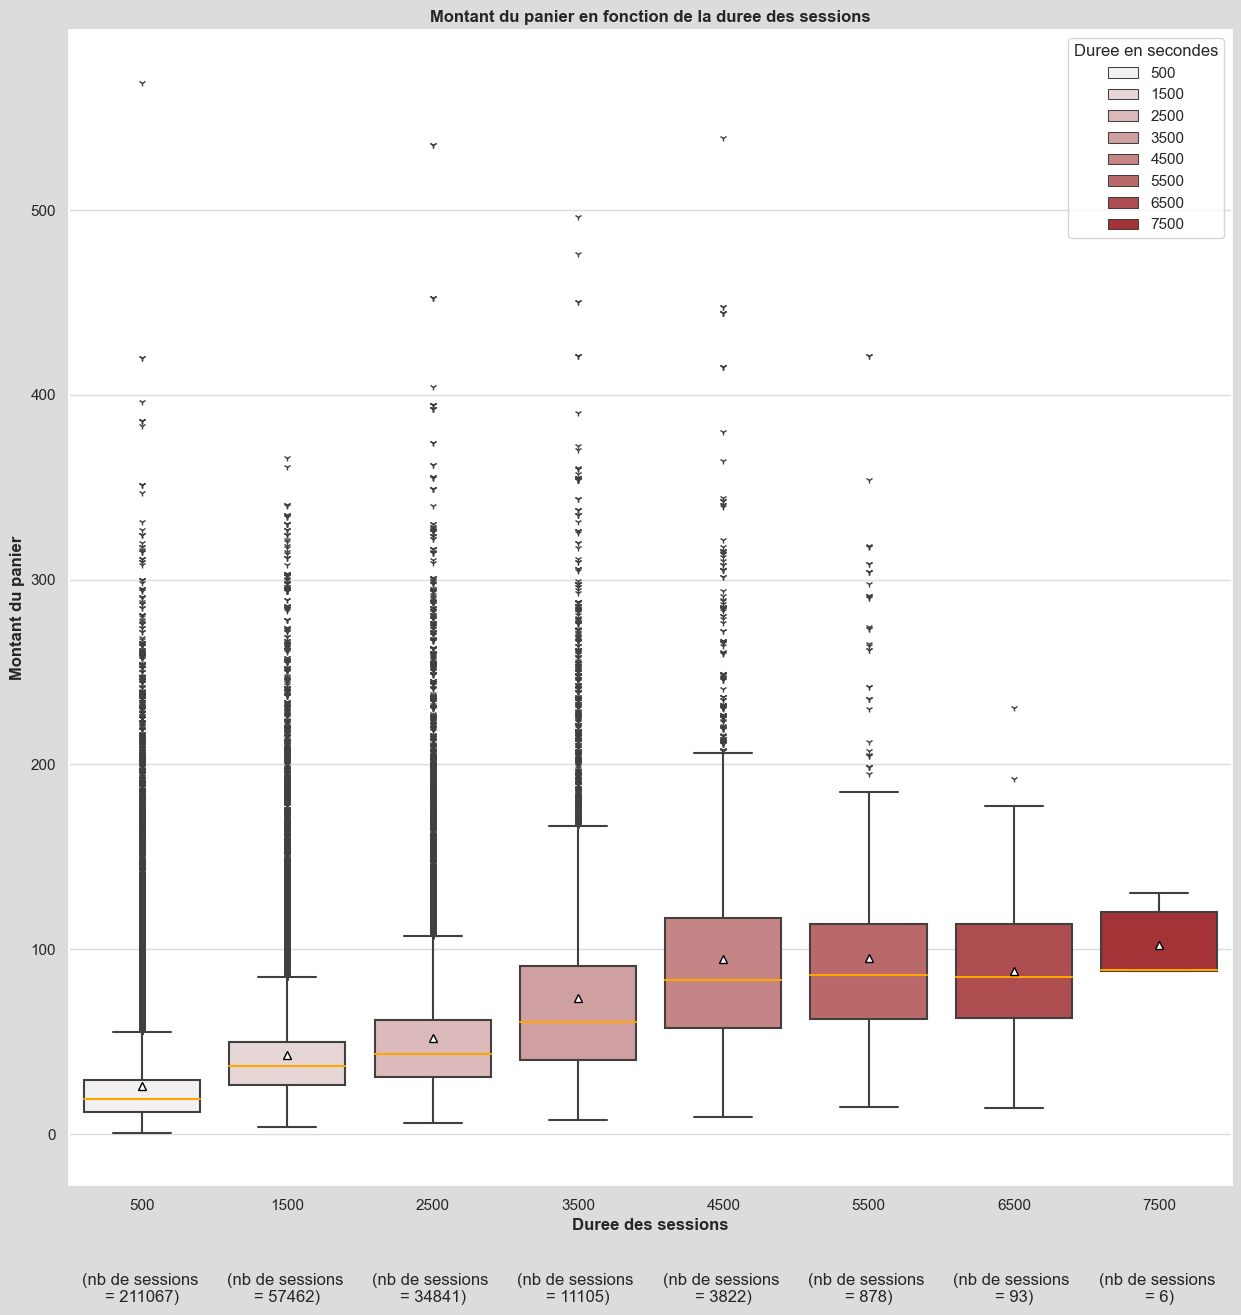

In [220]:
# plot basket size against session length on a box plot
sns.set(rc={'figure.figsize':(15, 15), 'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})
graph45 = sns.boxplot(data=CA_cli_session_amt, x="session_length", y="price_books", hue="session_length",
                       flierprops={"marker": "1"}, medianprops={"color" : "orange"},
                       meanprops={"markerfacecolor":"white", "markeredgecolor":"black"}, orient="v", color=col,
                       showmeans=True, dodge=False)
plt.xlabel("Duree des sessions", fontweight='bold', fontsize=12)
plt.ylabel('Montant du panier', fontweight='bold', fontsize=12)
plt.legend(title="Duree en secondes")
plt.title("Montant du panier en fonction de la duree des sessions", fontweight='bold', fontsize=12)
plt.grid(axis='y', color='gainsboro')

# add number of clients for each age range
nb_sessions_BP = CA_cli_session_amt.groupby('session_length')['session_id_sales'].count().reset_index()
plt.text(0, -75,"(nb de sessions \n= {})".format(nb_sessions_BP.iloc[0, 1]), horizontalalignment='center',
         verticalalignment='top')  
plt.text(1, -75,"(nb de sessions \n= {})".format(nb_sessions_BP.iloc[1, 1]), horizontalalignment='center',
         verticalalignment='top')
plt.text(2, -75,"(nb de sessions \n= {})".format(nb_sessions_BP.iloc[2, 1]), horizontalalignment='center',
         verticalalignment='top')
plt.text(3, -75,"(nb de sessions \n= {})".format(nb_sessions_BP.iloc[3, 1]), horizontalalignment='center',
         verticalalignment='top')
plt.text(4, -75,"(nb de sessions \n= {})".format(nb_sessions_BP.iloc[4, 1]), horizontalalignment='center',
         verticalalignment='top')
plt.text(5, -75,"(nb de sessions \n= {})".format(nb_sessions_BP.iloc[5, 1]), horizontalalignment='center',
         verticalalignment='top')
plt.text(6, -75,"(nb de sessions \n= {})".format(nb_sessions_BP.iloc[6, 1]), horizontalalignment='center',
         verticalalignment='top')
plt.text(7, -75,"(nb de sessions \n= {})".format(nb_sessions_BP.iloc[7, 1]), horizontalalignment='center',
         verticalalignment='top')


plt.savefig("graph45.png", bbox_inches='tight')


#### Il semble que le montant median du panier s'accroit avec la duree des sessions, mais l'analyse est biasee par le fait que pour calculer une duree de session, il faut au moins 2 produits dans le panier. Il conviendrait de modifier l'horodatage des sessions sur le site pour enregistrer egalement la duree des sessions pour les paniers ne contenant qu'un article afin de pouvoir affiner cette analyse.

#### 3.2.6.3 - Prix des produits et quantites vendues

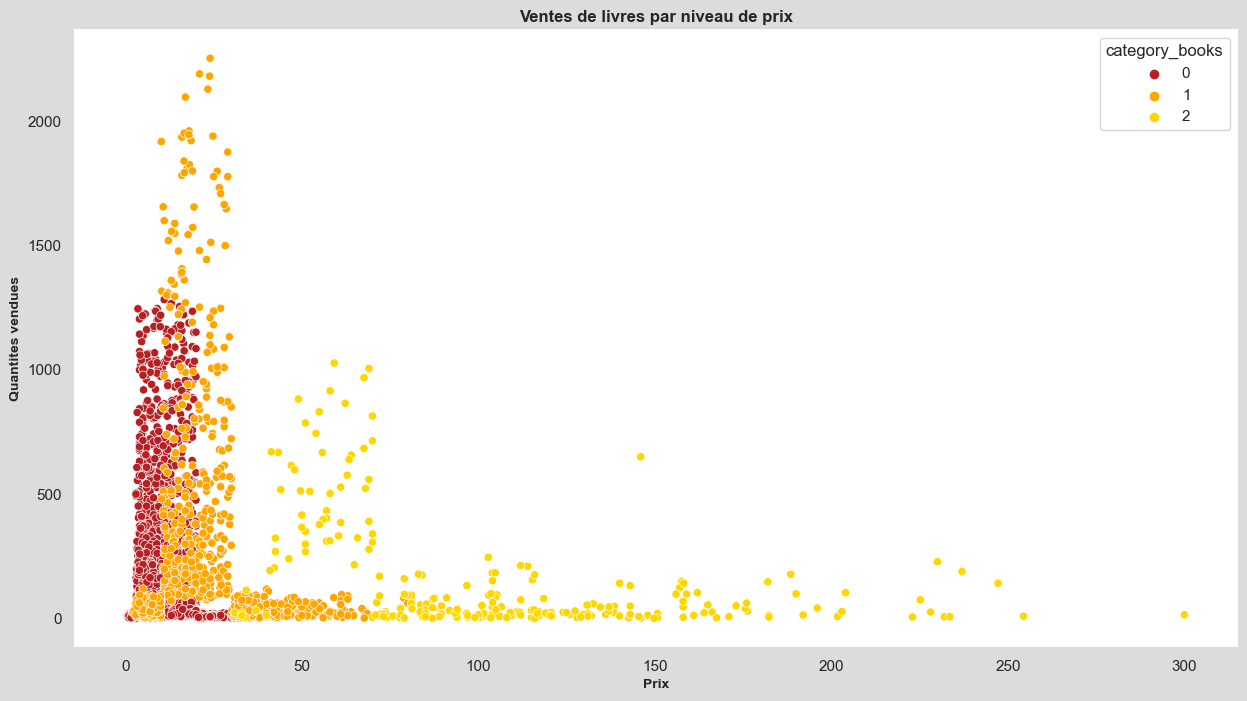

In [221]:
CA_val_vol = CA.loc[:, ['product_id_sales','product_id_books', 'price_books', 'category_books']]
CA_val_vol2 = CA_val_vol.groupby(['product_id_sales','price_books','category_books'])['product_id_books'].count().reset_index()

# plot product price against quantities sold
sns.set(rc={'figure.figsize':(15, 8),'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})
graph46 = sns.scatterplot(data=CA_val_vol2, x='price_books', y='product_id_books', hue='category_books',
                        palette=[col, 'orange', 'gold'])
graph46.set_title("Ventes de livres par niveau de prix", fontname = 'Arial',fontsize = 12,fontweight = 'bold')
plt.xlabel('Prix',fontweight = 'bold' ,fontsize = 10)
plt.ylabel("Quantites vendues",fontweight = 'bold',fontsize = 10)
plt.savefig("graph46.png", bbox_inches='tight')
plt.show()

In [222]:
# discretise product prices
CA_val_vol2.loc[(CA_val_vol2['price_books'] >= 0) & (CA_val_vol2['price_books'] <= 10),
                       'price_cat'] = "5"
CA_val_vol2.loc[(CA_val_vol2['price_books'] > 10) & (CA_val_vol2['price_books'] <= 20),
                       'price_cat'] = "15"
CA_val_vol2.loc[(CA_val_vol2['price_books'] > 20) & (CA_val_vol2['price_books'] <= 30),
                       'price_cat'] = "25"
CA_val_vol2.loc[(CA_val_vol2['price_books'] > 30) & (CA_val_vol2['price_books'] <= 40),
                       'price_cat'] = "35"
CA_val_vol2.loc[(CA_val_vol2['price_books'] > 40) & (CA_val_vol2['price_books'] <= 50),
                       'price_cat'] = "45"
CA_val_vol2.loc[(CA_val_vol2['price_books'] > 50) & (CA_val_vol2['price_books'] <= 100),
                       'price_cat'] = "75"
CA_val_vol2.loc[(CA_val_vol2['price_books'] > 100) & (CA_val_vol2['price_books'] <= 150),
                       'price_cat'] = "125"
CA_val_vol2.loc[(CA_val_vol2['price_books'] > 150) & (CA_val_vol2['price_books'] <= 200),
                       'price_cat'] = "175"
CA_val_vol2.loc[(CA_val_vol2['price_books'] > 200) & (CA_val_vol2['price_books'] <= 250),
                       'price_cat'] = "225"
CA_val_vol2.loc[(CA_val_vol2['price_books'] > 250),
                       'price_cat'] = "275"
CA_val_vol2['price_cat'] = CA_val_vol2['price_cat'].astype(int)

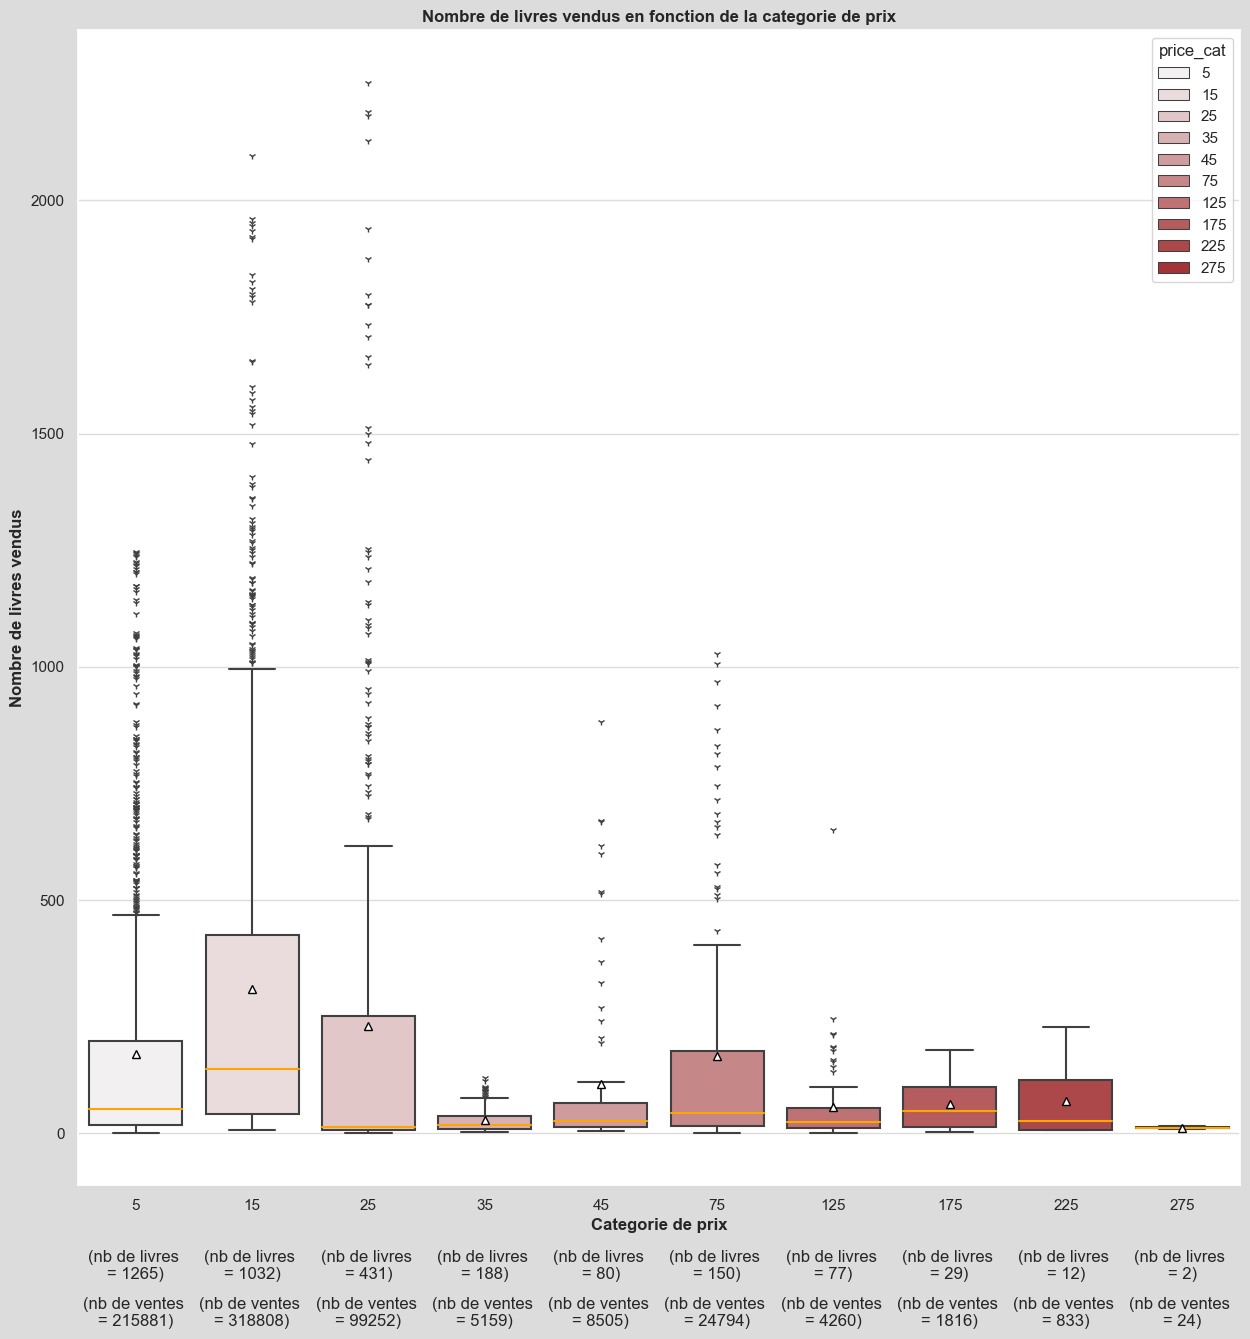

In [223]:
# plot number of books bought per year against client age range on a box plot
sns.set(rc={'figure.figsize':(15, 15), 'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})
graph47 = sns.boxplot(data=CA_val_vol2, x="price_cat", y="product_id_books", hue="price_cat",
                       flierprops={"marker": "1"}, medianprops={"color" : "orange"},
                       meanprops={"markerfacecolor":"white", "markeredgecolor":"black"}, orient="v", color=col,
                       showmeans=True, dodge=False)
plt.xlabel("Categorie de prix", fontweight='bold', fontsize=12)
plt.ylabel('Nombre de livres vendus', fontweight='bold', fontsize=12)
plt.title("Nombre de livres vendus en fonction de la categorie de prix", fontweight='bold', fontsize=12)
plt.grid(axis='y', color='gainsboro')

# add number of books for each price category
nb_books_BP = CA_val_vol2.groupby('price_cat')['product_id_sales'].count().reset_index()
plt.text(0, -250,"(nb de livres \n= {})".format(nb_books_BP.iloc[0, 1]), horizontalalignment='center',
         verticalalignment='top')  
plt.text(1, -250,"(nb de livres \n= {})".format(nb_books_BP.iloc[1, 1]), horizontalalignment='center',
         verticalalignment='top')
plt.text(2, -250,"(nb de livres \n= {})".format(nb_books_BP.iloc[2, 1]), horizontalalignment='center',
         verticalalignment='top')
plt.text(3, -250,"(nb de livres \n= {})".format(nb_books_BP.iloc[3, 1]), horizontalalignment='center',
         verticalalignment='top')
plt.text(4, -250,"(nb de livres \n= {})".format(nb_books_BP.iloc[4, 1]), horizontalalignment='center',
         verticalalignment='top')
plt.text(5, -250,"(nb de livres \n= {})".format(nb_books_BP.iloc[5, 1]), horizontalalignment='center',
         verticalalignment='top')
plt.text(6, -250,"(nb de livres \n= {})".format(nb_books_BP.iloc[6, 1]), horizontalalignment='center',
         verticalalignment='top')
plt.text(7, -250,"(nb de livres \n= {})".format(nb_books_BP.iloc[7, 1]), horizontalalignment='center',
         verticalalignment='top')
plt.text(8, -250,"(nb de livres \n= {})".format(nb_books_BP.iloc[8, 1]), horizontalalignment='center',
         verticalalignment='top')
plt.text(9, -250,"(nb de livres \n= {})".format(nb_books_BP.iloc[9, 1]), horizontalalignment='center',
         verticalalignment='top')

# add number of sales for each price category
nb_sold_BP = CA_val_vol2.groupby('price_cat')['product_id_books'].sum().reset_index()
plt.text(0, -350,"(nb de ventes \n= {})".format(nb_sold_BP.iloc[0, 1]), horizontalalignment='center',
         verticalalignment='top')  
plt.text(1, -350,"(nb de ventes \n= {})".format(nb_sold_BP.iloc[1, 1]), horizontalalignment='center',
         verticalalignment='top')
plt.text(2, -350,"(nb de ventes \n= {})".format(nb_sold_BP.iloc[2, 1]), horizontalalignment='center',
         verticalalignment='top')
plt.text(3, -350,"(nb de ventes \n= {})".format(nb_sold_BP.iloc[3, 1]), horizontalalignment='center',
         verticalalignment='top')
plt.text(4, -350,"(nb de ventes \n= {})".format(nb_sold_BP.iloc[4, 1]), horizontalalignment='center',
         verticalalignment='top')
plt.text(5, -350,"(nb de ventes \n= {})".format(nb_sold_BP.iloc[5, 1]), horizontalalignment='center',
         verticalalignment='top')
plt.text(6, -350,"(nb de ventes \n= {})".format(nb_sold_BP.iloc[6, 1]), horizontalalignment='center',
         verticalalignment='top')
plt.text(7, -350,"(nb de ventes \n= {})".format(nb_sold_BP.iloc[7, 1]), horizontalalignment='center',
         verticalalignment='top')
plt.text(8, -350,"(nb de ventes \n= {})".format(nb_sold_BP.iloc[8, 1]), horizontalalignment='center',
         verticalalignment='top')
plt.text(9, -350,"(nb de ventes \n= {})".format(nb_sold_BP.iloc[9, 1]), horizontalalignment='center',
         verticalalignment='top')

plt.savefig("graph47.png", bbox_inches='tight')


#### Il n'apparait pas de correlation evidente entre le prix des livres et les quantites vendues, ce qui est attendu pour un bien culturel (relative inelasticite de la demande au prix).

##### 3.2.6.4 - Correlation entre-elles des ventes des differentes categories de produits

In [224]:
daily_cat_CA_corr = daily_cat_CA[['date_only_sales', 'category_books', 'daily_cat_CA']].pivot_table(index='date_only_sales',
                                                                                              values='daily_cat_CA',
                                                                          columns='category_books', aggfunc=sum,
                                                                          margins=False)

In [225]:
# check for existence of non-linear correlation (Spearman coefficient)
rho43, p43 = st.spearmanr(daily_cat_CA_corr["0"],daily_cat_CA_corr["2"])
print("Coefficient de correlation de Spearman:", '{:,.2f}'.format(rho43))
print("p-value:", '{:,.2f}'.format(p43))

Coefficient de correlation de Spearman: -0.36
p-value: 0.00


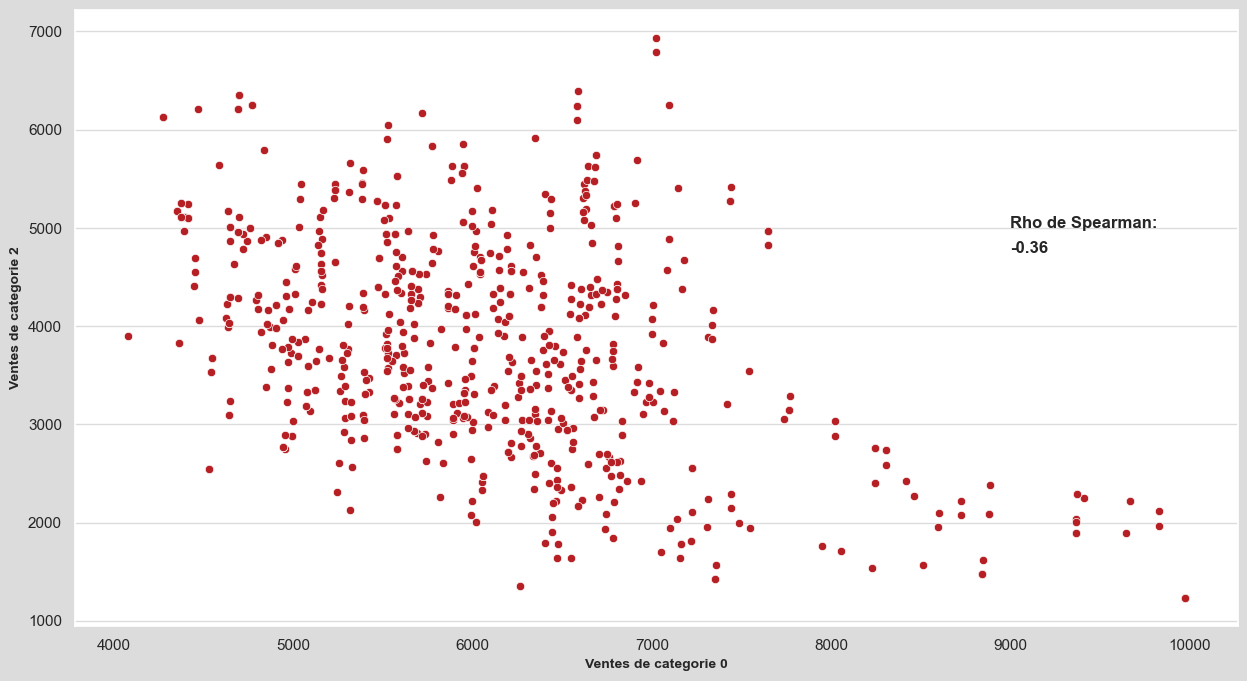

In [226]:
# plot daily sales of category 0 against category 2
sns.set(rc={'figure.figsize':(15, 8),'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})
graph48 = sns.scatterplot(data=daily_cat_CA_corr, x='0', y='2', color=col)
plt.xlabel('Ventes de categorie 0',fontweight = 'bold' ,fontsize = 10)
plt.ylabel("Ventes de categorie 2",fontweight = 'bold',fontsize = 10)
plt.grid(axis = 'y', color='gainsboro')

#adding text inside the plot
plt.text(9000, 5000, ("Rho de Spearman:") , fontsize=12, fontweight='bold')
plt.text(9000, 4750, (round(rho43,2)) , fontsize=12, fontweight='bold')

plt.savefig("graph48.png", bbox_inches='tight')
plt.show()

#### La distribution du nombre de ventes quotidiennes n’est pas Normale. On utilise donc un test non-parametrique pour evaluer la correlation entre ces 2 variables quantitatives: on calcule le rho de Spearman, qui est un coefficient de correlation sur les rangs d’echelles ordinales (non-lineaire, contrairement au coefficient de Pearson qui est son equivalent parametrique) et qui mesure la relation monotone entre deux variables i.e. le fait que lorsqu’une variable augmente, l’autre diminue toujours (relation monotone decroissante) ou augmente toujours (relation monotone croissante). Ce coefficient est proche de zero si la relation n’est pas monotone, i.e. si lorsqu’une variable augmente, l’autre augmente parfois et diminue parfois.
#### Le rho de Spearman est (tout comme le coefficient de Pearson) toujours compris entre -1 et 1 et s'interprete de la meme facon - plus le resultat est proche de 1 et plus les variables sont correlees (resp. -1 / inversement correlees); ici, rho vaut -0.36, on peut donc conclure a l'existence d'une correlation negative d’intensite faible entre les ventes de produits de classe 0 et 2, caracterisee par une relation monotone decroissante.
#### La p-value est indiquee comme étant zero, ce qui signifie que ce resultat est significatif. Elle correspond a la p-value du test H0: il n'existe pas de correlation monotone entre ces variables contre l'alternative H1: il existe une correlation monotone entre ces variables. Au seuil de risque α = 1%, on rejette donc H0, et on considere le coefficient de Spearman comme significatif de l'existence d'une correlation monotone faible entre ces 2 variables.


##### 3.2.6.5 - Correlation des ventes avec le jour de la semaine

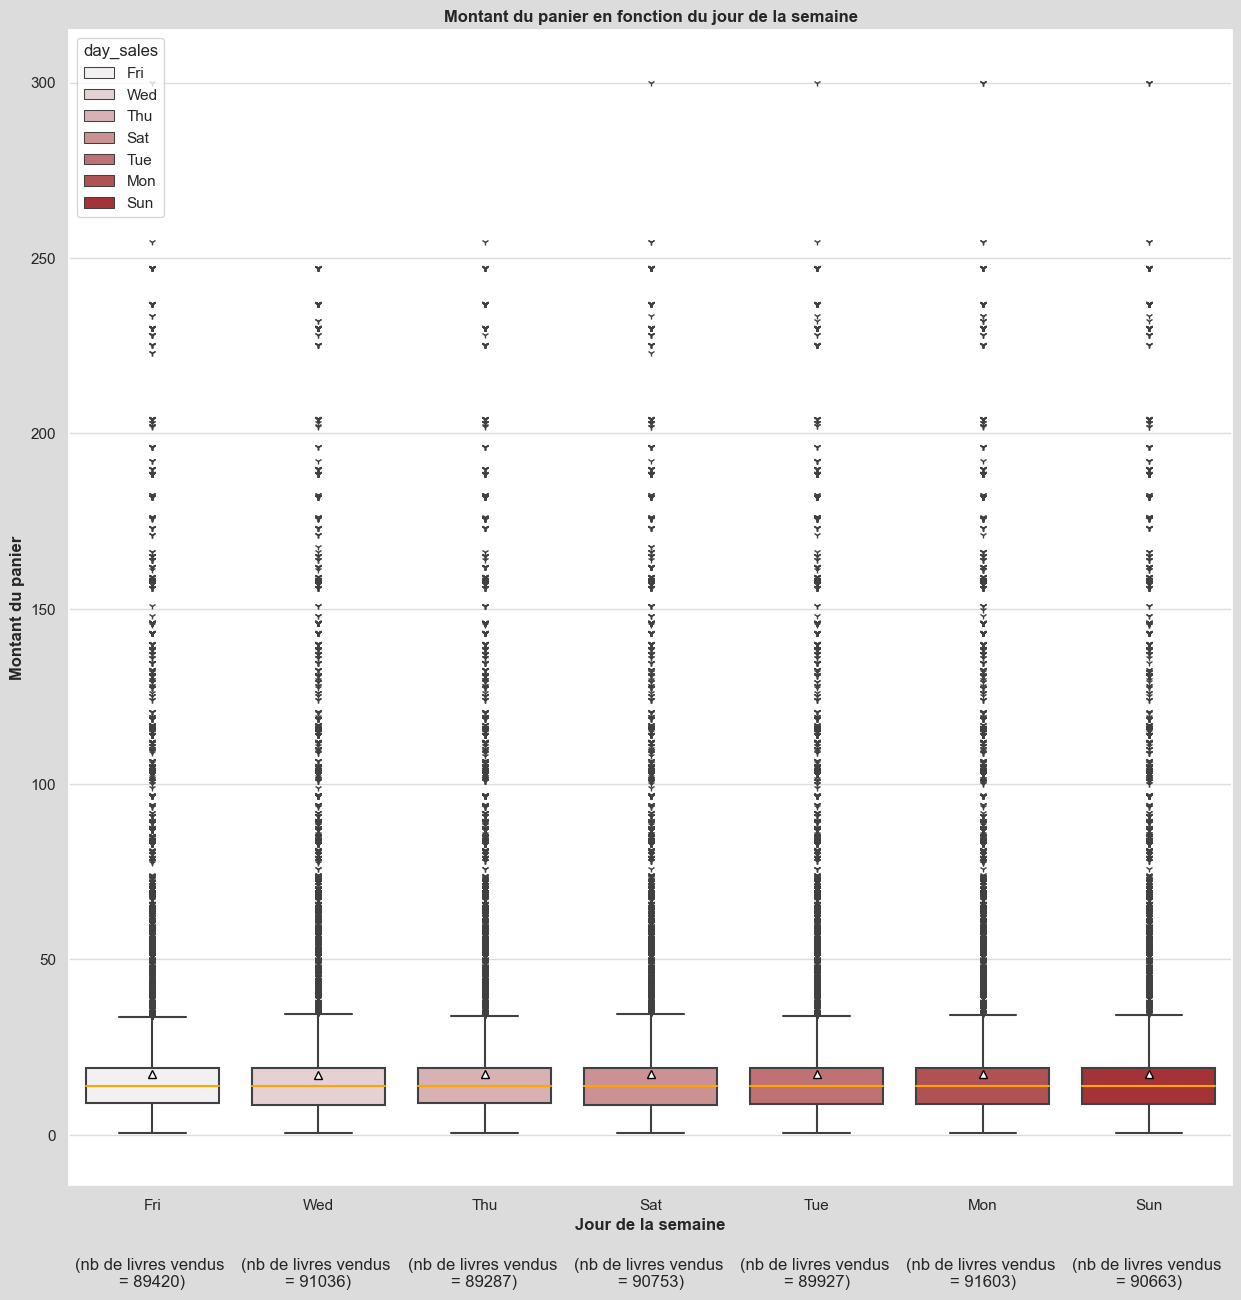

In [227]:
# plot sales against weekday on a box plot
sns.set(rc={'figure.figsize':(15, 15), 'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})
graph49 = sns.boxplot(data=CA_cli_session, x="day_sales", y="price_books", hue="day_sales", flierprops={"marker": "1"},
            medianprops={"color" : "orange"}, meanprops={"markerfacecolor":"white", "markeredgecolor":"black"},
            orient="v", color=col, showmeans=True, dodge=False)
plt.xlabel('Jour de la semaine', fontweight='bold', fontsize=12)
plt.ylabel('Montant du panier', fontweight='bold', fontsize=12)
plt.title('Montant du panier en fonction du jour de la semaine', fontweight='bold', fontsize=12)
plt.grid(axis='y', color='gainsboro')

# add number of products sold for each day of the week
nb_sales = CA_cli_session.groupby('day_sales')['product_id_books'].count().reset_index()
plt.text(0, -35,"(nb de livres vendus \n= {})".format(nb_sales.iloc[0, 1]), horizontalalignment='center',
         verticalalignment='top')  
plt.text(1, -35,"(nb de livres vendus \n= {})".format(nb_sales.iloc[1, 1]), horizontalalignment='center',
         verticalalignment='top')
plt.text(2, -35,"(nb de livres vendus \n= {})".format(nb_sales.iloc[2, 1]), horizontalalignment='center',
         verticalalignment='top')
plt.text(3, -35,"(nb de livres vendus \n= {})".format(nb_sales.iloc[3, 1]), horizontalalignment='center',
         verticalalignment='top')
plt.text(4, -35,"(nb de livres vendus \n= {})".format(nb_sales.iloc[4, 1]), horizontalalignment='center',
         verticalalignment='top')
plt.text(5, -35,"(nb de livres vendus \n= {})".format(nb_sales.iloc[5, 1]), horizontalalignment='center',
         verticalalignment='top')
plt.text(6, -35,"(nb de livres vendus \n= {})".format(nb_sales.iloc[6, 1]), horizontalalignment='center',
         verticalalignment='top')


plt.savefig("graph49.png", bbox_inches='tight')

#### Le box plot ne laisse pas apparaitre de correlation probable entre le jour de la semaine et le montant du panier.

##### 3.2.6.6 - Association analysis

cf. notebook_2.ipynb

# Etape 4 - Interpretation des resultats & conclusions

cf. presentation and presentation_notes